# 3. Data Visualization, Feature Engineering and Train Test Split


## 3.1 Data Visualization, Encoding and Feature Engineering


In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('../data/data_cleaned.csv')
# Show number of distinct values in each column
distinct_counts = df.nunique()
print("Distinct counts in each column:")
print(distinct_counts)

Distinct counts in each column:
price               3215
case_material        235
band_material        542
case_back             49
bezel_material       687
brand                178
gender                 3
movement               4
watch_style            9
case_thickness       385
crystal               77
hands                466
dial_markers         266
case_diameter         45
water_resistance      24
dtype: int64


### 3.1.1 Imports và thiết lập chung


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set the style for all plots
sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (12, 6)})


### 3.1.2 Load dữ liệu và xác định feature types


In [ ]:
# 1. Load data
df = pd.read_csv("../data/data_cleaned.csv")

# Identify feature types
cats = df.select_dtypes(include=['object']).columns.tolist()
nums = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'price' in nums:
    nums.remove('price')


### 3.1.3. Định nghĩa các hàm tiện ích


In [9]:
# Function để check unseen categories
def unseen_categories(train, test, col):
    train_vals = set(train[col].dropna().unique())
    test_vals = set(test[col].dropna().unique())
    return test_vals - train_vals

# Hàm vẽ phân phối categorical (Count + Proportion)
def plot_cat_distribution_sns(train, test, col, top_n=10, title_suffix=""):
    top_categories = train[col].value_counts().nlargest(top_n).index.tolist()
    def map_cat(series):
        return series.where(series.isin(top_categories), other='Other')
    train_mapped = train.copy(); test_mapped = test.copy()
    train_mapped[col] = map_cat(train[col])
    test_mapped[col]  = map_cat(test[col])
    train_mapped['Dataset'] = 'Train'
    test_mapped ['Dataset'] = 'Test'
    combined = pd.concat([train_mapped, test_mapped])
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
    sns.countplot(x=col, hue='Dataset', data=combined,
                  order=sorted(combined[col].unique()), ax=axes[0])
    axes[0].set_title(f'{col} Count Distribution {title_suffix}')
    axes[0].tick_params(axis='x', rotation=90)
    props = (combined.groupby(['Dataset', col])
                     .size()
                     .reset_index(name='count'))
    props['proportion'] = props.groupby('Dataset')['count']\
                                .transform(lambda x: x / x.sum())
    sns.barplot(x=col, y='proportion', hue='Dataset', data=props,
                order=sorted(props[col].unique()), ax=axes[1])
    axes[1].set_title(f'{col} Proportion Distribution {title_suffix}')
    axes[1].tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()

# Hàm vẽ phân phối numerical (Hist + Box)
def plot_num_distribution_sns(train, test, col, title_suffix=""):
    train_copy = train.copy(); test_copy = test.copy()
    train_copy['Dataset'] = 'Train'; test_copy['Dataset'] = 'Test'
    combined = pd.concat([train_copy, test_copy])
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    sns.histplot(data=combined, x=col, hue='Dataset', kde=True,
                 element='step', common_norm=False,
                 alpha=0.5, ax=axes[0])
    axes[0].set_title(f'{col} Distribution {title_suffix}')
    sns.boxplot(x='Dataset', y=col, data=combined, ax=axes[1])
    axes[1].set_title(f'{col} Boxplot {title_suffix}')
    plt.tight_layout()
    plt.show()

# Hàm vẽ price theo category (normal + log scale)
def plot_price_by_category(train, test, cat_col, top_n=5, title_suffix=""):
    top_categories = train[cat_col].value_counts().nlargest(top_n).index.tolist()
    train_f = train[train[cat_col].isin(top_categories)]
    test_f  = test[ test[cat_col].isin(top_categories)]
    train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'
    combined = pd.concat([train_f, test_f])
    combined['log_price'] = np.log1p(combined['price'])
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    sns.boxplot   (x=cat_col, y='price',     hue='Dataset', data=combined, ax=axes[0,0])
    sns.violinplot(x=cat_col, y='price',     hue='Dataset', data=combined, split=True, ax=axes[0,1])
    sns.boxplot   (x=cat_col, y='log_price', hue='Dataset', data=combined, ax=axes[1,0])
    sns.violinplot(x=cat_col, y='log_price', hue='Dataset', data=combined, split=True, ax=axes[1,1])
    for ax in axes.flatten():
        ax.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()


### 3.1.4: Stratified splits theo từng categorical


In [11]:
test_size = 0.2
split_results_cat = {}

for col in cats:
    min_count = int(np.ceil(1 / test_size))
    counts = df[col].value_counts()
    rare_labels = counts[counts < min_count].index

    df_rare   = df[df[col].isin(rare_labels)]
    df_common = df[~df[col].isin(rare_labels)]

    if not df_common.empty:
        Xc = df_common.drop(columns=['price']); yc = df_common['price']
        X_train_c, X_test, y_train_c, y_test = train_test_split(
            Xc, yc, test_size=test_size,
            random_state=42, stratify=df_common[col]
        )
        X_train = pd.concat([X_train_c, df_rare.drop(columns=['price'])])
        y_train = pd.concat([y_train_c, df_rare['price']])
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            df.drop(columns=['price']), df['price'],
            test_size=test_size, random_state=42
        )

    split_results_cat[col] = {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test
    }


### 3.1.5 Stratified split theo price bins


In [12]:
bins = pd.qcut(df['price'], q=30, duplicates='drop')
df['price_bin'] = bins

min_count_bin = int(np.ceil(1 / test_size))
bin_counts   = df['price_bin'].value_counts()
rare_bins    = bin_counts[bin_counts < min_count_bin].index

df_bin_rare   = df[df['price_bin'].isin(rare_bins)]
df_bin_common = df[~df['price_bin'].isin(rare_bins)]

if not df_bin_common.empty:
    Xb = df_bin_common.drop(columns=['price', 'price_bin'])
    yb = df_bin_common['price']
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
        Xb, yb, test_size=test_size,
        random_state=42, stratify=df_bin_common['price_bin']
    )
    X_train_p = pd.concat([X_train_p, df_bin_rare.drop(columns=['price','price_bin'])])
    y_train_p = pd.concat([y_train_p, df_bin_rare['price']])
else:
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
        df.drop(columns=['price','price_bin']), df['price'],
        test_size=test_size, random_state=42
    )


### 3.1.6. Kiểm tra unseen categories


In [13]:
print("=== Unseen in Price-Bin Stratification ===")
for col in cats:
    unseen = unseen_categories(X_train_p, X_test_p, col)
    print(f"{col}: {unseen or 'None'}")

print("\n=== Unseen in Categorical Stratifications ===")
for strat_col, res in split_results_cat.items():
    X_tr = res['X_train']; X_te = res['X_test']
    print(f"\n-- Stratified by {strat_col} --")
    for col in cats:
        unseen = unseen_categories(X_tr, X_te, col)
        print(f"  {col}: {unseen or 'None'}")


=== Unseen in Price-Bin Stratification ===
case_material: {'Polished 18kt Magic Gold', 'Ti-Ceramitech', 'Zicronium', 'Polished 18kt Yellow Gold', 'Titanium and Ceramic', 'Stainless steel set with diamonds', 'Stainless Steel and 18kt Sedna Gold', '(Bio-Based) Polyamide', 'High-tech Ceramic', '(Satin-finished) Titanium', 'Diamond Set 18kt Yellow Gold', 'Stainless Steel & Platinum', 'Polished and Satin-finished Ceramic', 'Satin-Polished Stainless Steel', '18kt Yellow Gold Case with Diamonds', '18ct Everose Gold', 'Everose Gold', '(Satin-finished) Ceramic', 'Sedna gold', '18 kt Everose gold', 'Polished and Microblasted Yellow Neon Saxem', '(Micro-blasted) Steel'}
band_material: {'Stainless Steel and Everose Gold Oyster', 'Black Polyurethane with Gold-plated', '23kt Gold-plated Stainless Steel', 'Big Bang Transparent Yellow Structured Lined Rubbe', 'Puple Rubber & Mixed Colored Alligator Leather', 'Stainless Steel Brushed and Polished', 'Stainless Steel Brushed', 'Sail-Canvas', 'Stainless S

### 3.1.7. Visualize Price-Bin Stratification


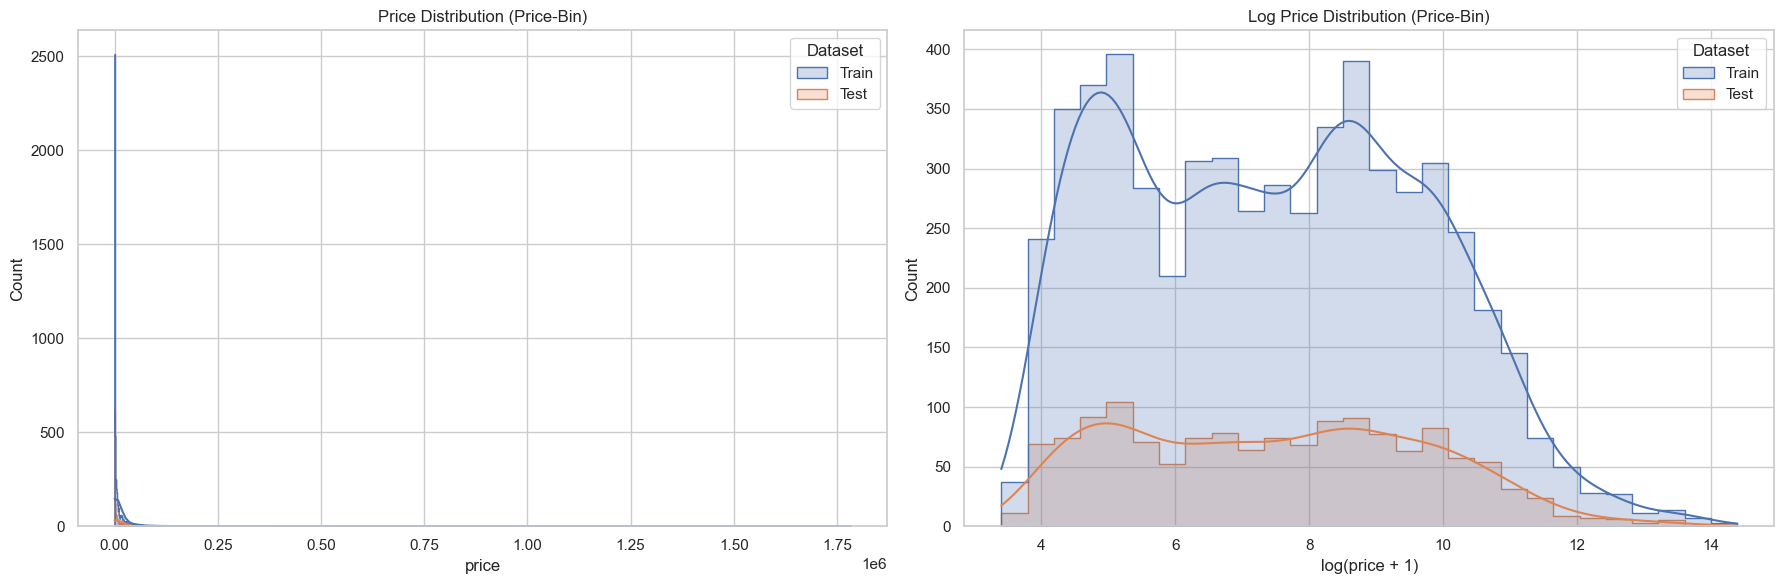

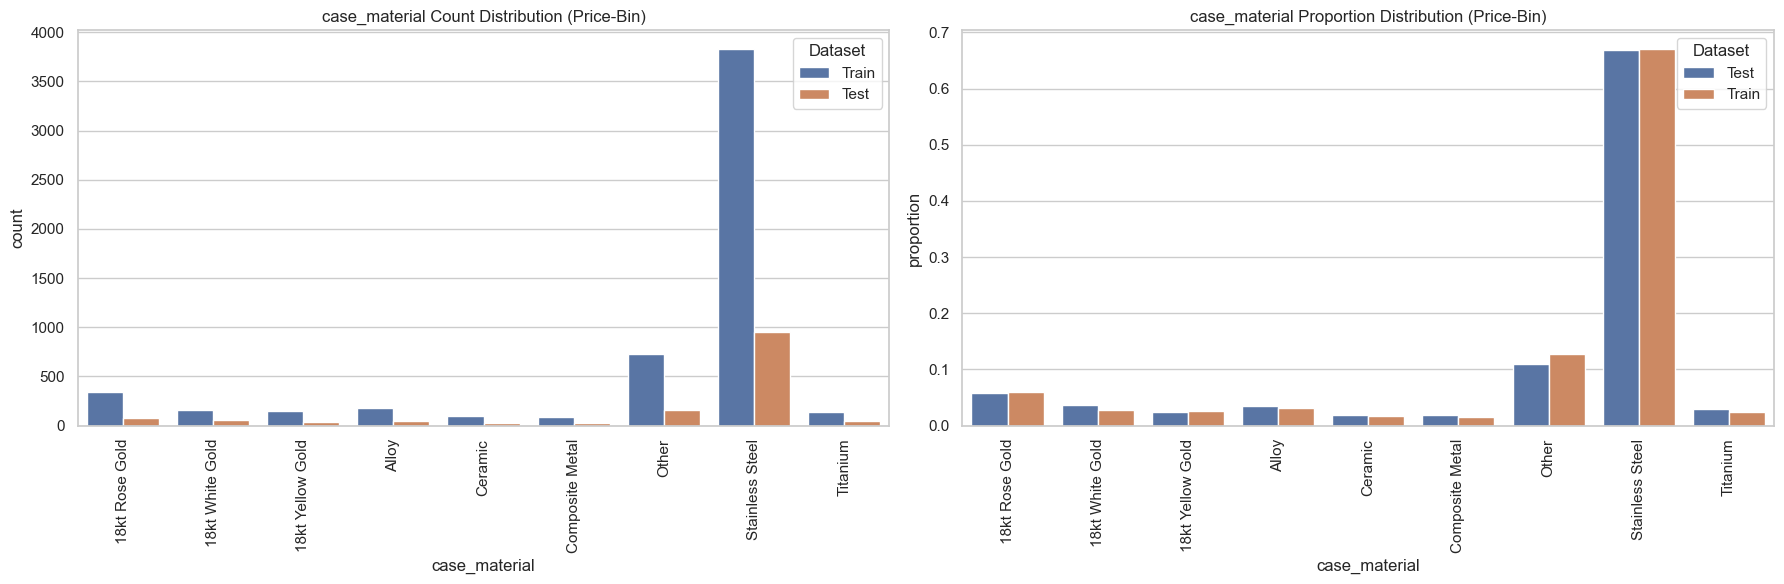

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'


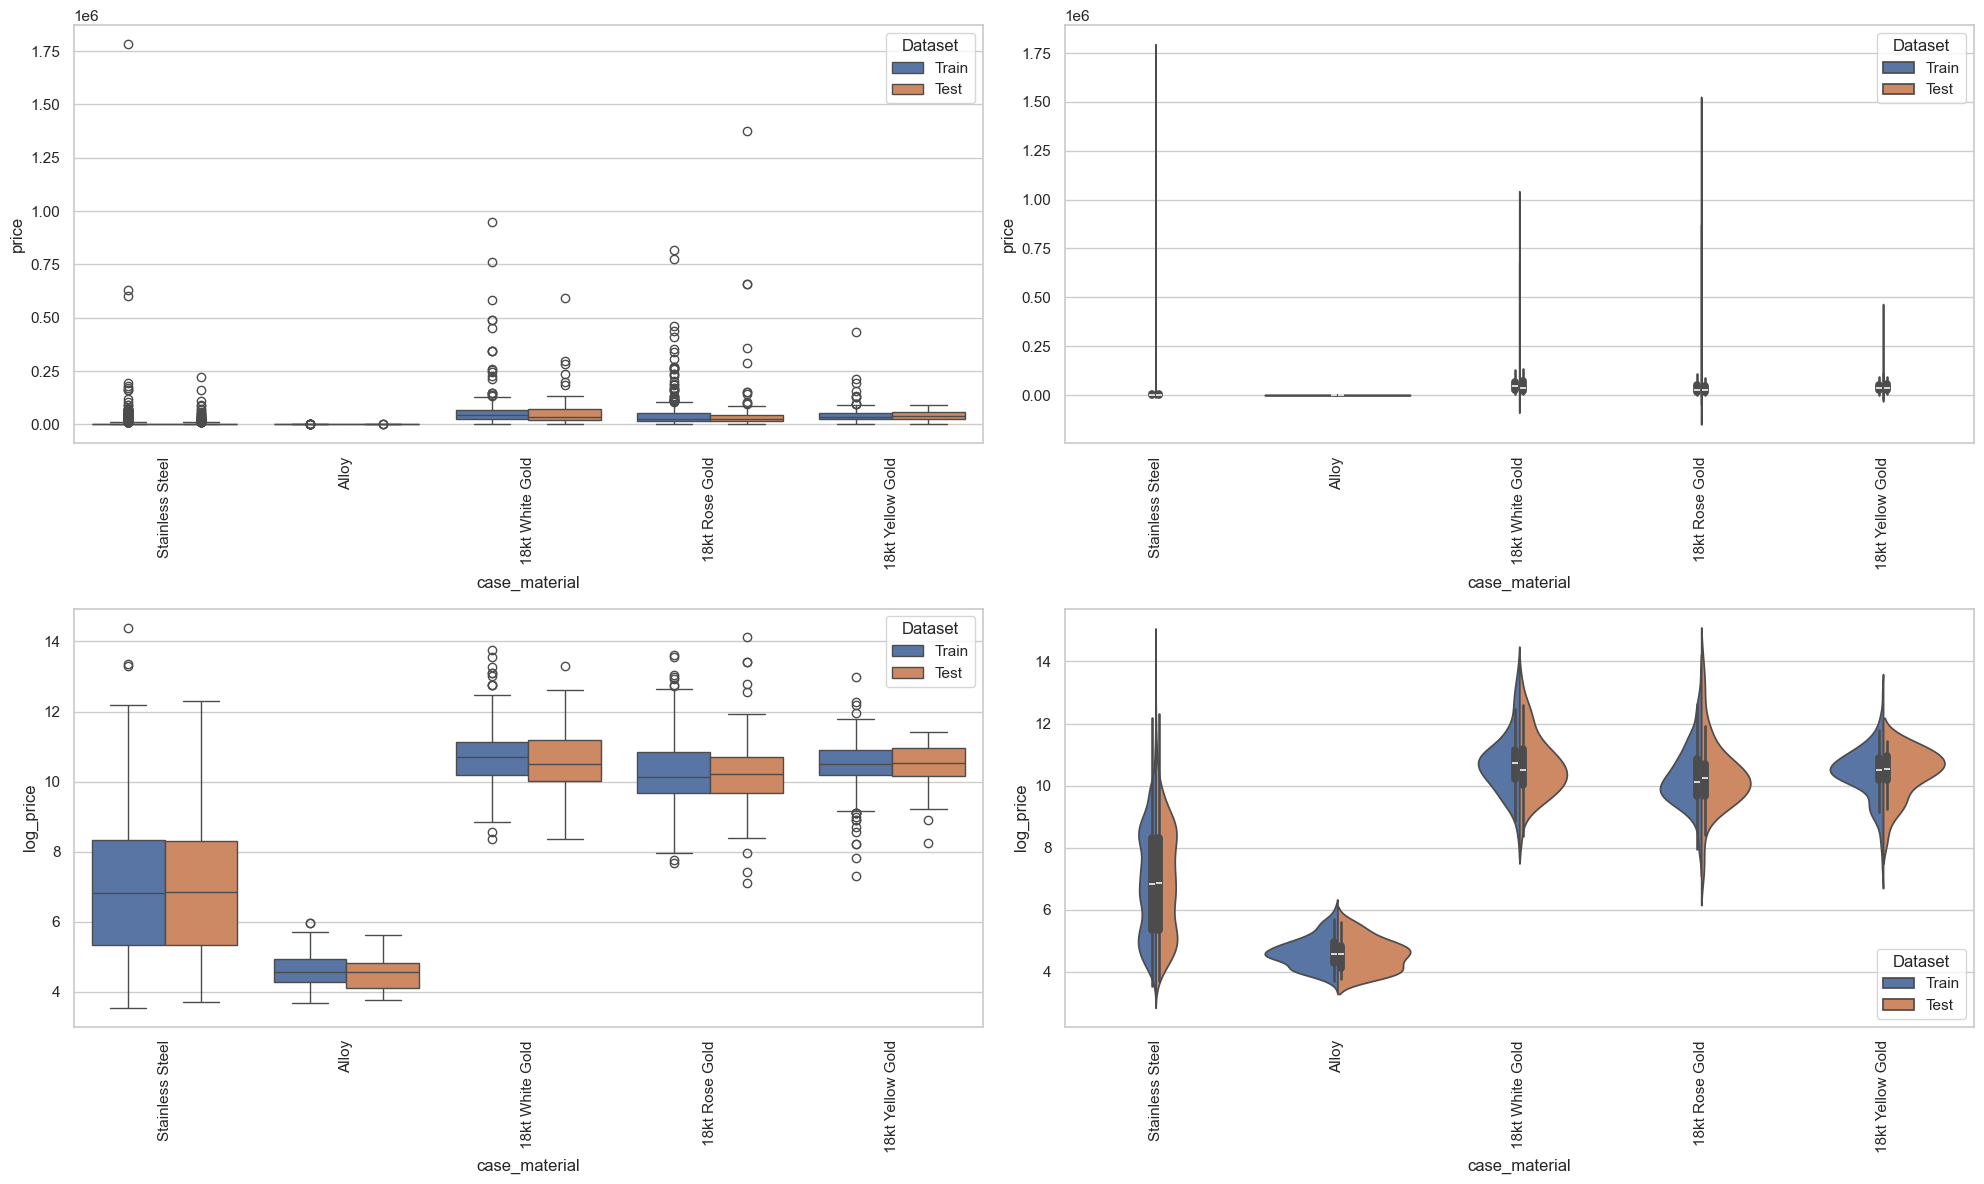

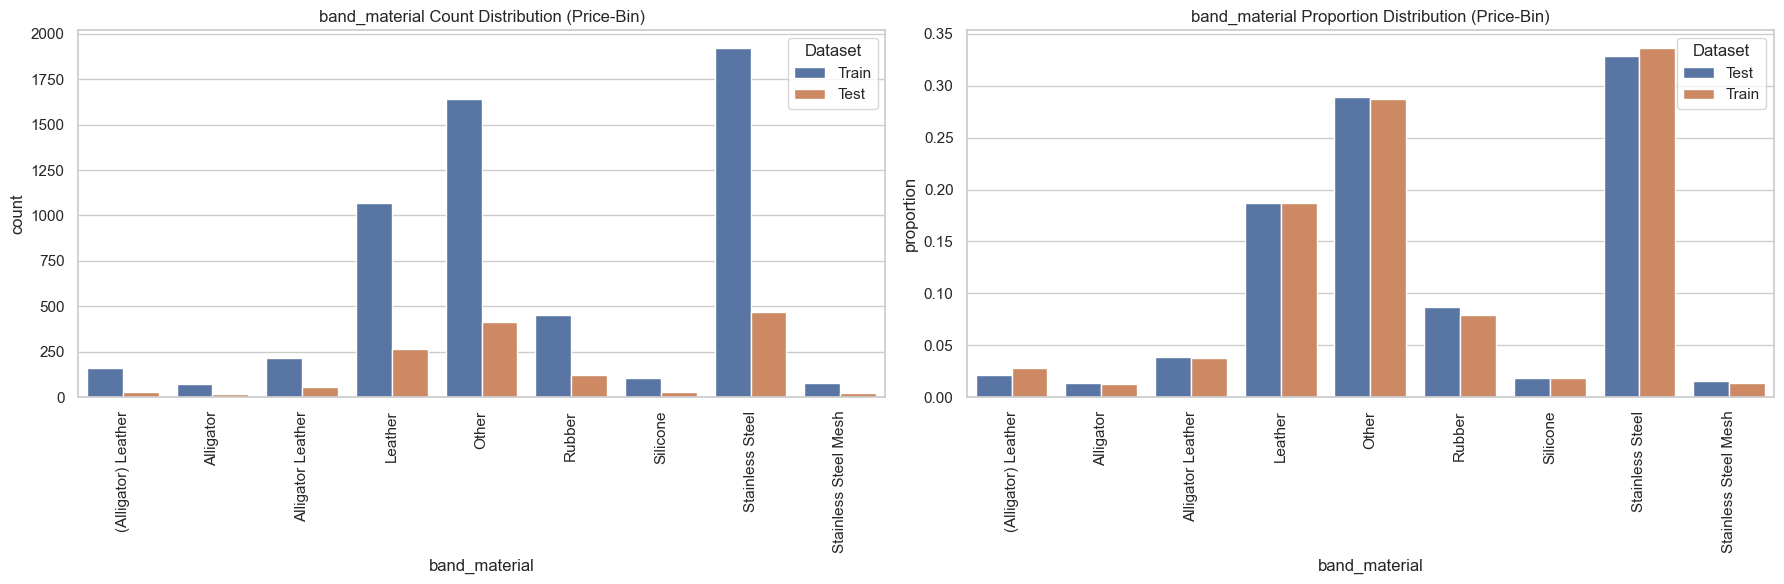

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'


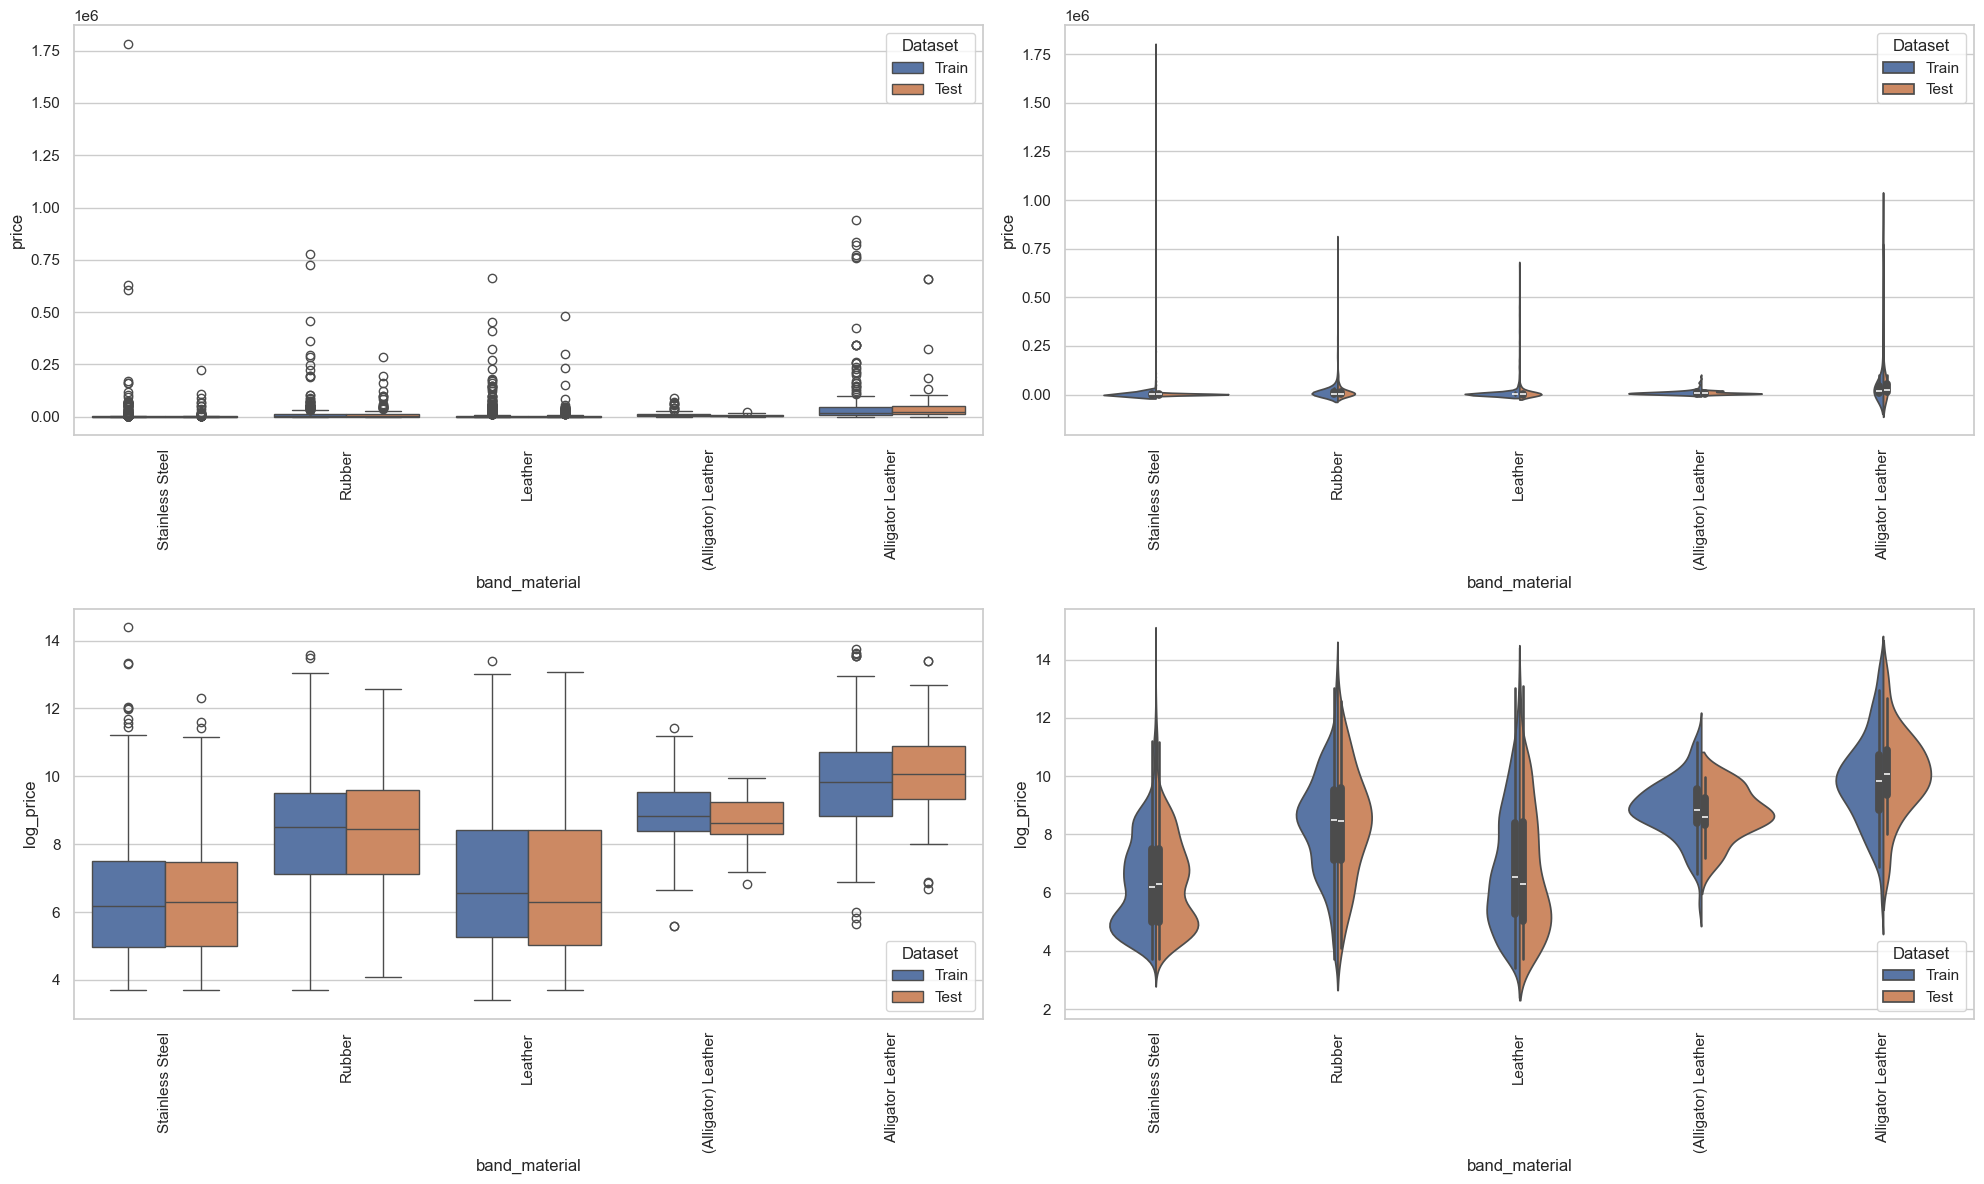

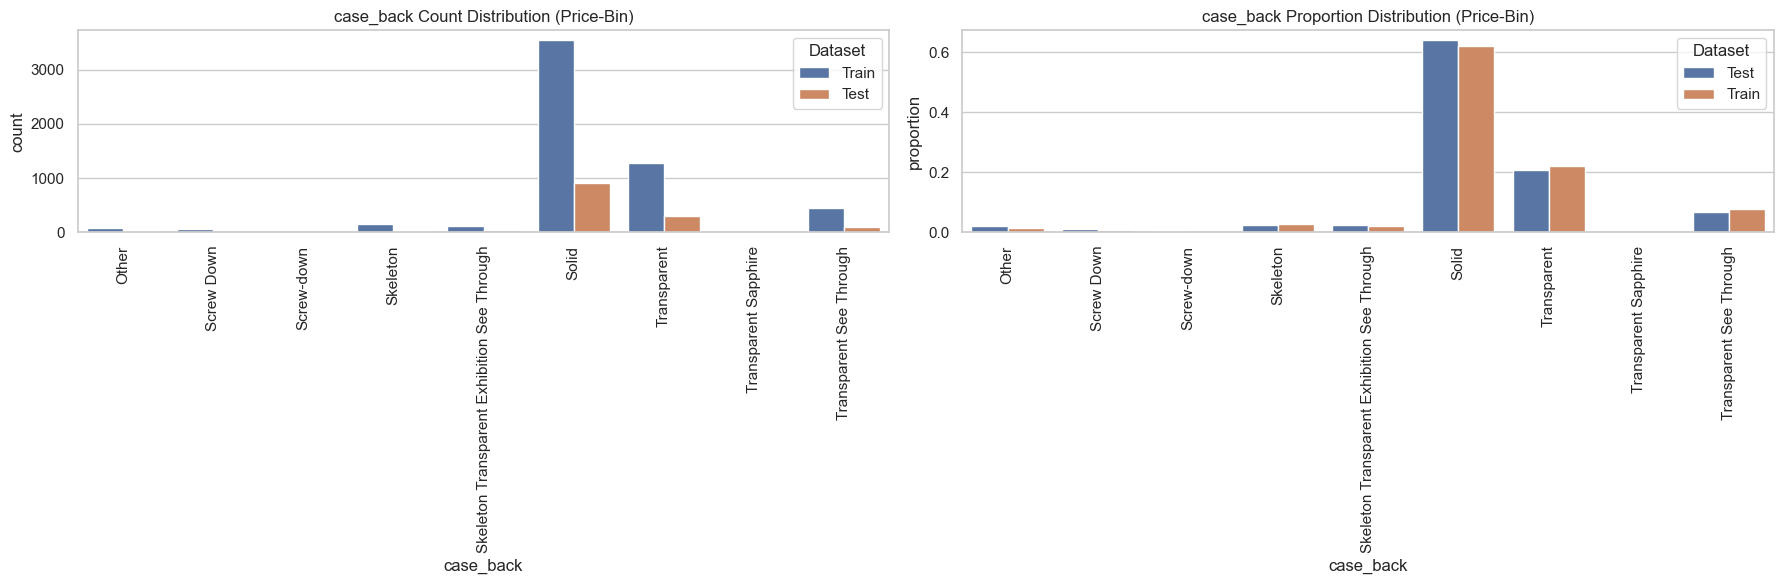

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'


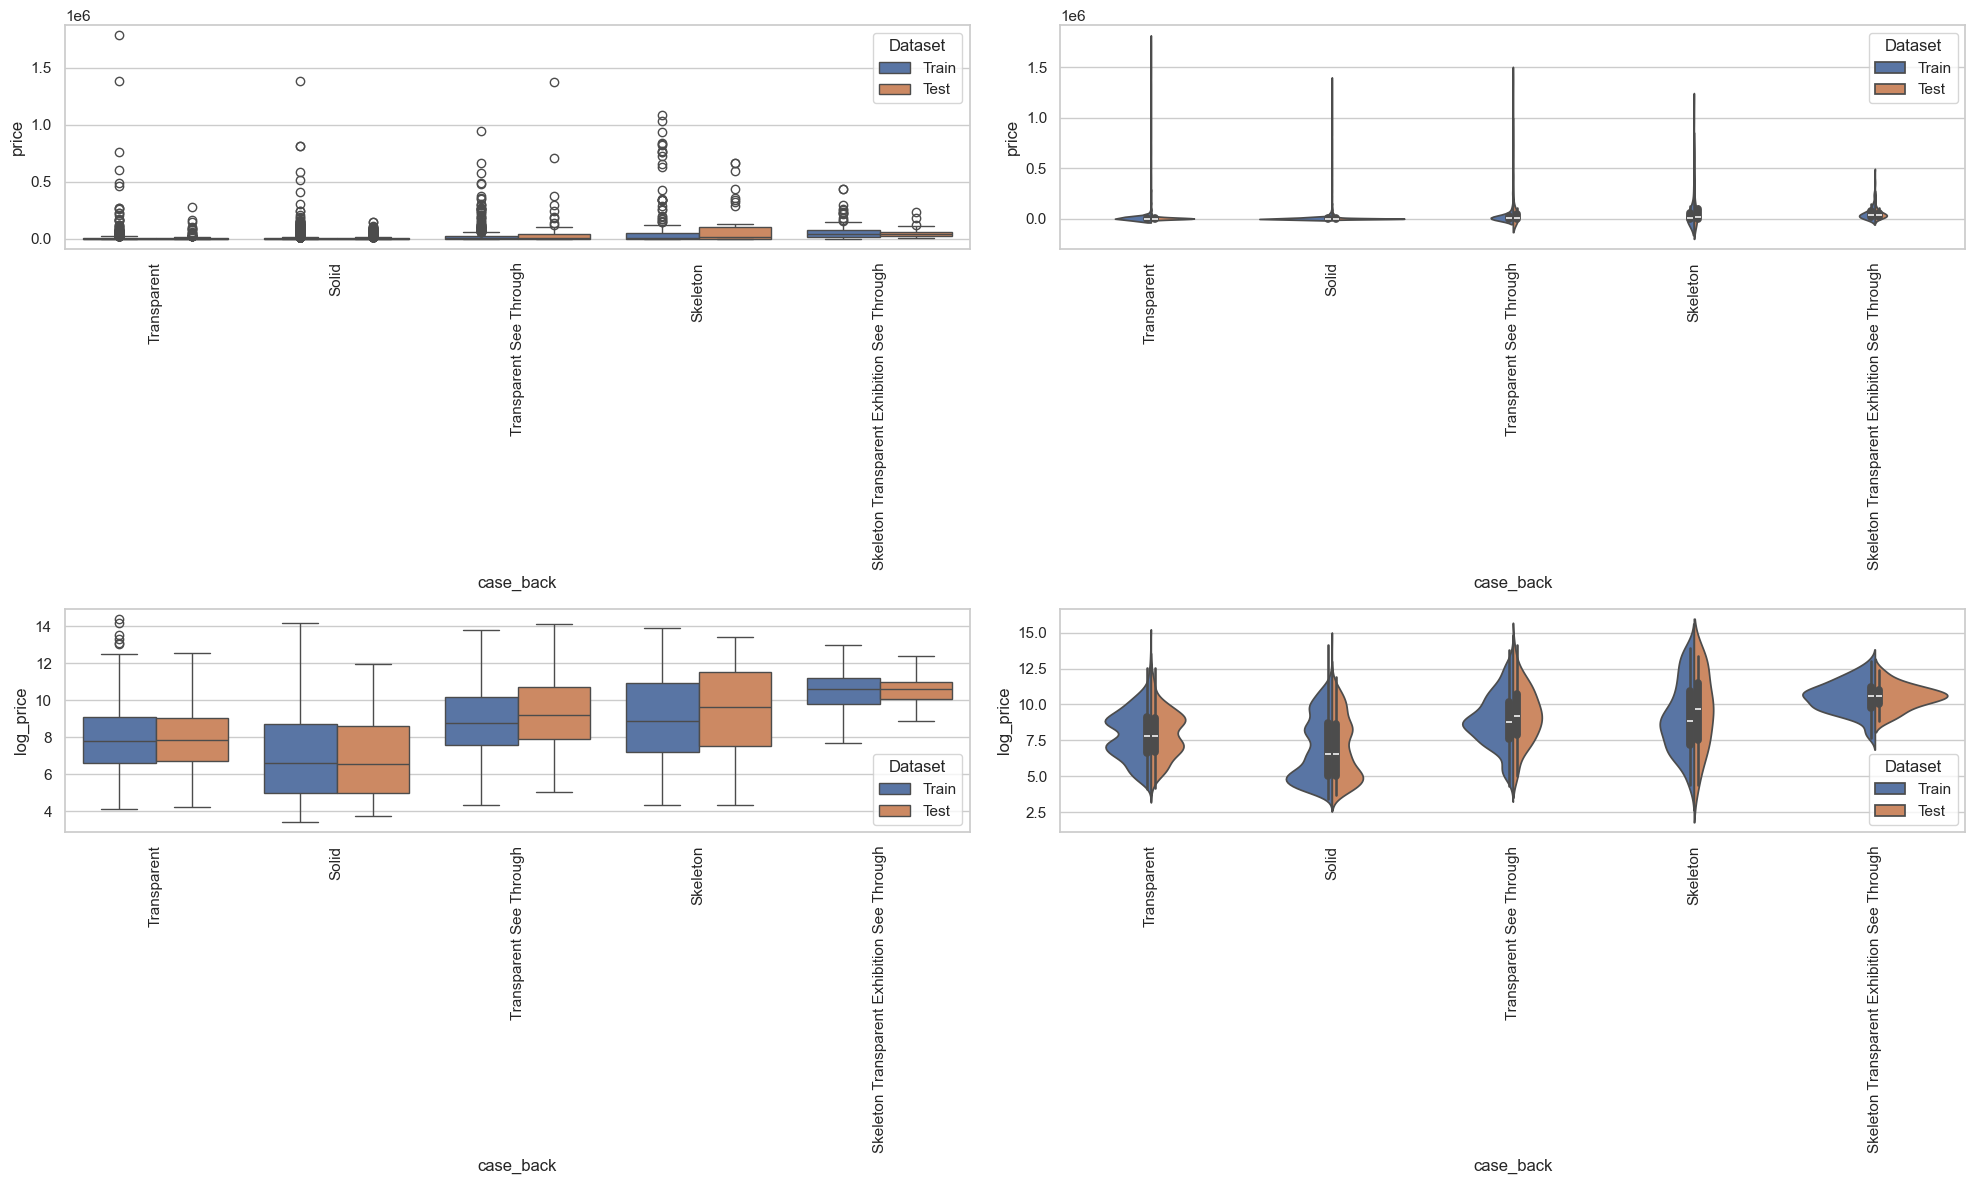

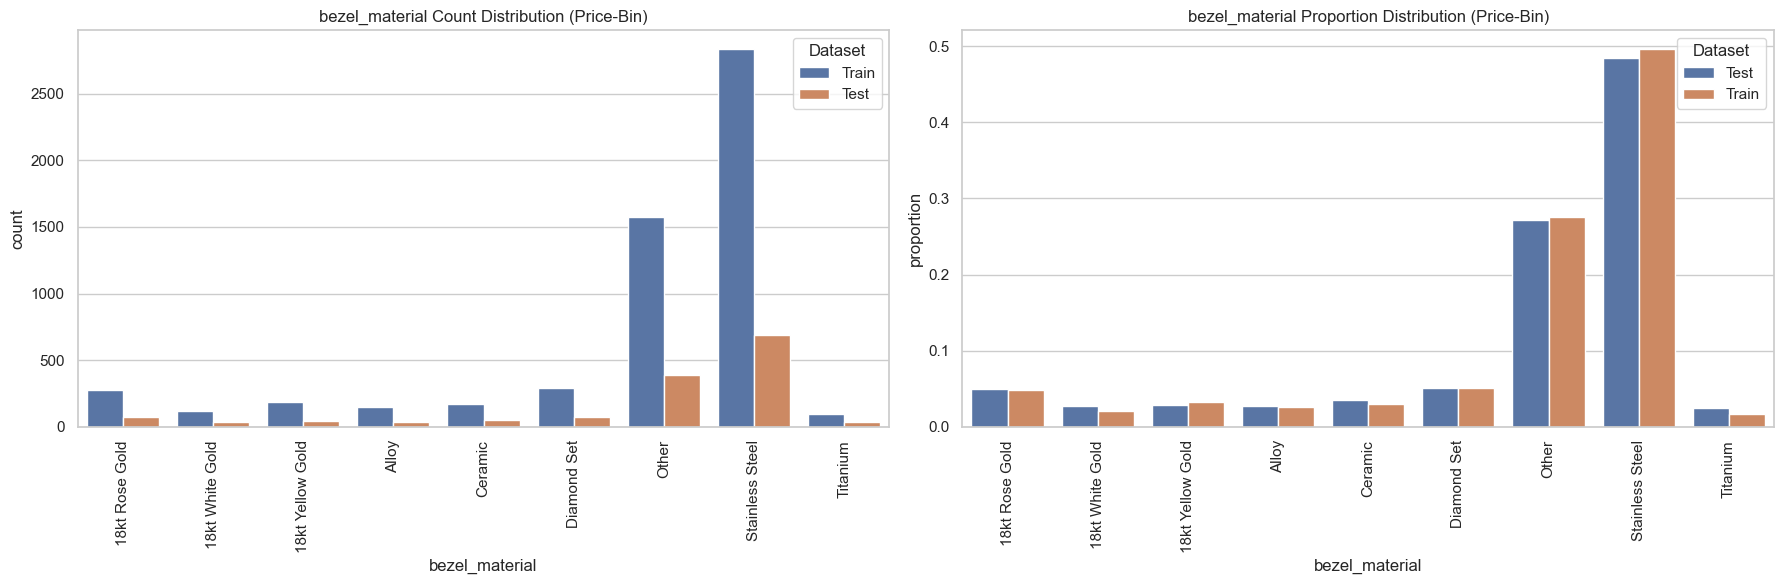

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'


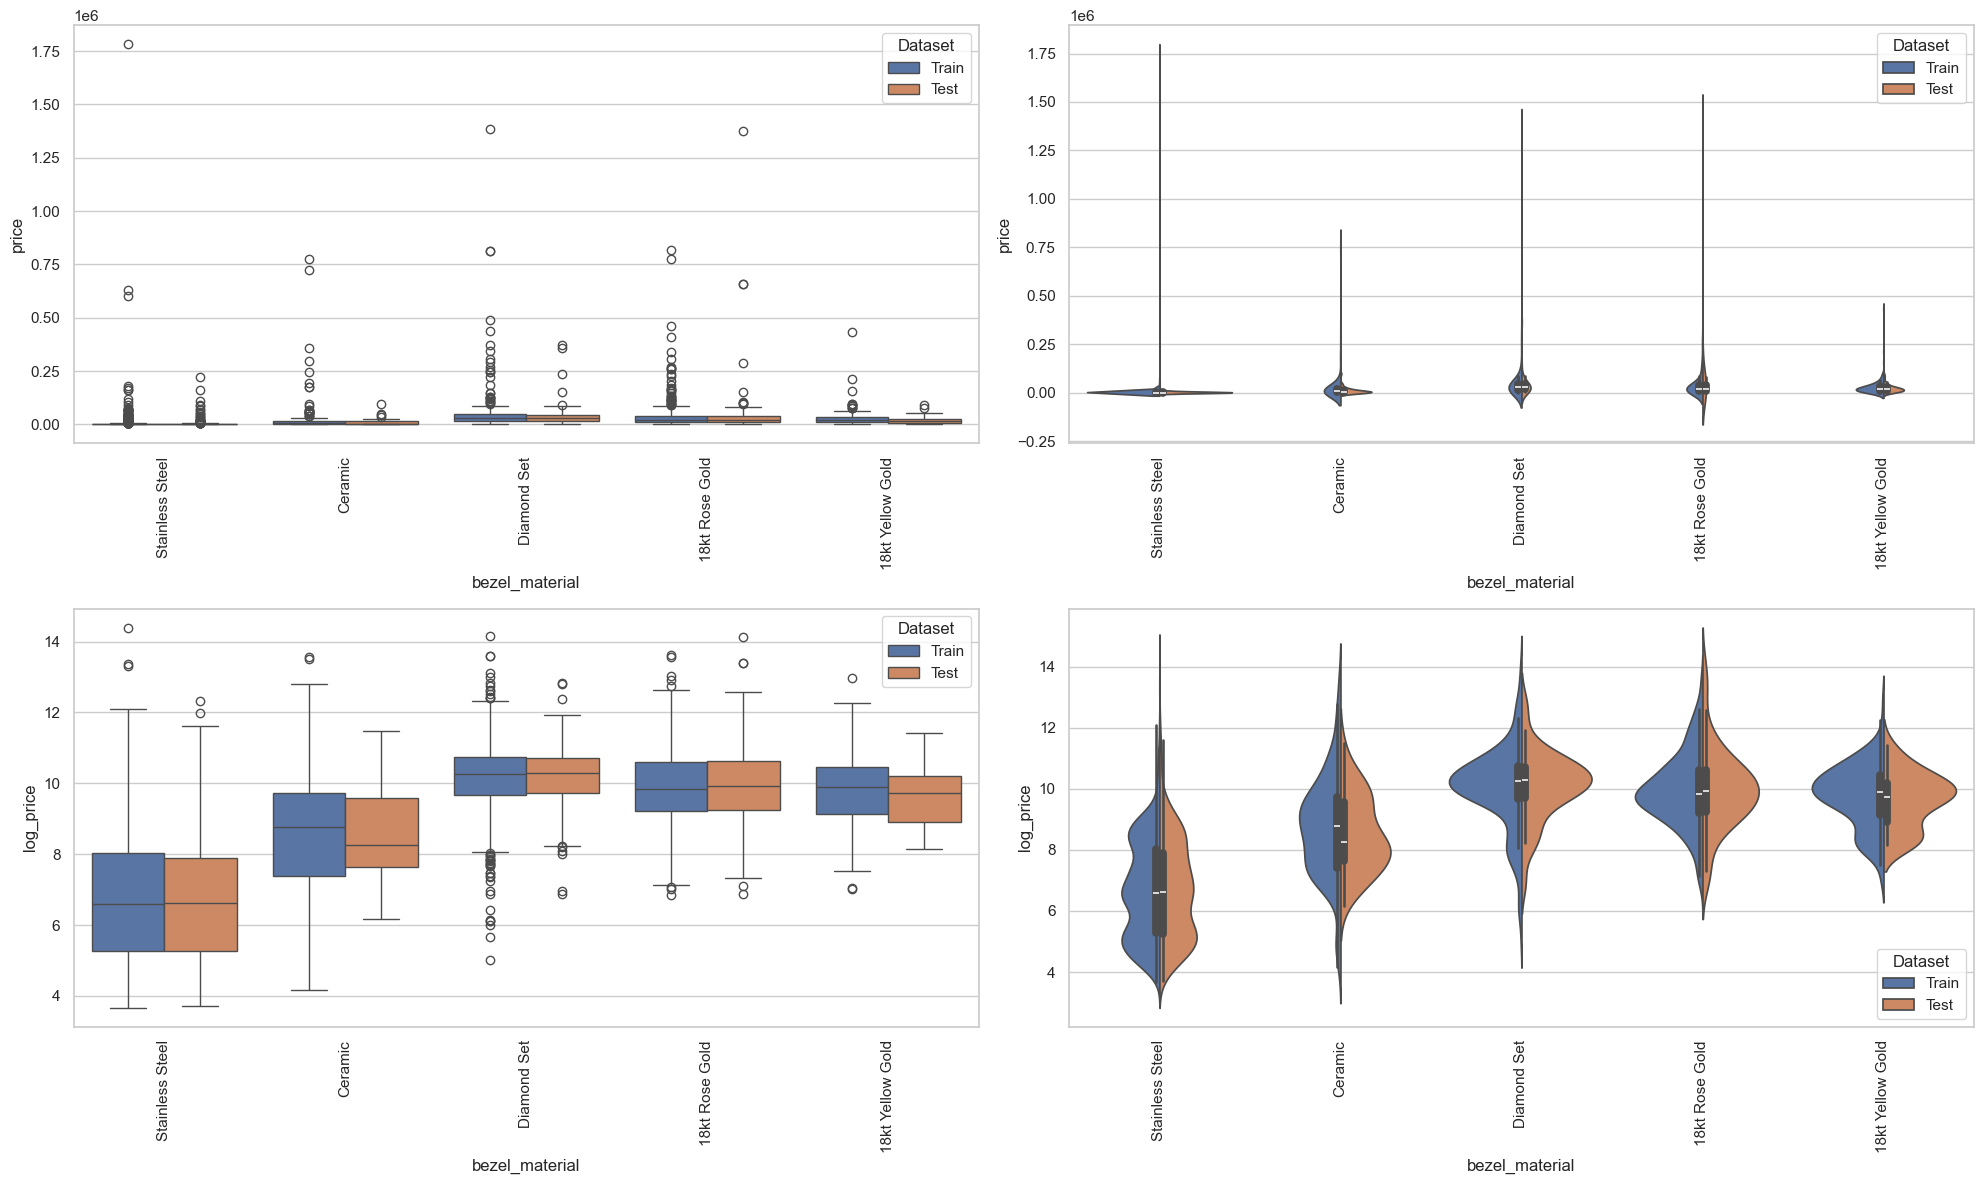

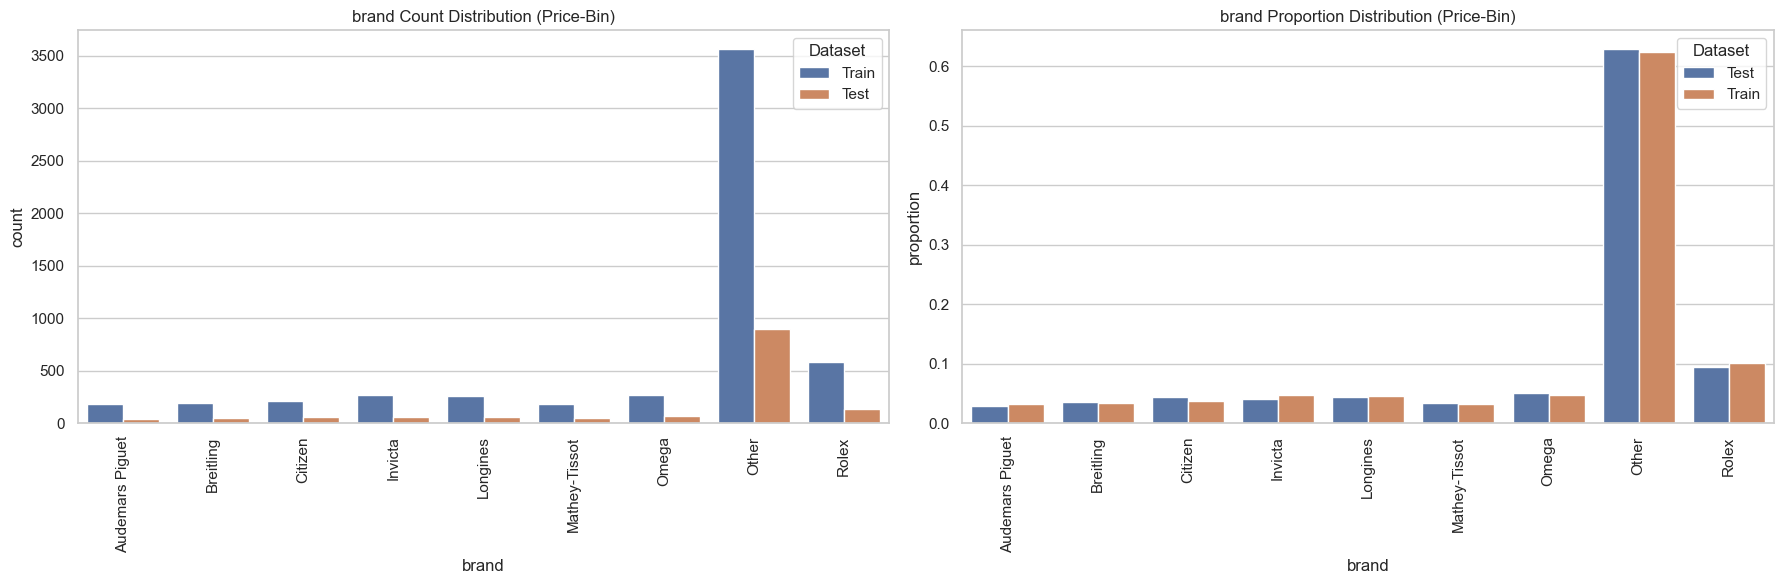

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'


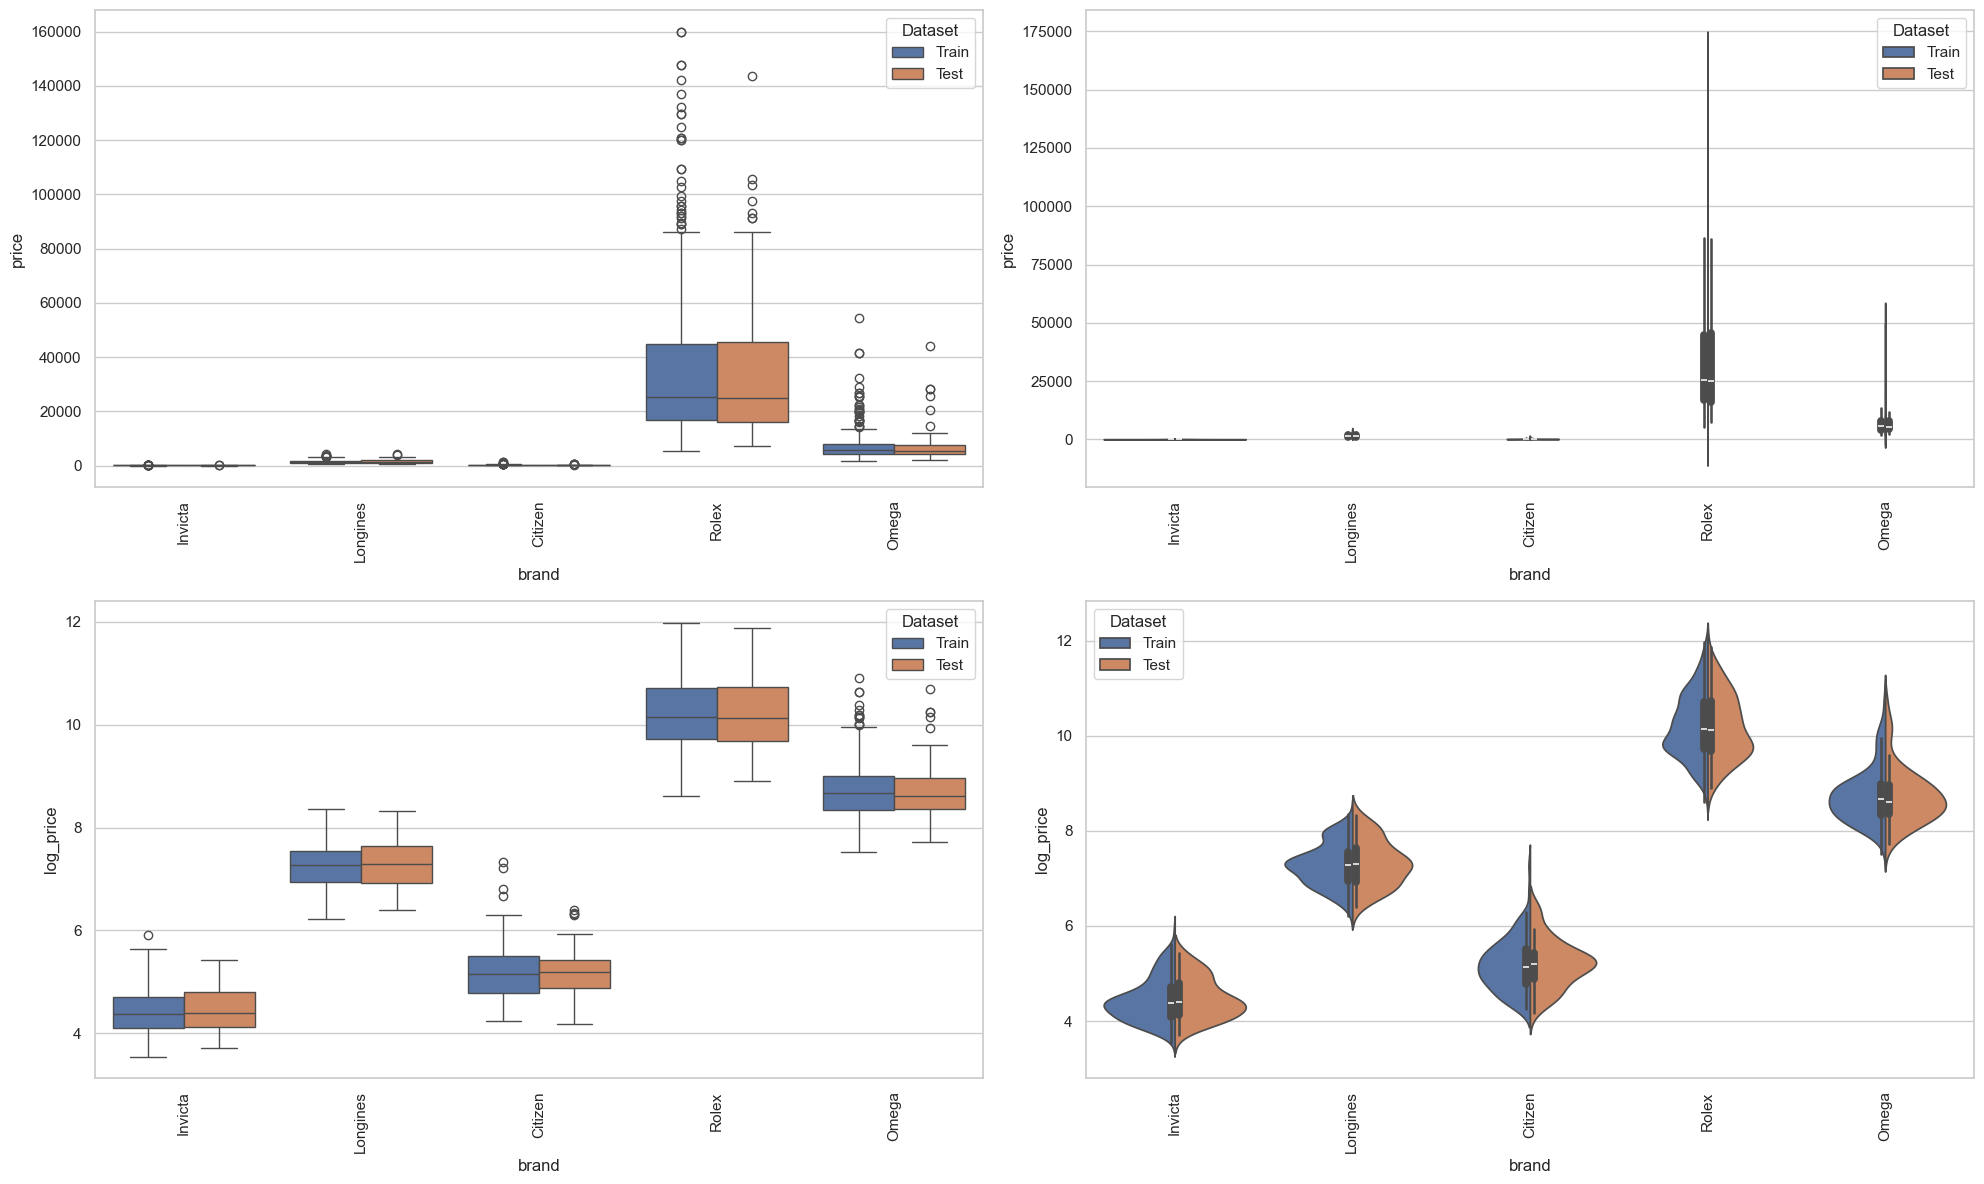

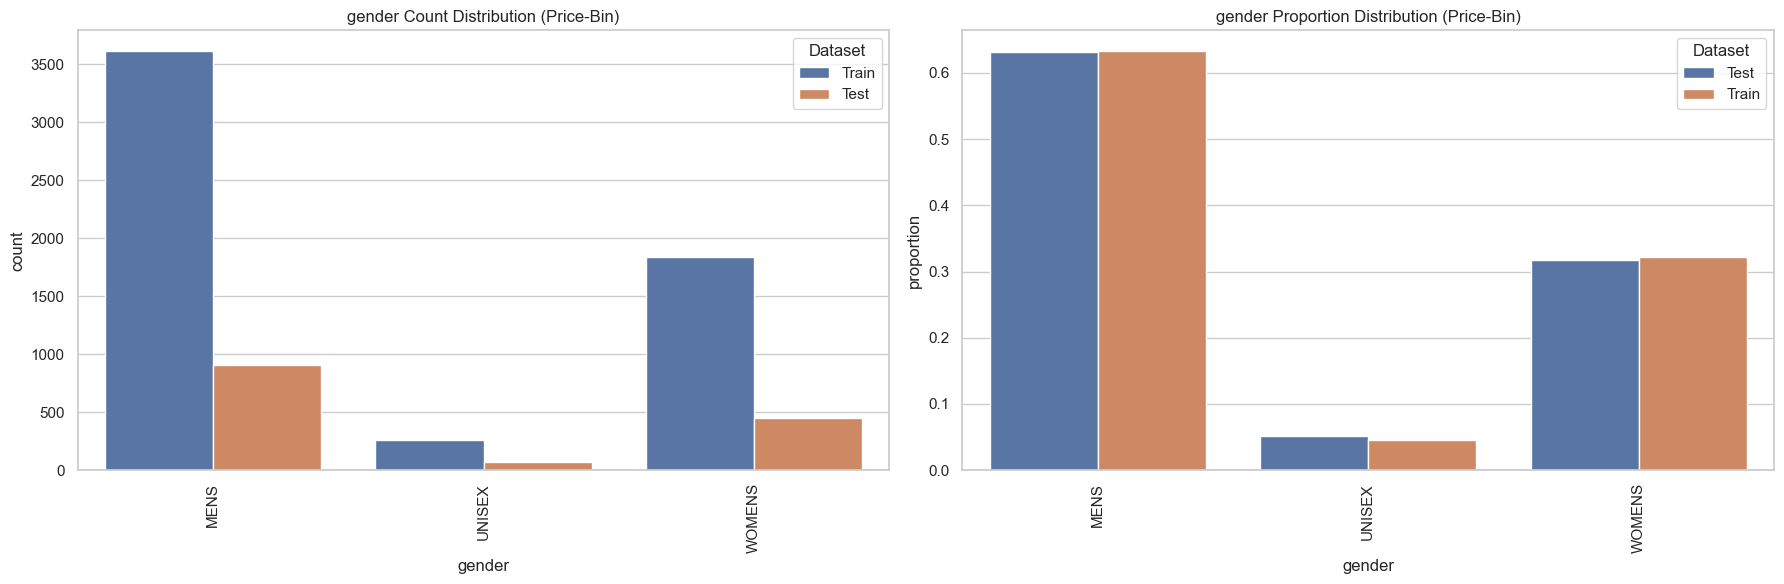

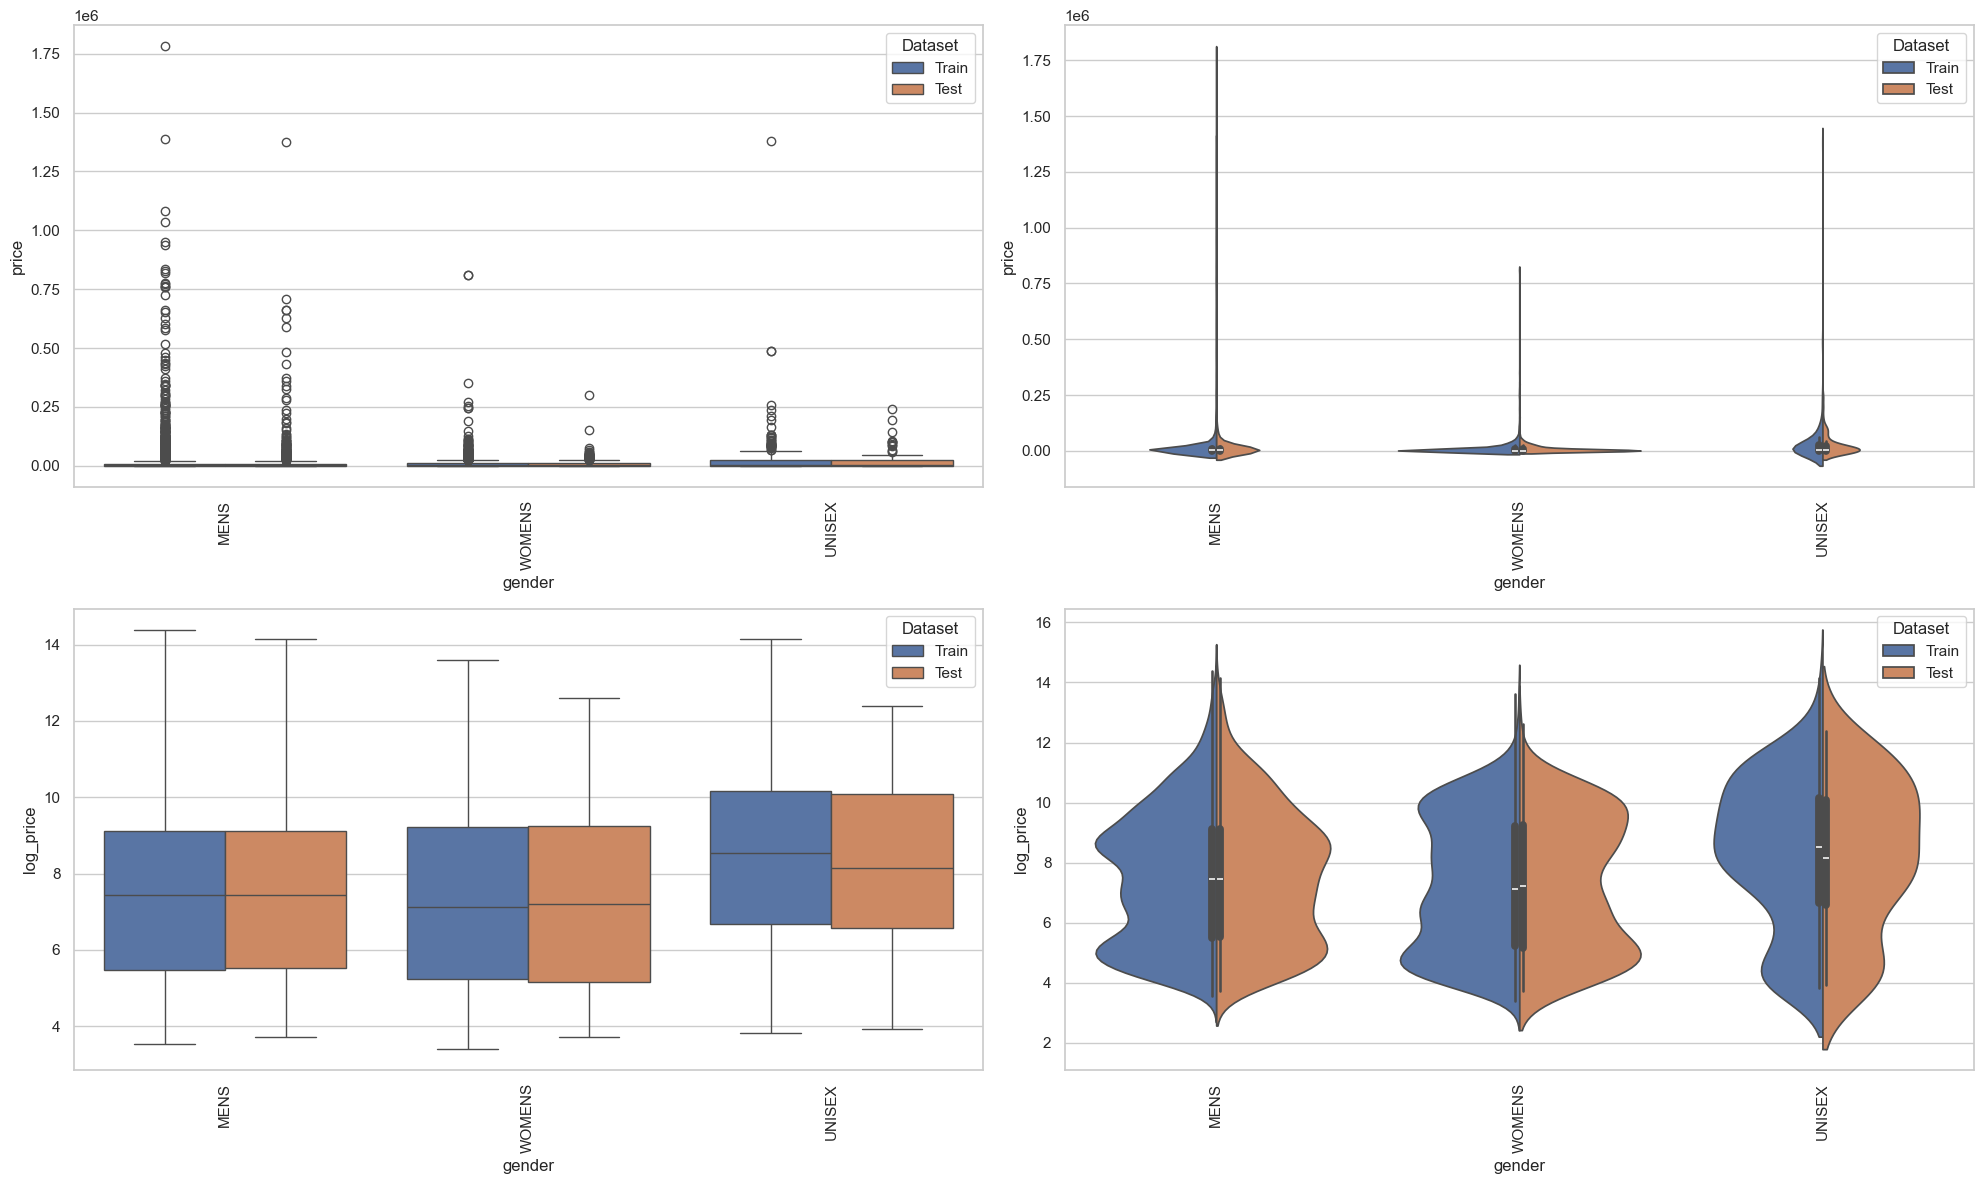

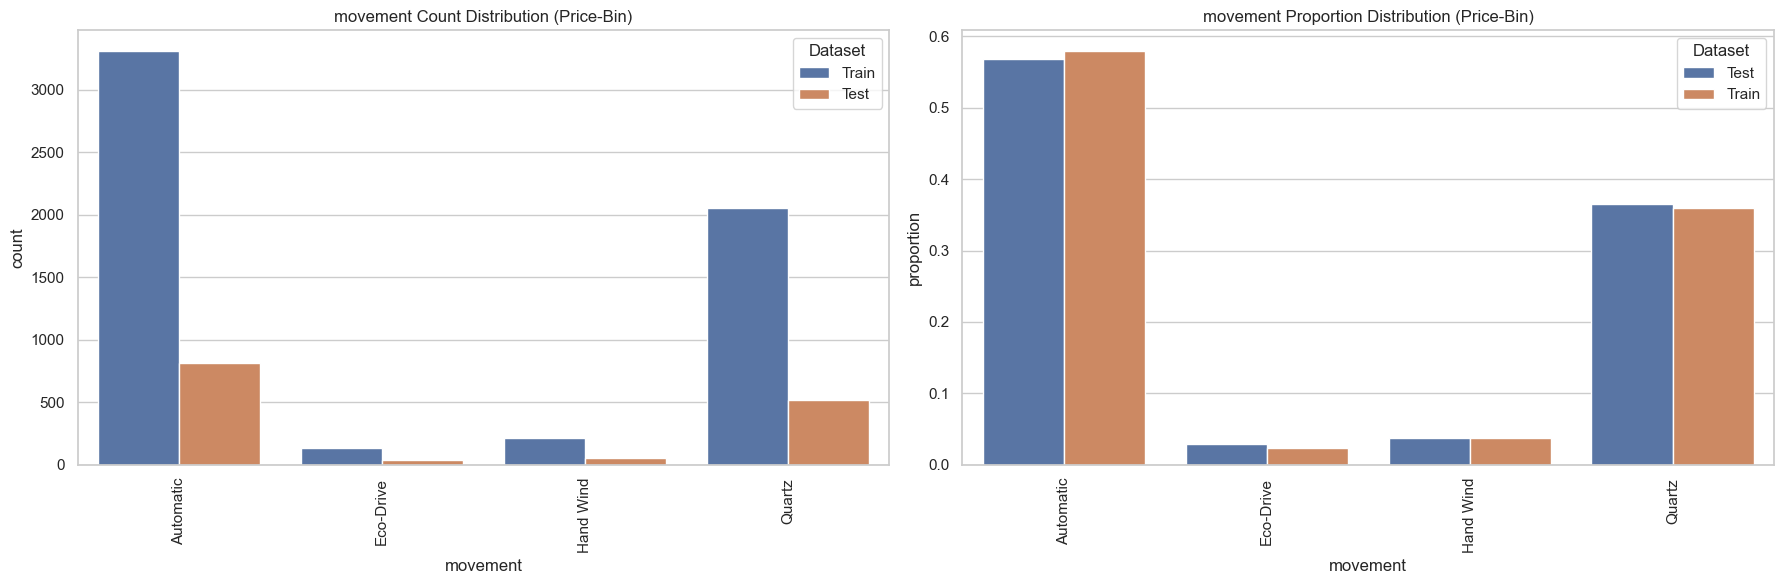

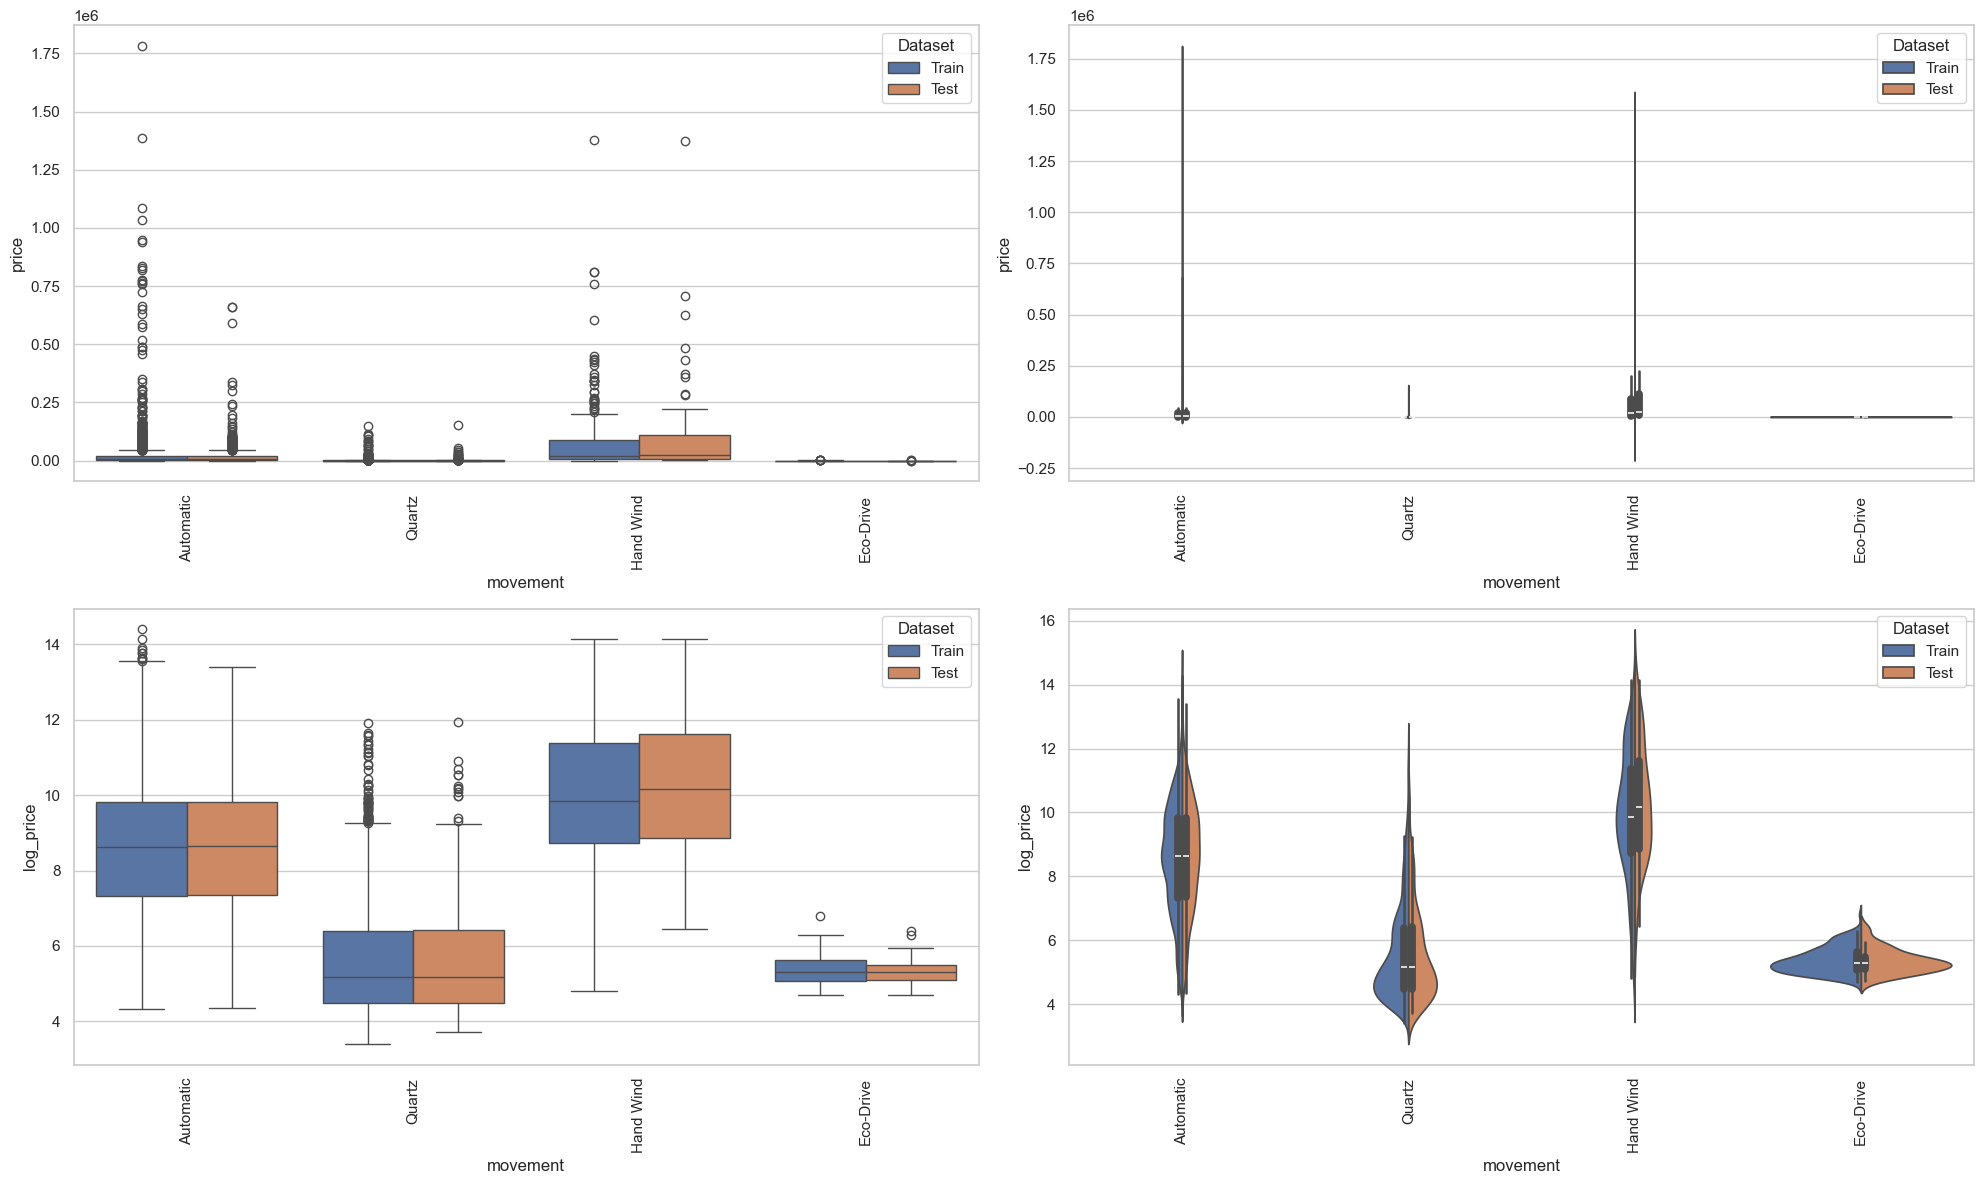

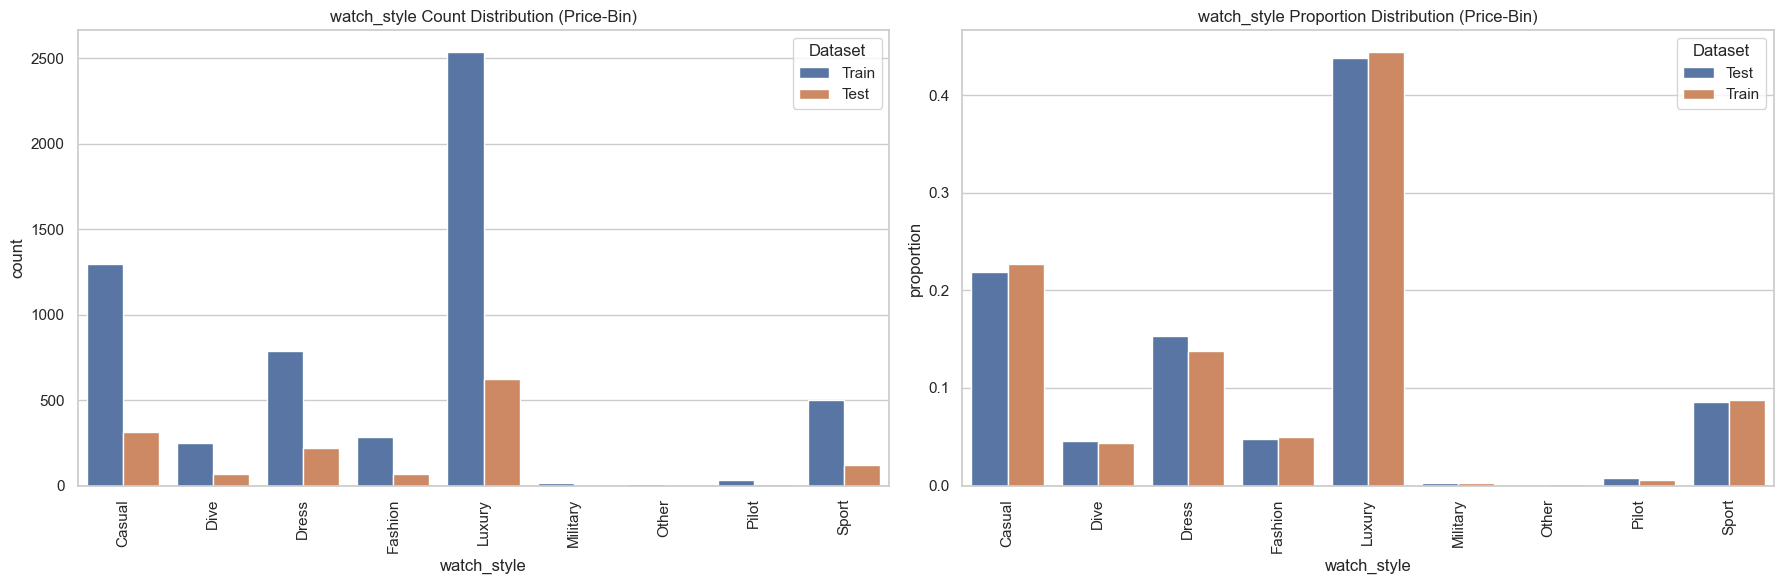

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'


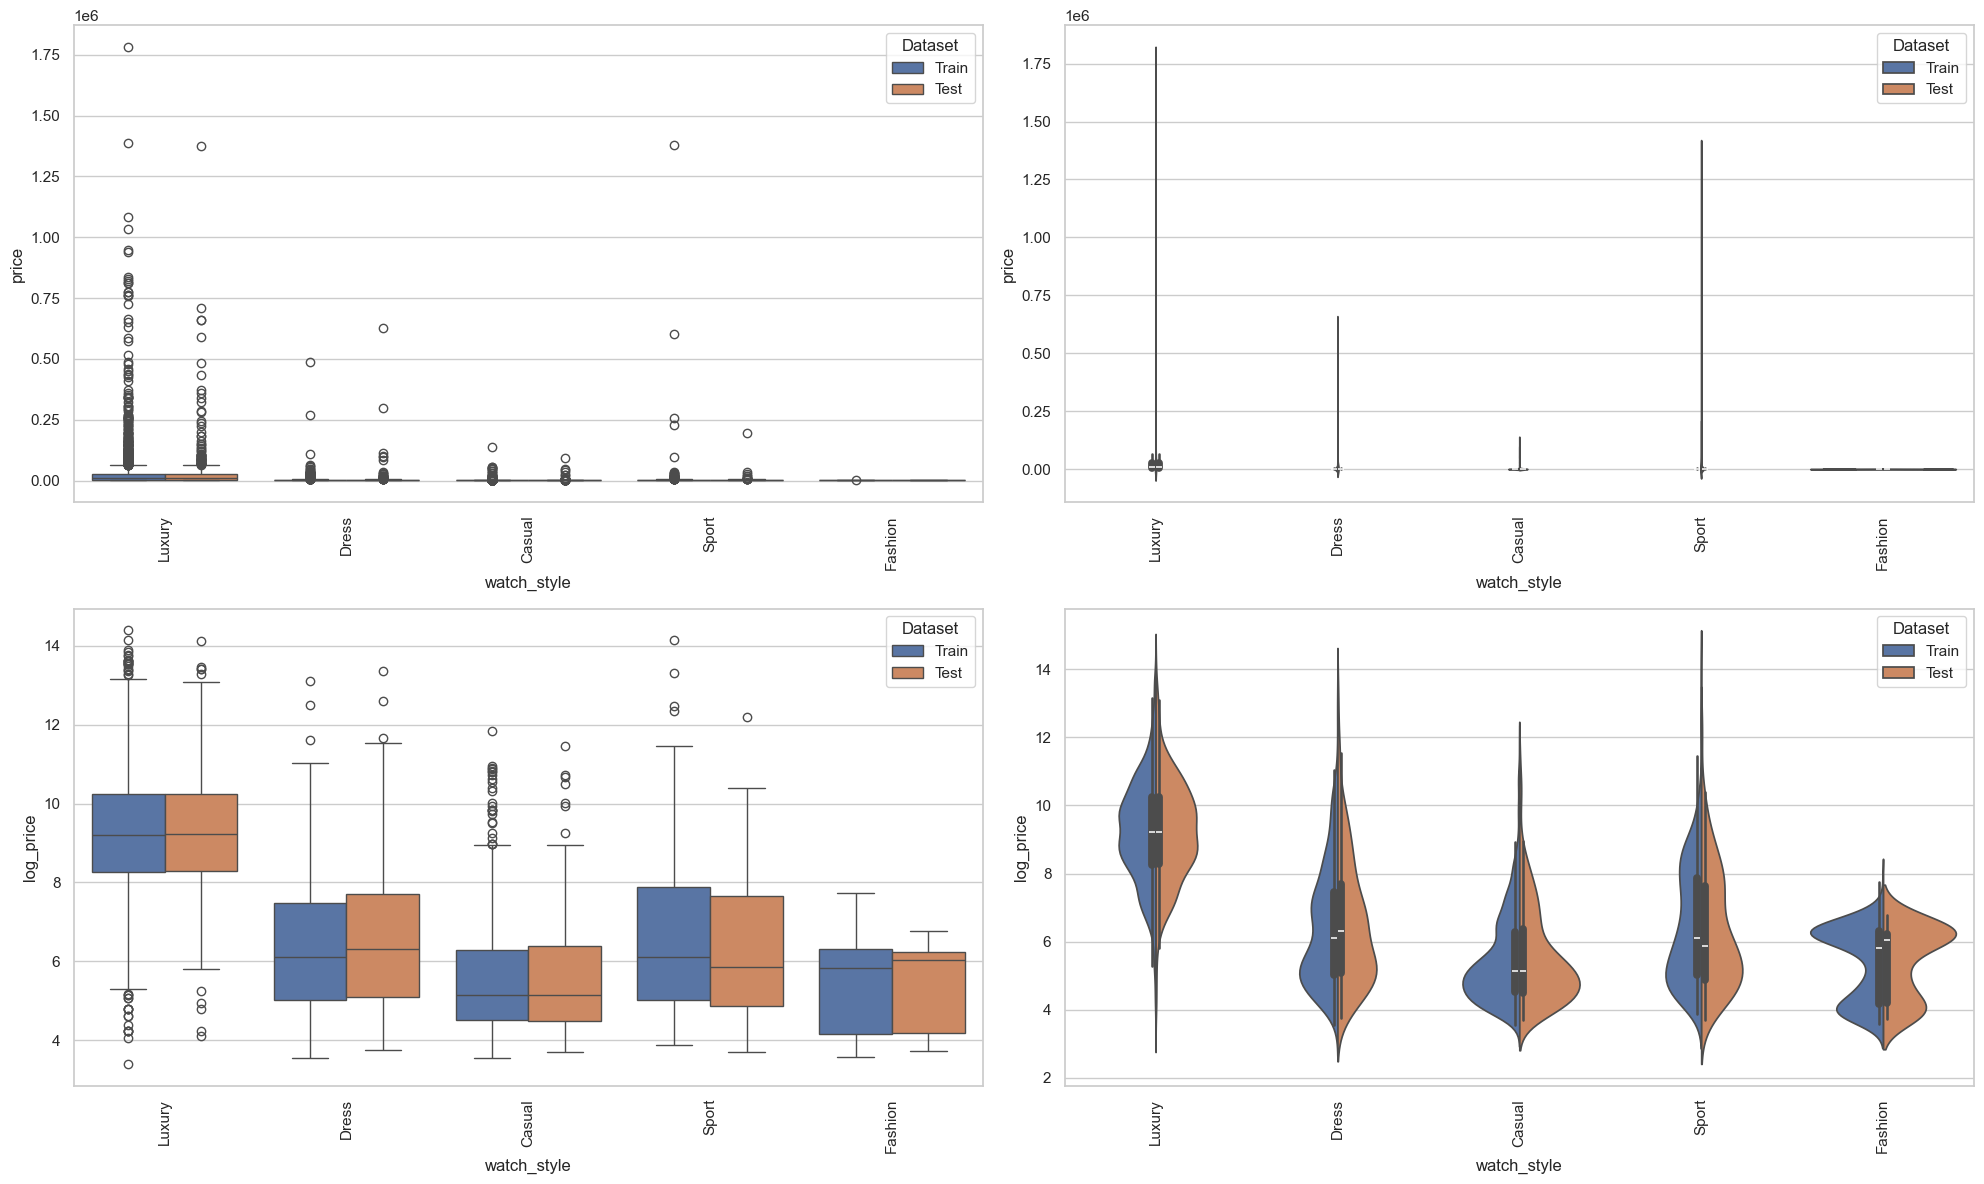

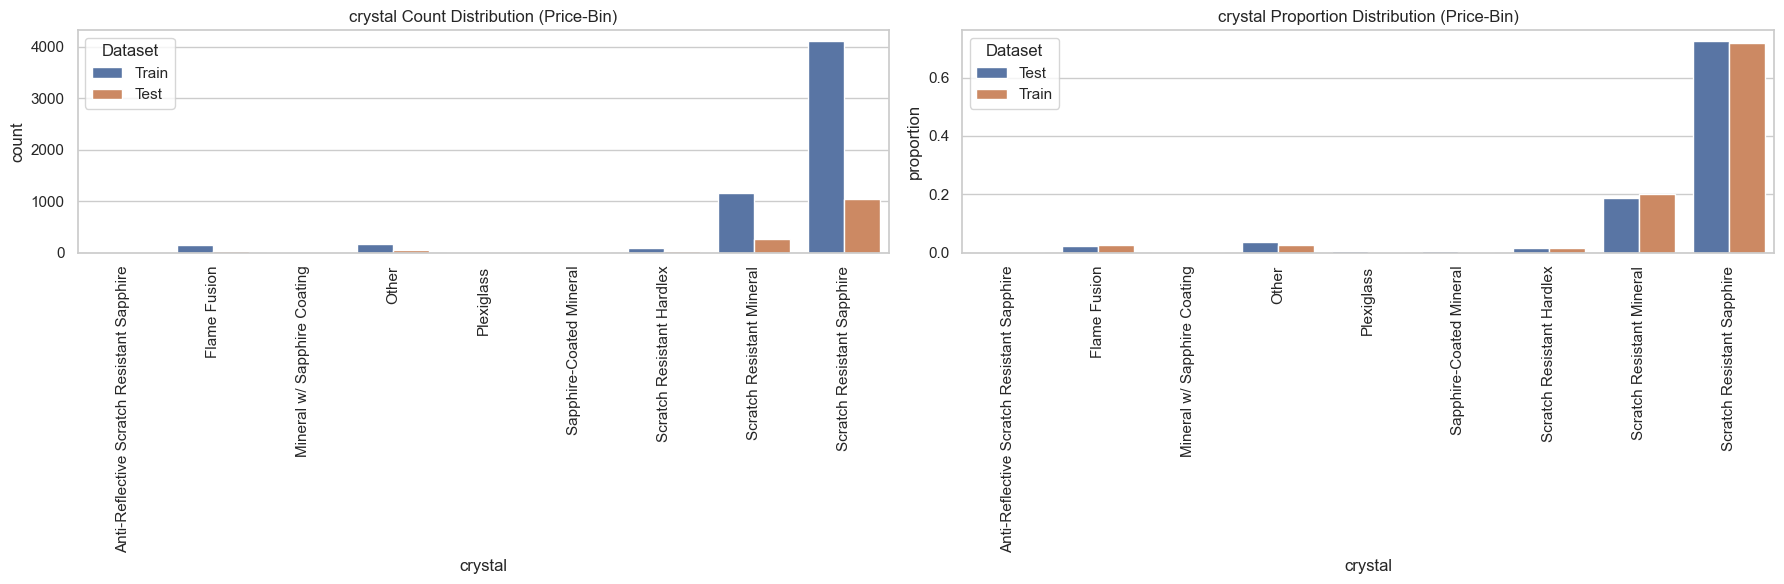

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'


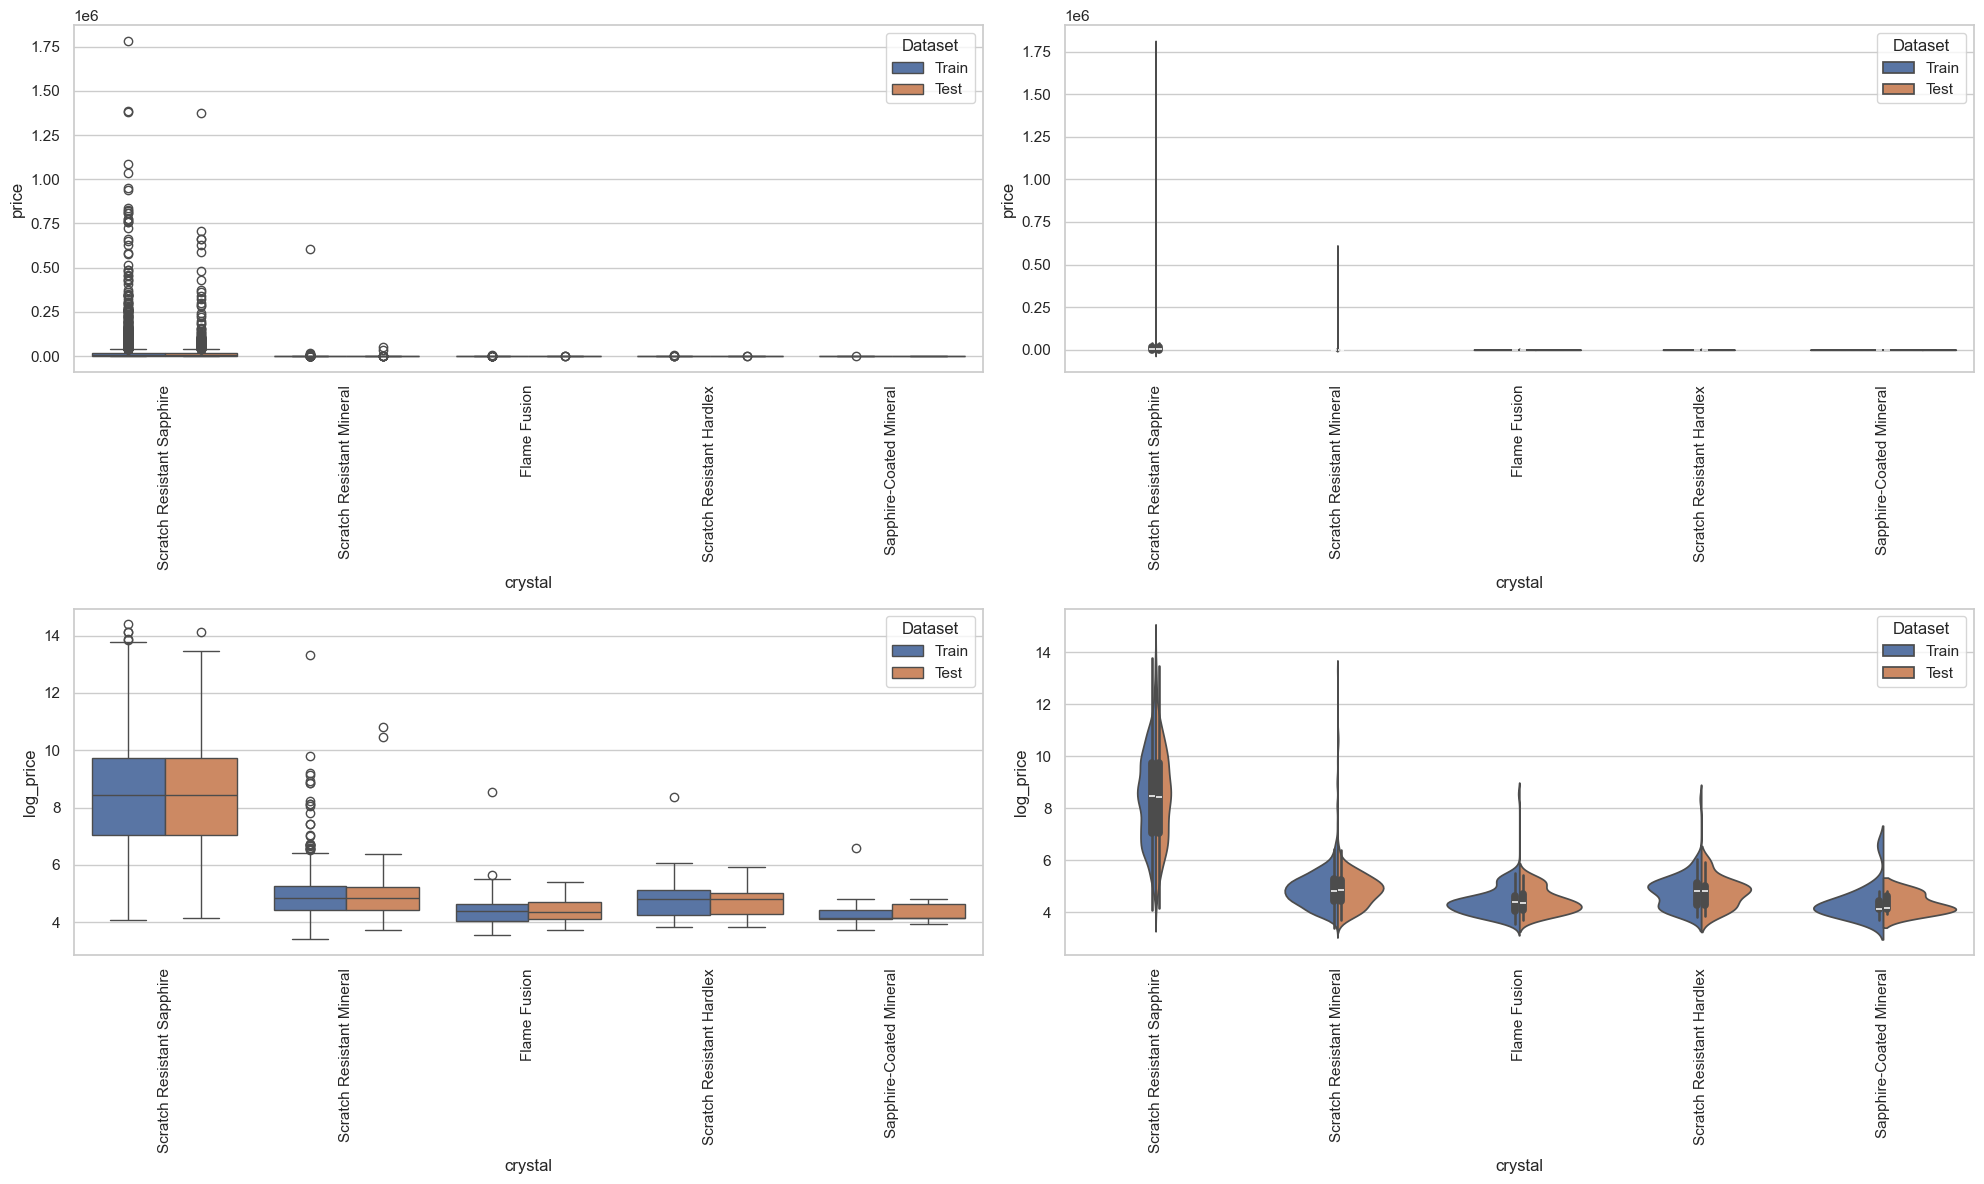

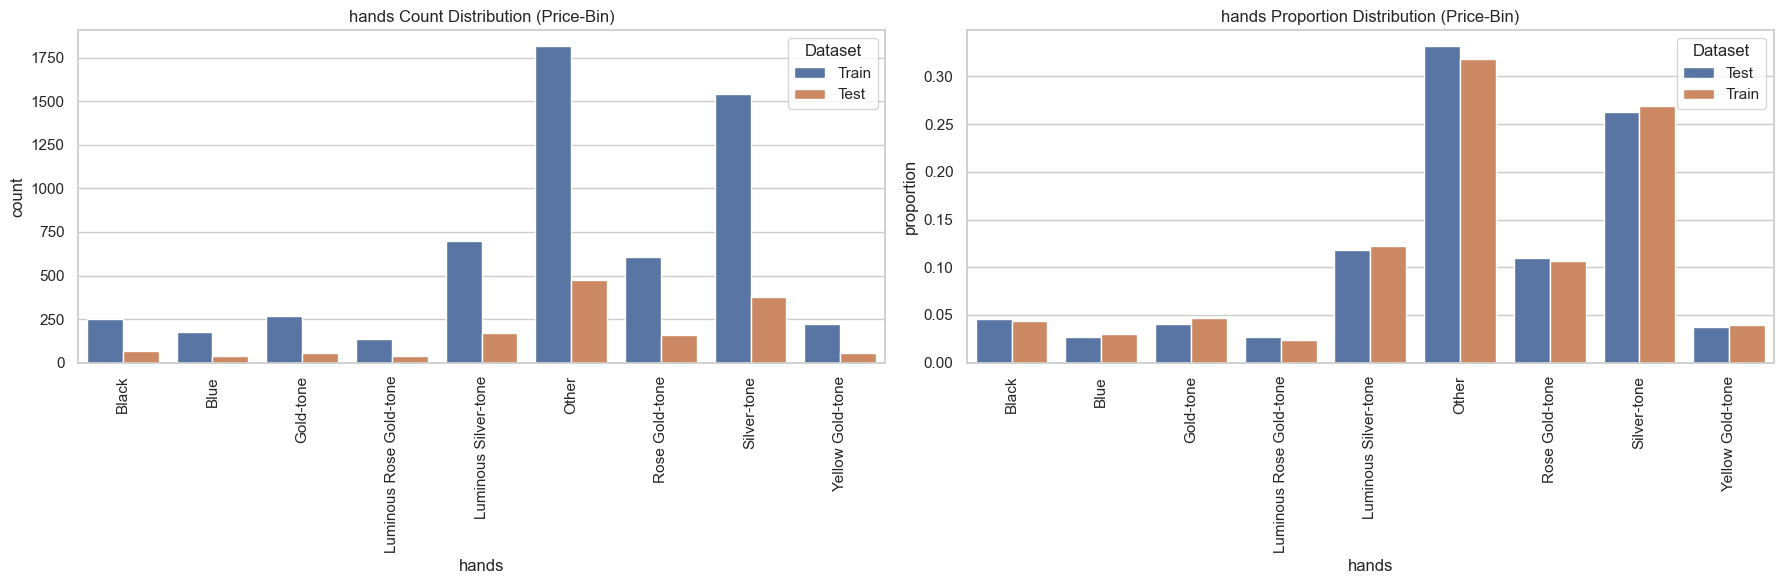

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'


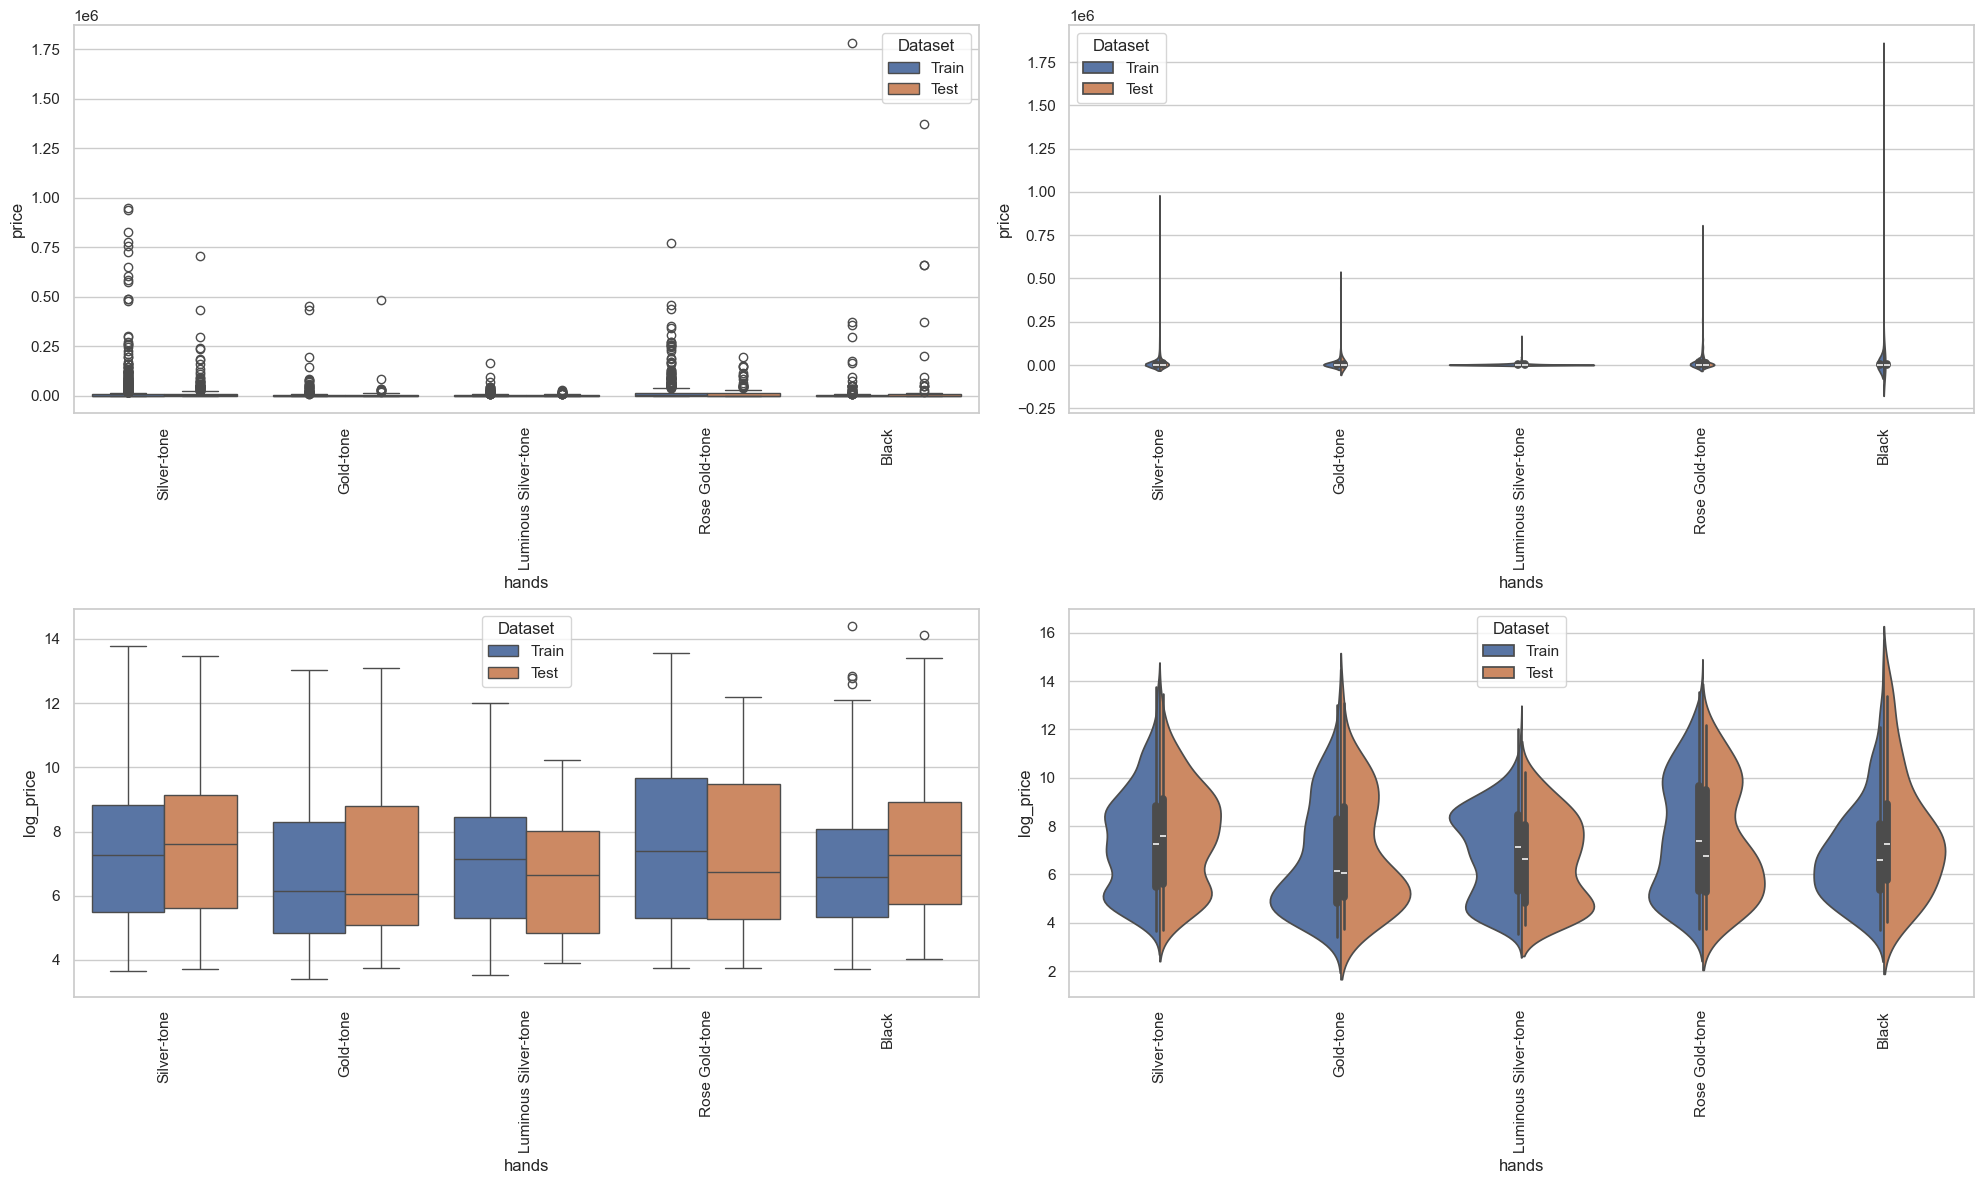

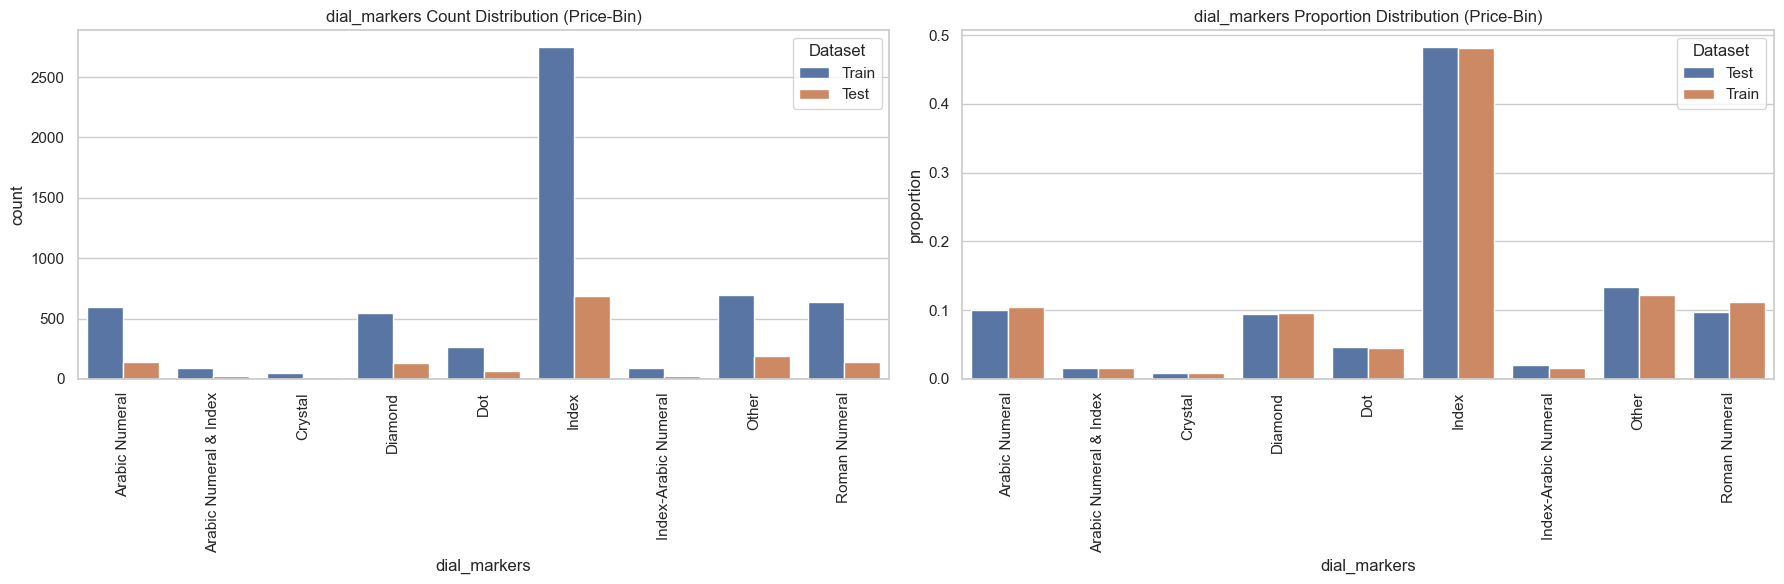

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\331373225.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_f['Dataset'] = 'Train'; test_f['Dataset'] = 'Test'


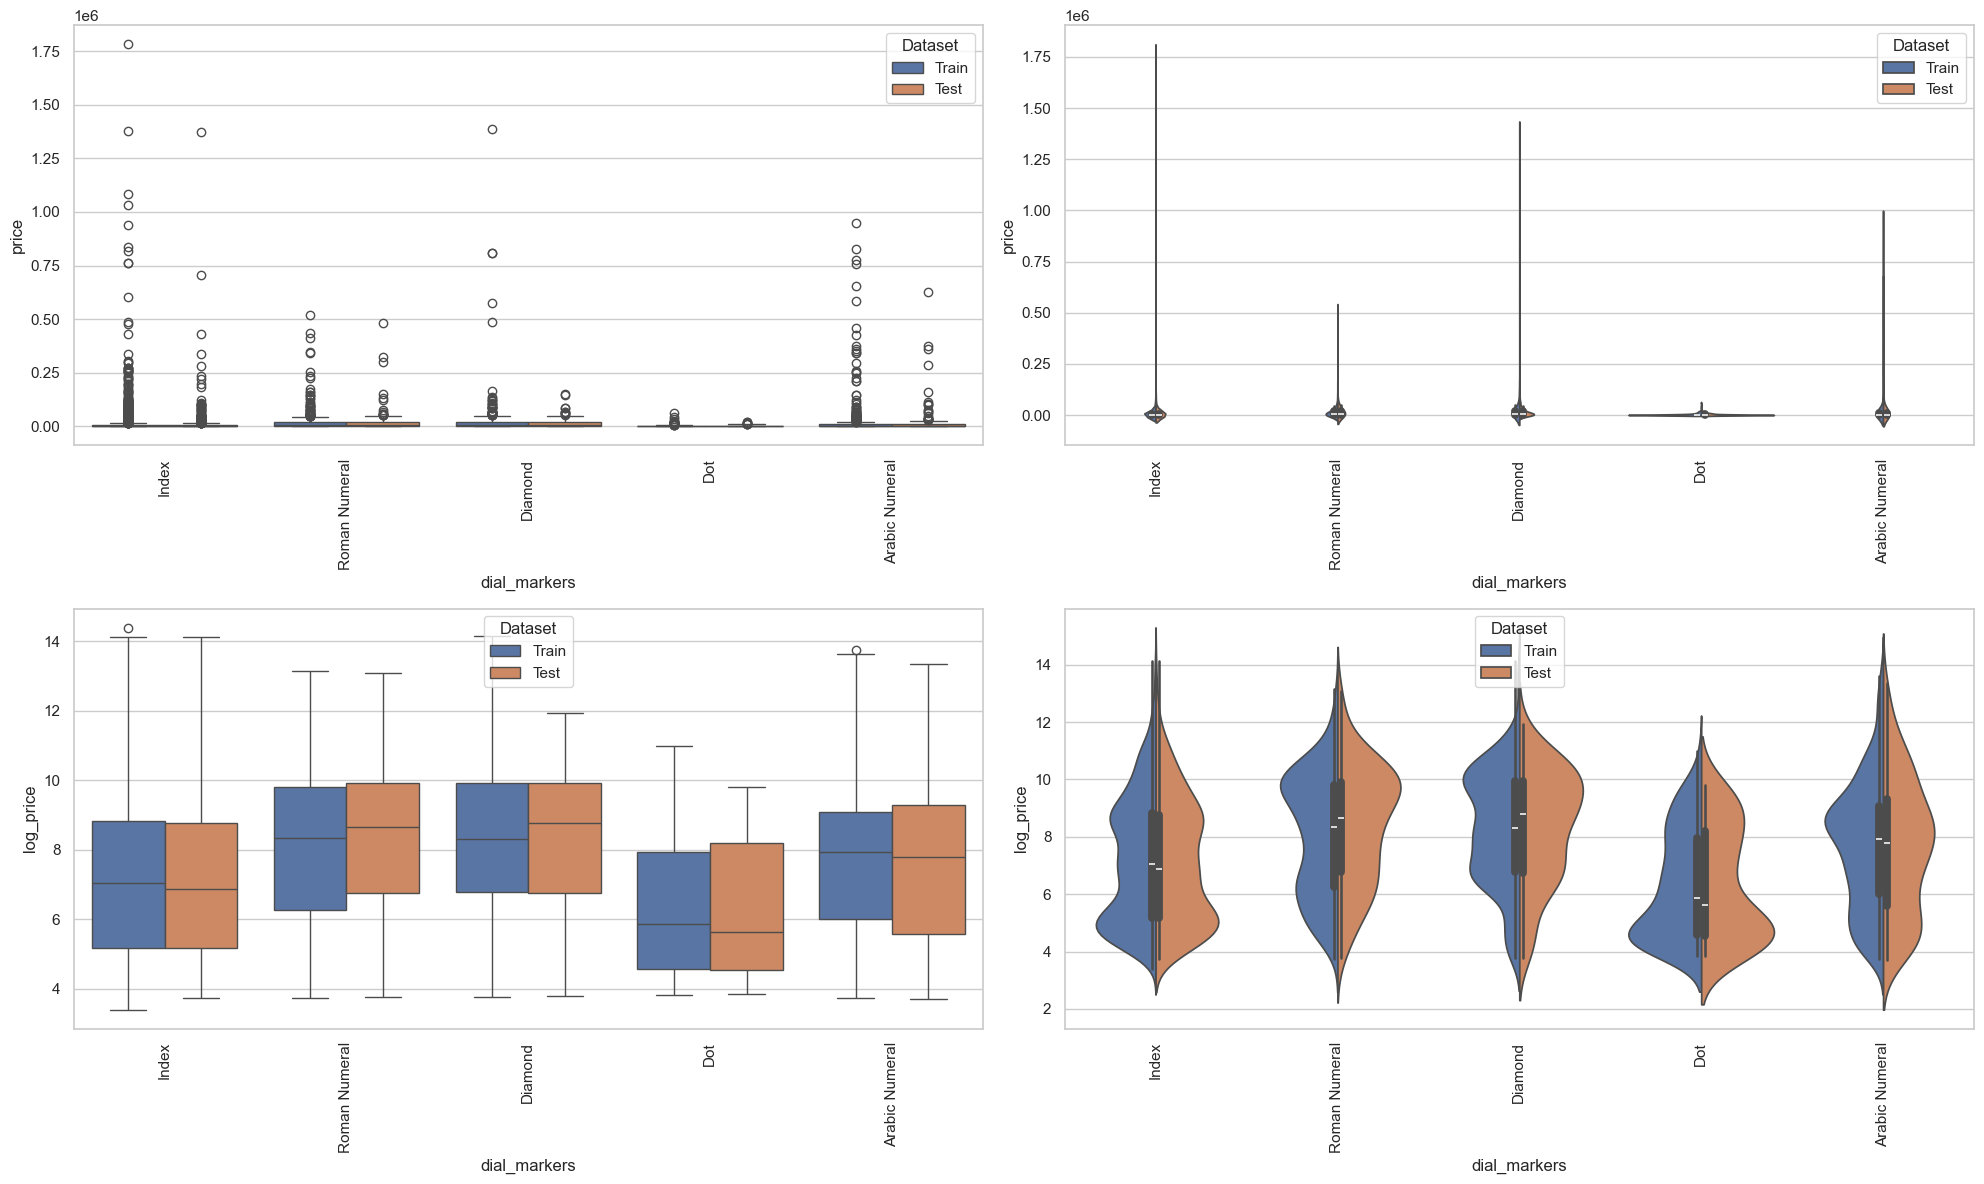

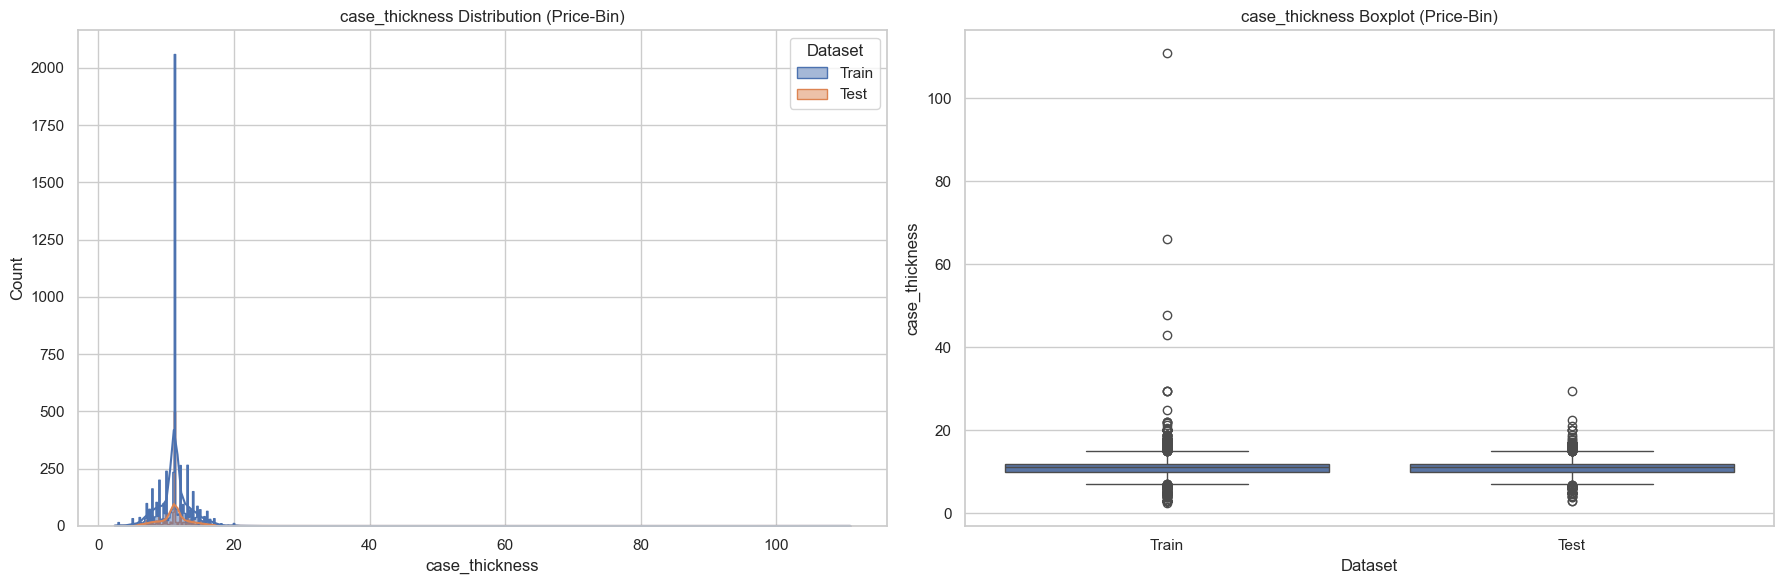

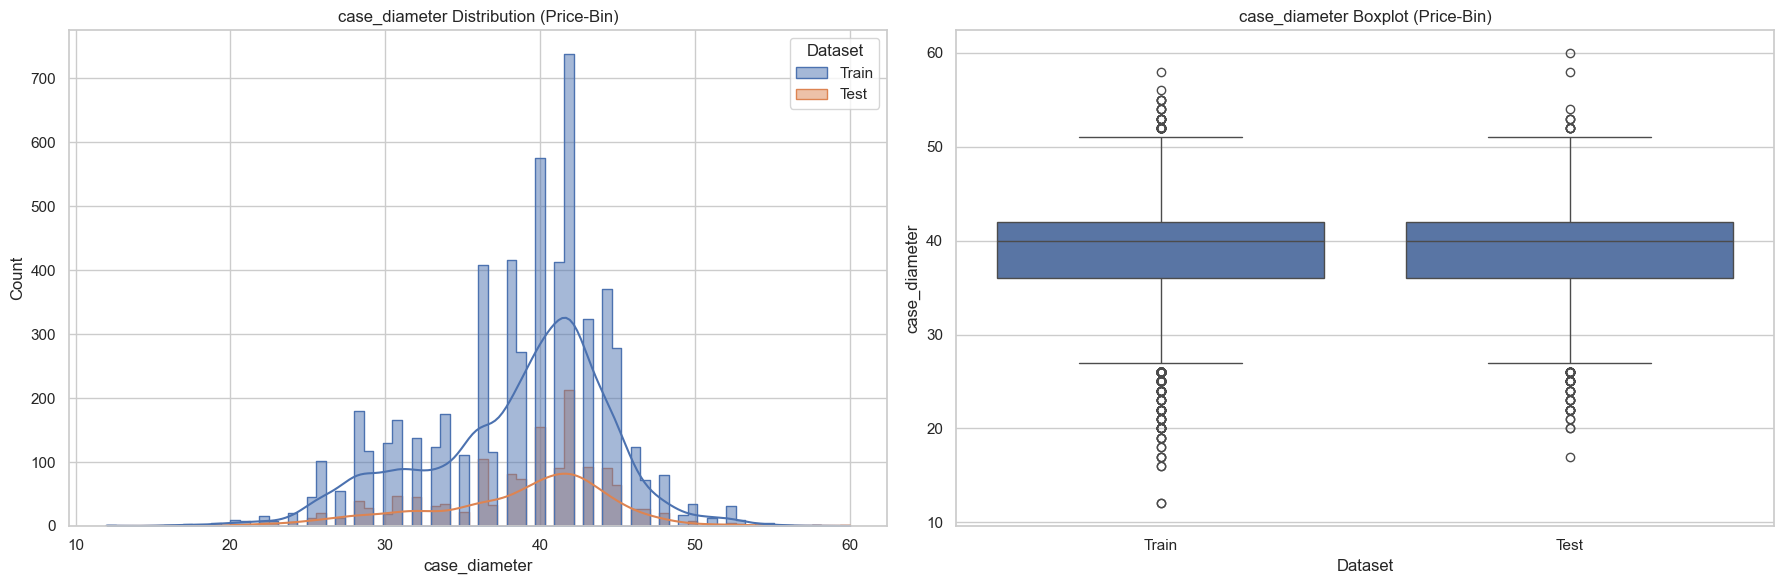

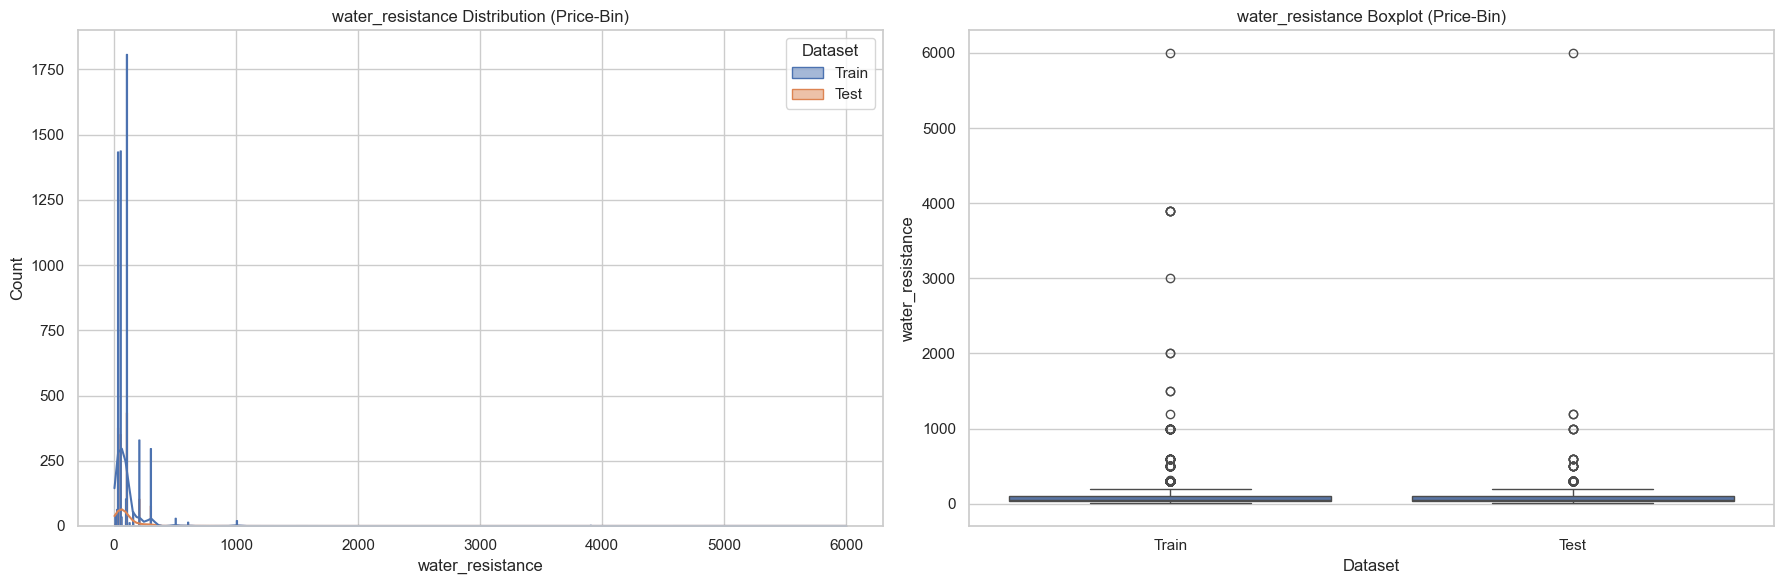

In [14]:
train_p = X_train_p.assign(price=y_train_p)
test_p  = X_test_p.assign(price=y_test_p)

# Overall price distribution
plot_price_distribution(y_train_p, y_test_p, title_suffix="(Price-Bin)")

# Categorical + price-by-cat
for col in cats:
    plot_cat_distribution_sns(train_p, test_p, col,
                              top_n=8, title_suffix="(Price-Bin)")
    plot_price_by_category   (train_p, test_p, col,
                              top_n=5, title_suffix="(Price-Bin)")

# Numerical distributions
for col in nums:
    plot_num_distribution_sns(train_p, test_p,
                              col, title_suffix="(Price-Bin)")


### 3.1.8 Visualize cho mỗi stratification categorical


In [ ]:
for strat_col, res in split_results_cat.items():
    print(f"\n=== Stratified by {strat_col} ===")
    X_tr, X_te = res['X_train'], res['X_test']
    y_tr, y_te = res['y_train'], res['y_test']
    tr = X_tr.assign(price=y_tr); te = X_te.assign(price=y_te)

    # Giá chung
    plot_price_distribution(y_tr, y_te,
                            title_suffix=f"(by {strat_col})")

    # Phân phối chính strat_col
    plot_cat_distribution_sns(tr, te, strat_col,
                              top_n=8, title_suffix=f"(by {strat_col})")
    plot_price_by_category   (tr, te, strat_col,
                              top_n=5, title_suffix=f"(by {strat_col})")

    # Các cat còn lại & nums
    for col in [c for c in cats if c != strat_col]:
        plot_cat_distribution_sns(tr, te, col,
                                  top_n=8, title_suffix=f"(by {strat_col})")
        plot_price_by_category   (tr, te, col,
                                  top_n=5, title_suffix=f"(by {strat_col})")
    for col in nums:
        plot_num_distribution_sns(tr, te,
                                  col, title_suffix=f"(by {strat_col})")
    print(f"End of stratification by {strat_col}\n" + "="*50 + "\n")

## 3.2. Train/test split by price-bin stratification


### 3.2.1. Train/teet split by price-bin stratification Visualization


Implementation of the train/test split by price-bin stratification 75/25, and handle unseen categories in the test set. The train/test split is visualized to show the distribution of price bins in both sets.


Number of price bins: 30
Number of rare price bins: 0
Samples in rare bins: 0 (0.00%)
Samples in common bins: 7141 (100.00%)

Checking for unseen categories in test set before fixing:
  case_material: 28 unseen values in test: {'Polished 18kt Magic Gold', '18kt White Gold Ceramic', 'Ti-Ceramitech', 'Zicronium', 'Polished 18kt Yellow Gold', 'Titanium and Ceramic', 'Stainless Steel (Tripartite)', 'Stainless steel set with diamonds', 'Stainless Steel set with crystals', 'Polished and Satin-finished Titanium', 'Stainless Steel and 18kt Sedna Gold', 'Composite Metsal', '(Bio-Based) Polyamide', 'High-tech Ceramic', 'Satin-finished Stainless Steel', '(Satin-finished) Titanium', 'Diamond Set 18kt Yellow Gold', 'Stainless Steel & Platinum', 'Polished and Satin-finished Ceramic', 'Satin-Polished Stainless Steel', '18kt Yellow Gold Case with Diamonds', '18ct Everose Gold', 'Everose Gold', '(Satin-finished) Ceramic', 'Sedna gold', '18 kt Everose gold', 'Polished and Microblasted Yellow Neon Saxem'

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\676571649.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=sizes, palette='viridis')


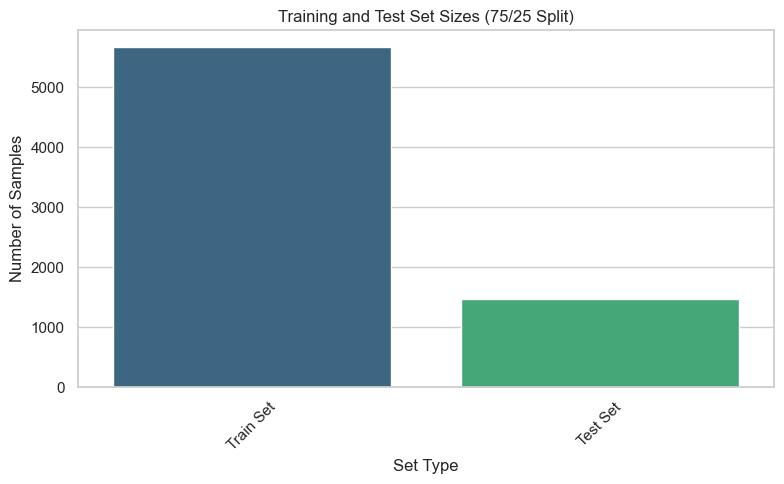

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


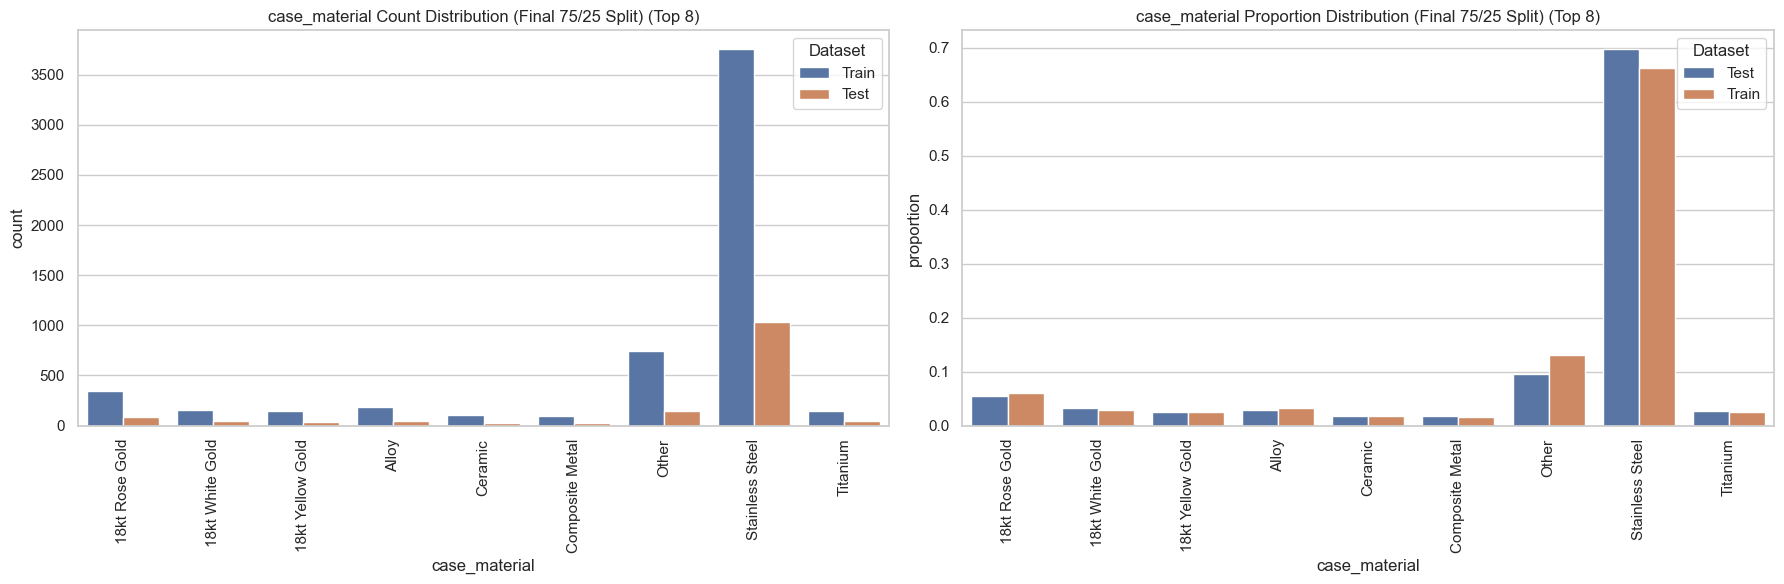

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['Dataset'] = 'Train'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].se

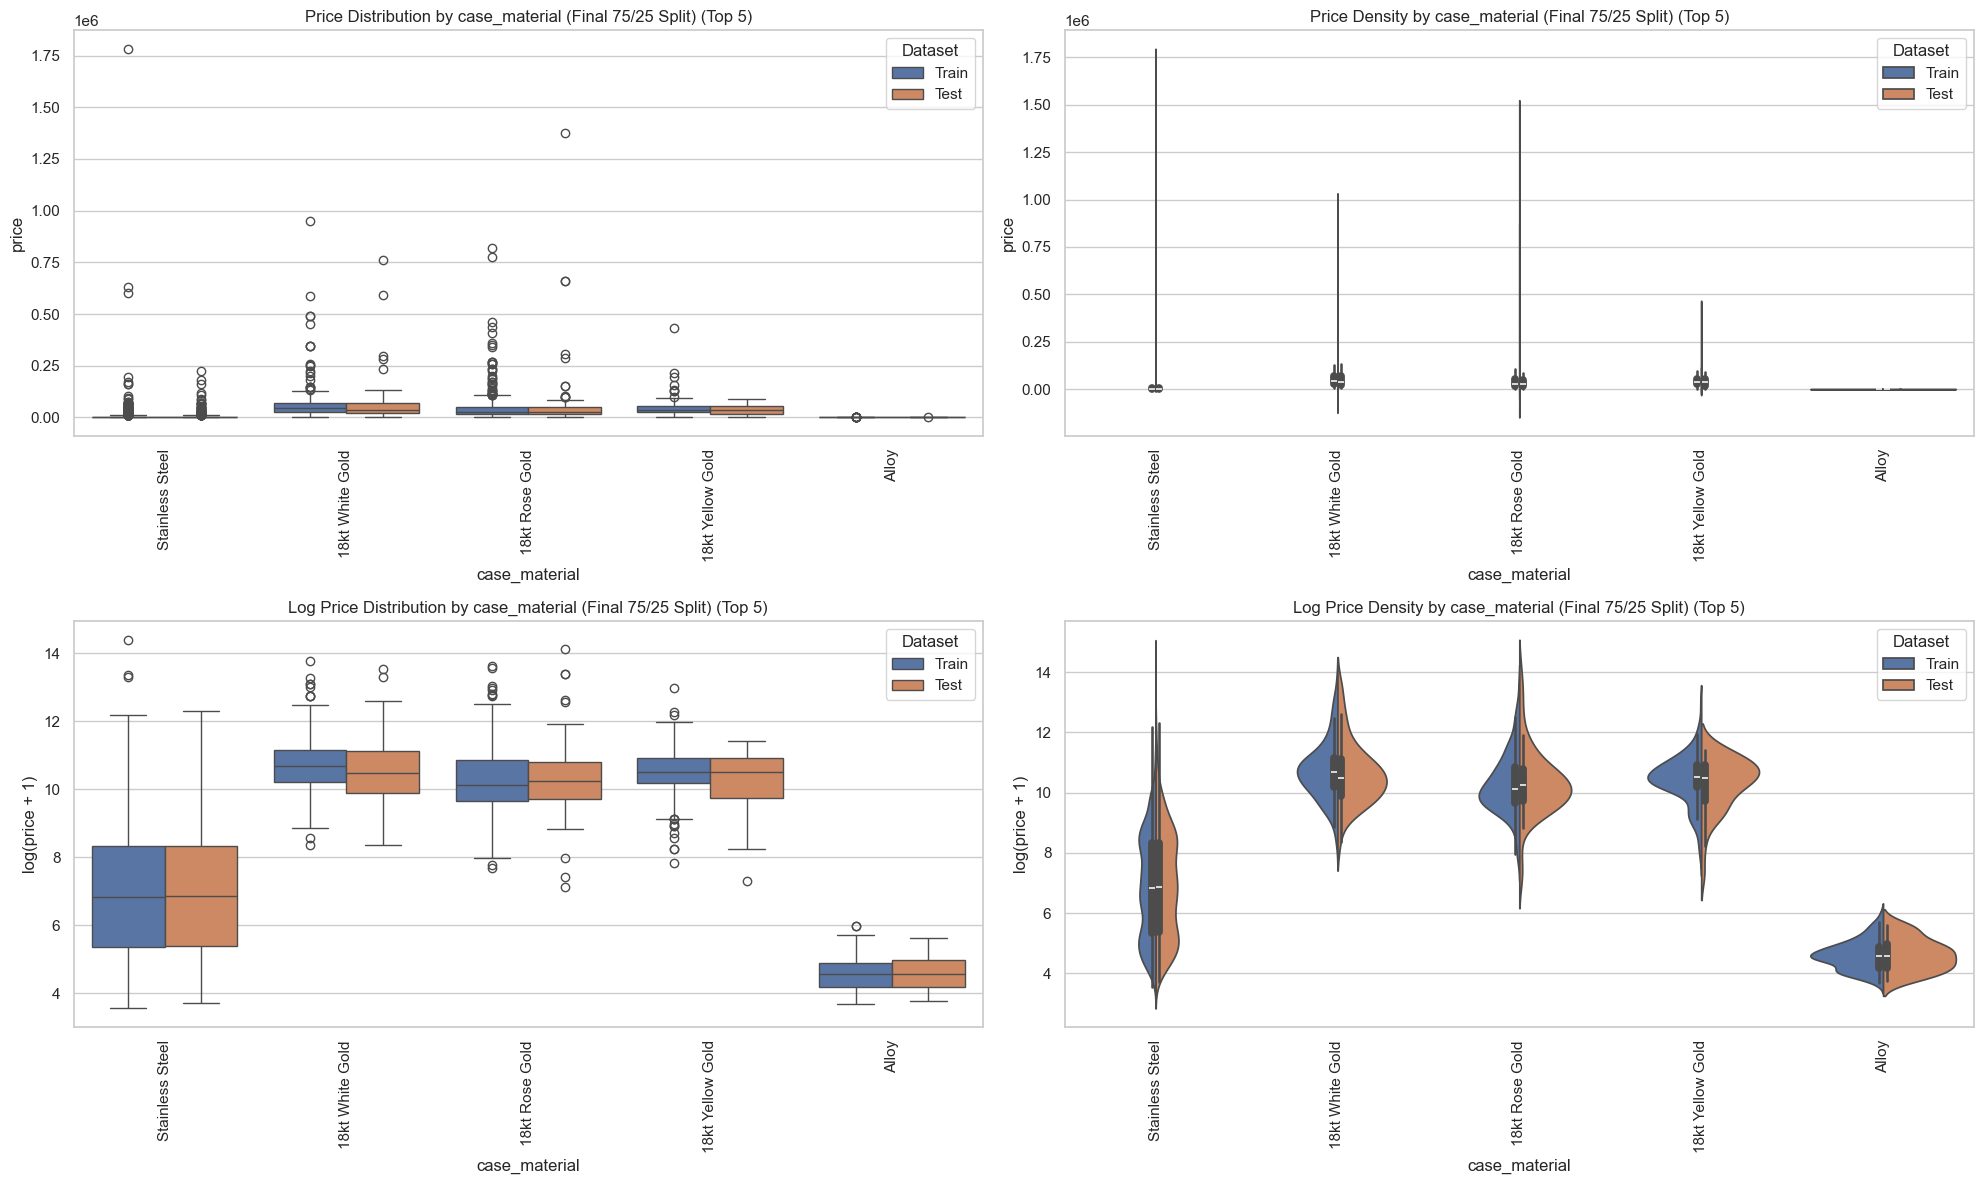

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


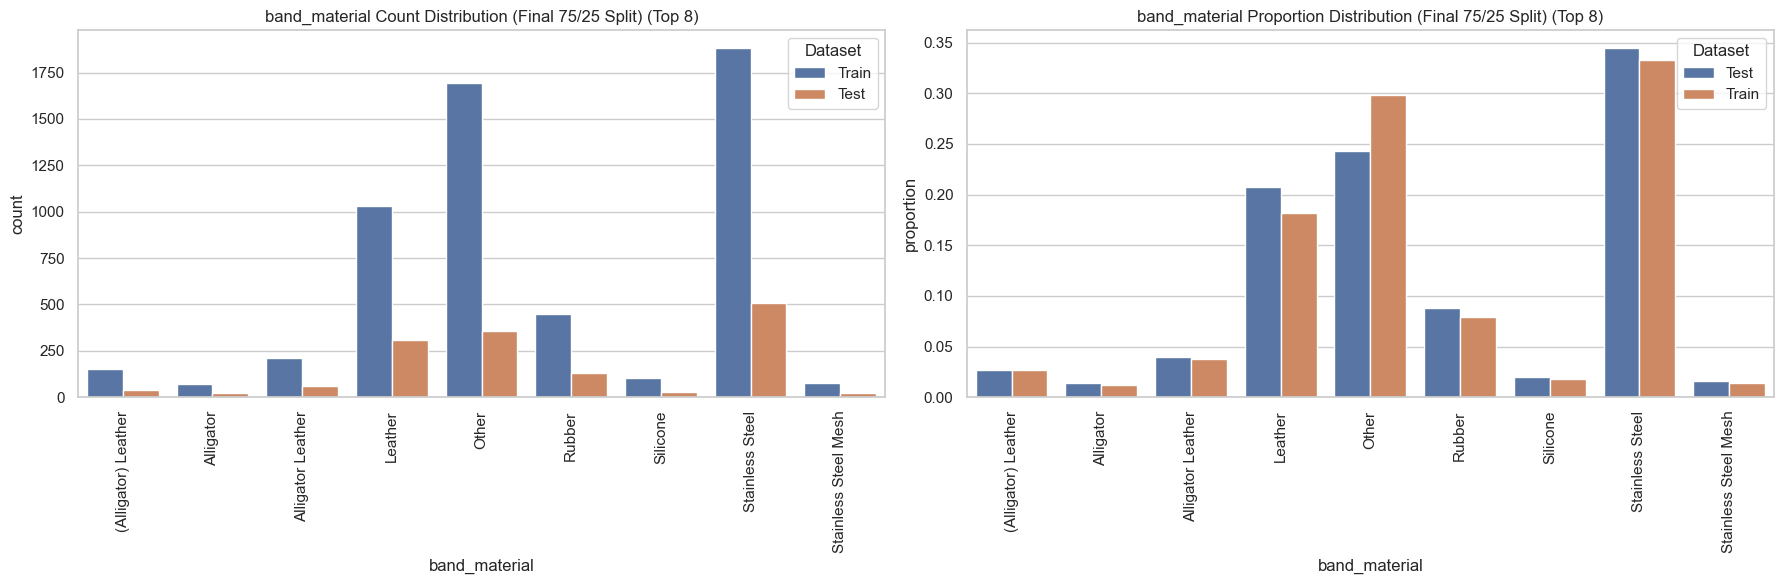

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['Dataset'] = 'Train'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].se

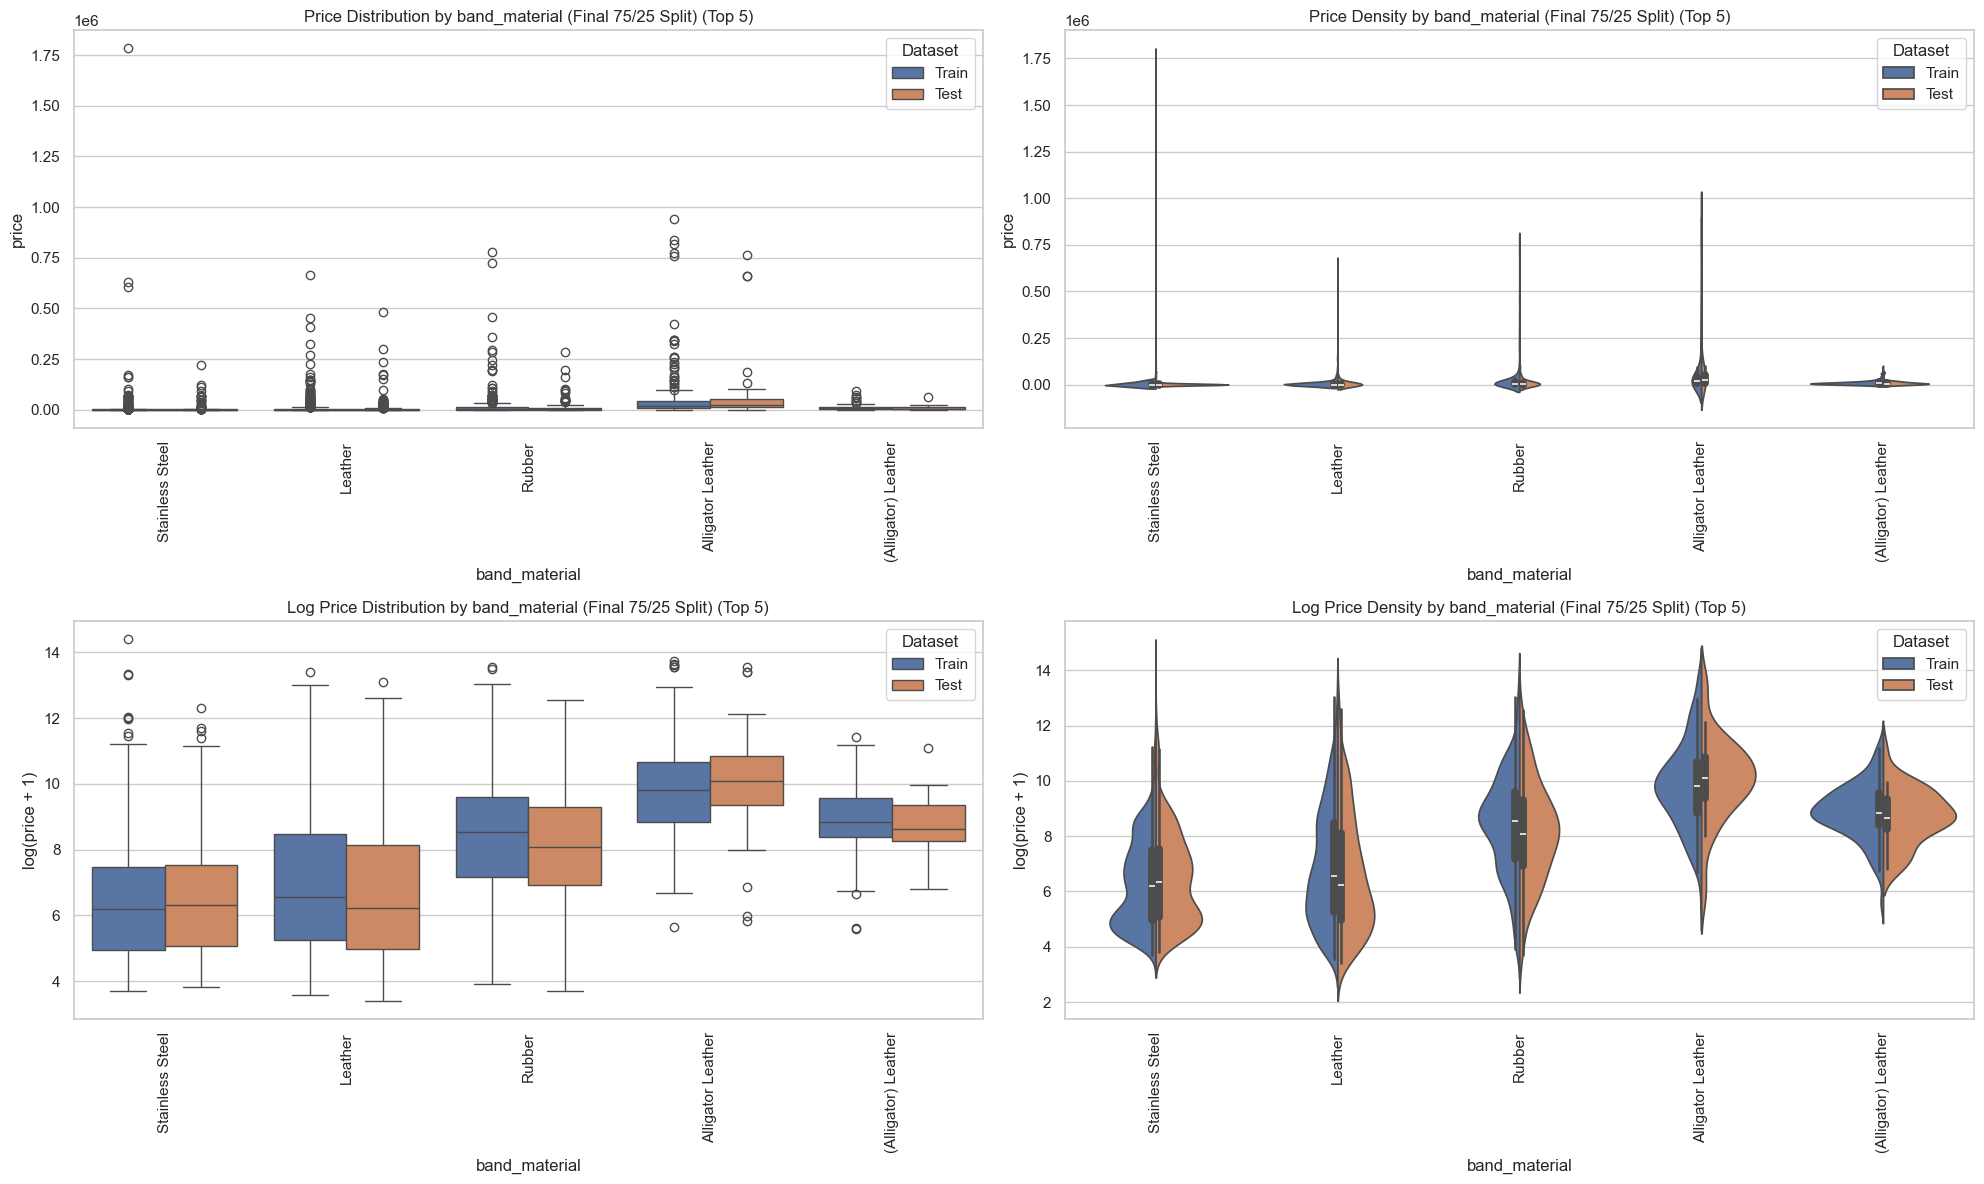

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


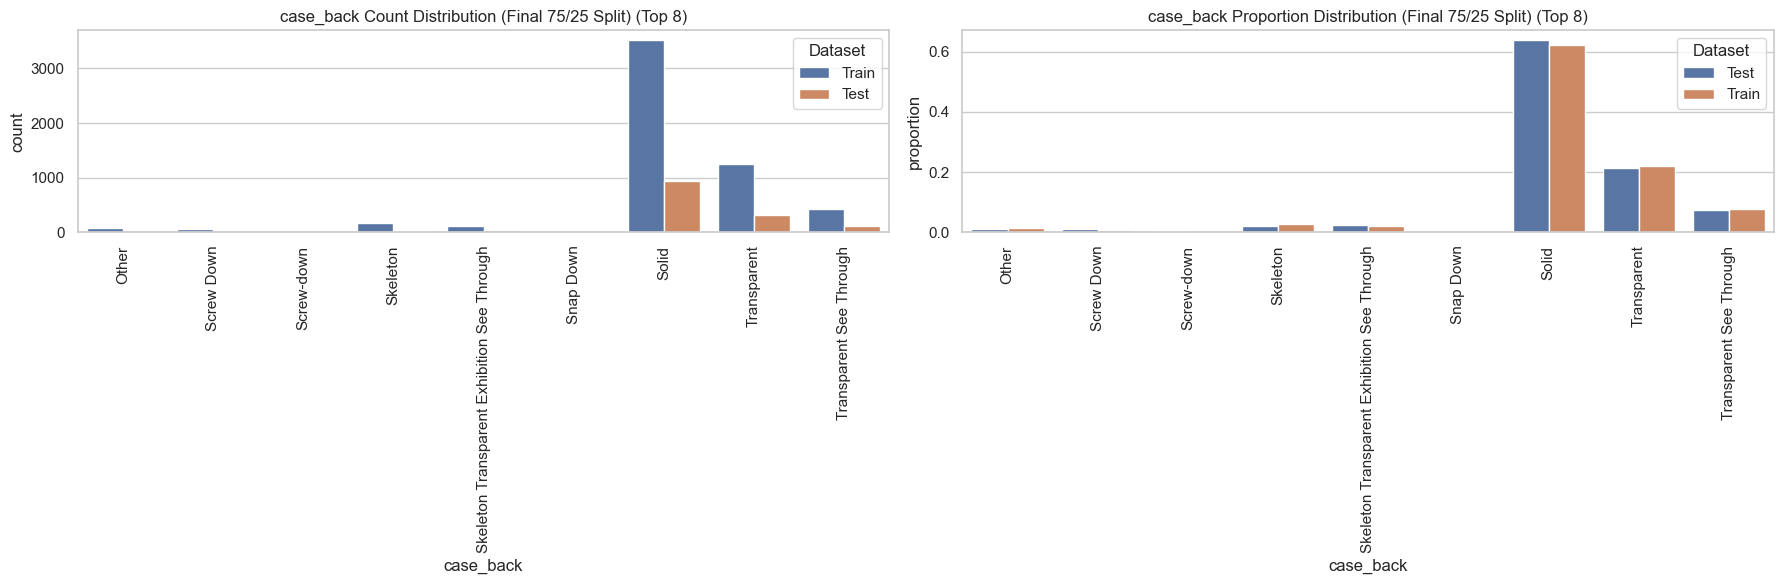

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['Dataset'] = 'Train'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].se

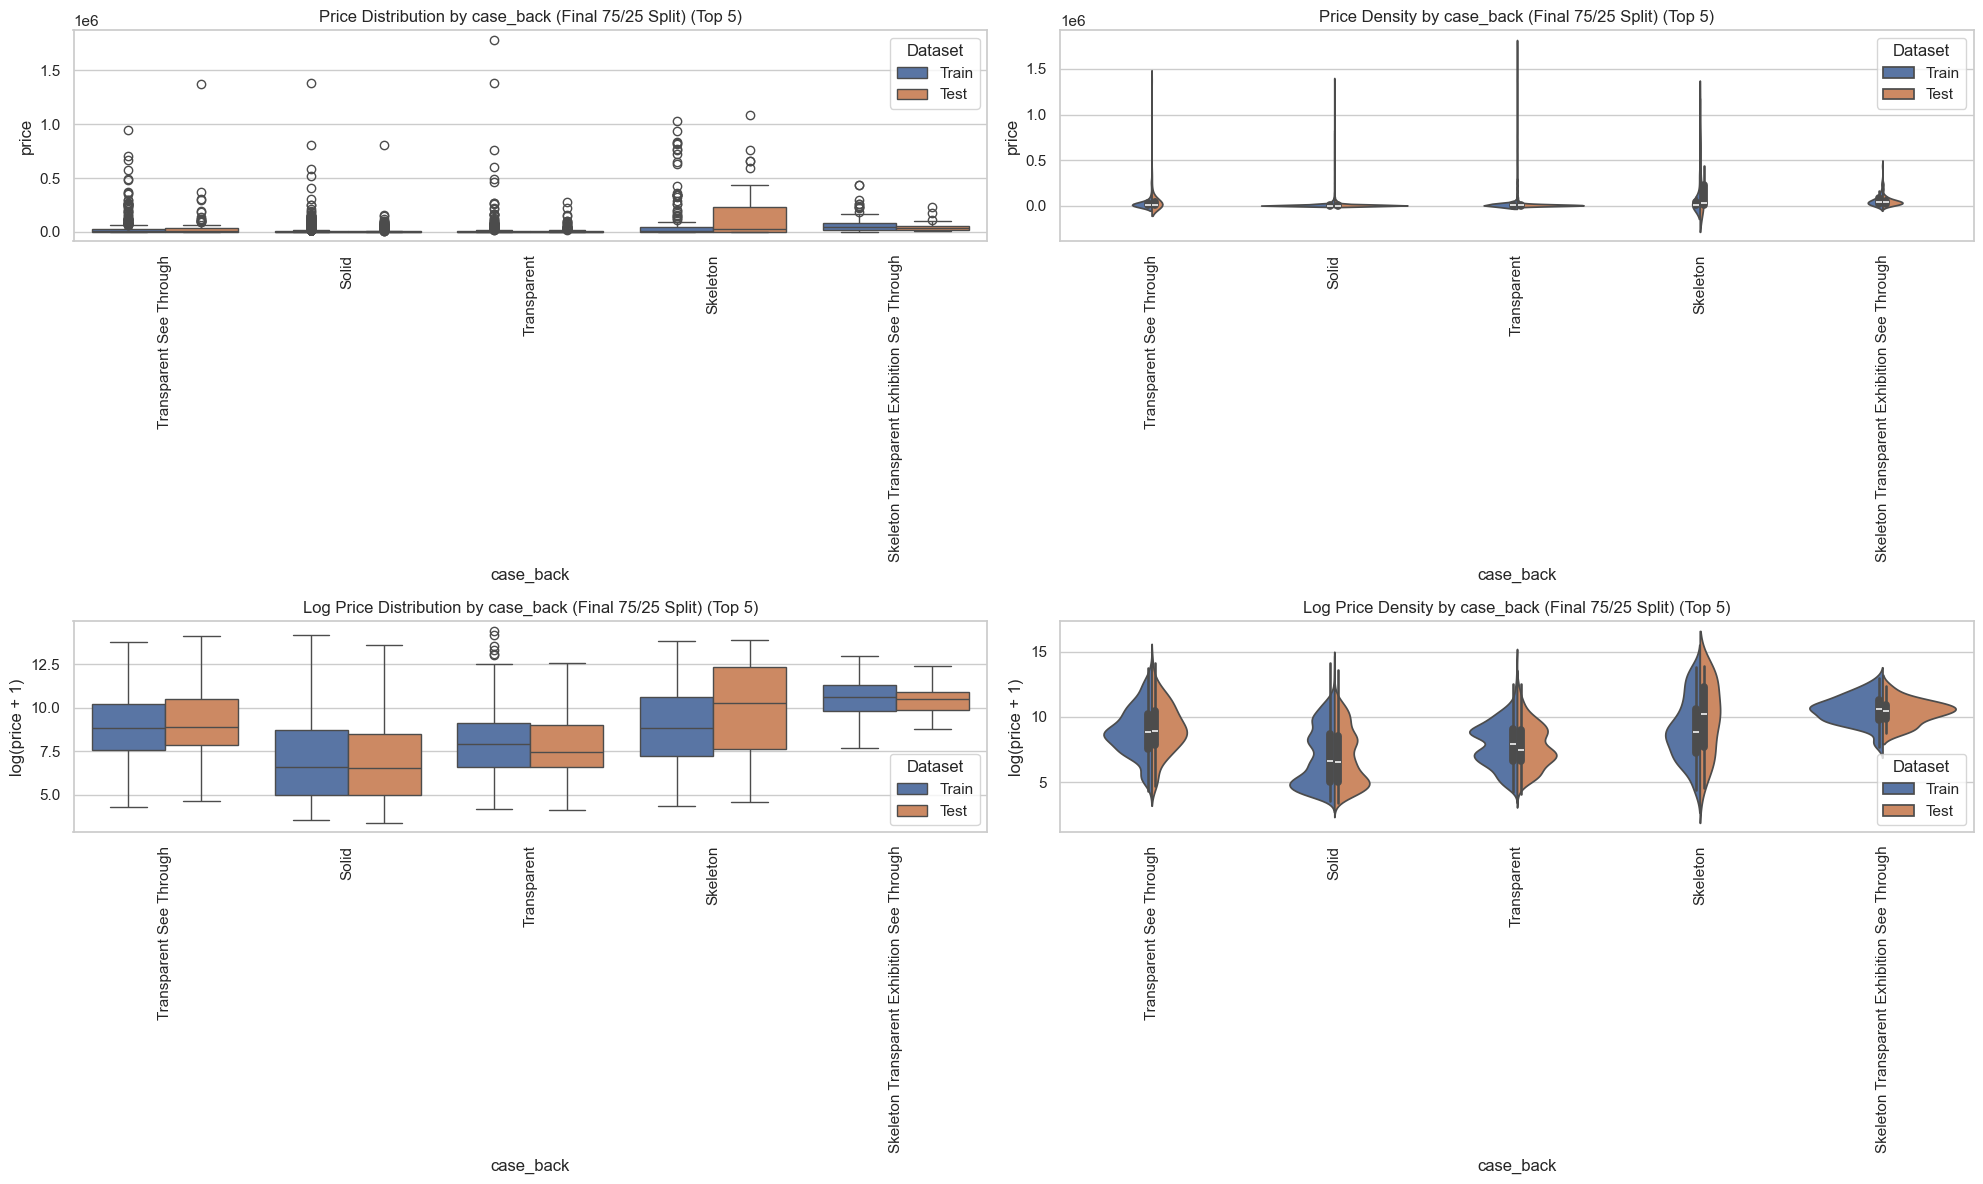

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


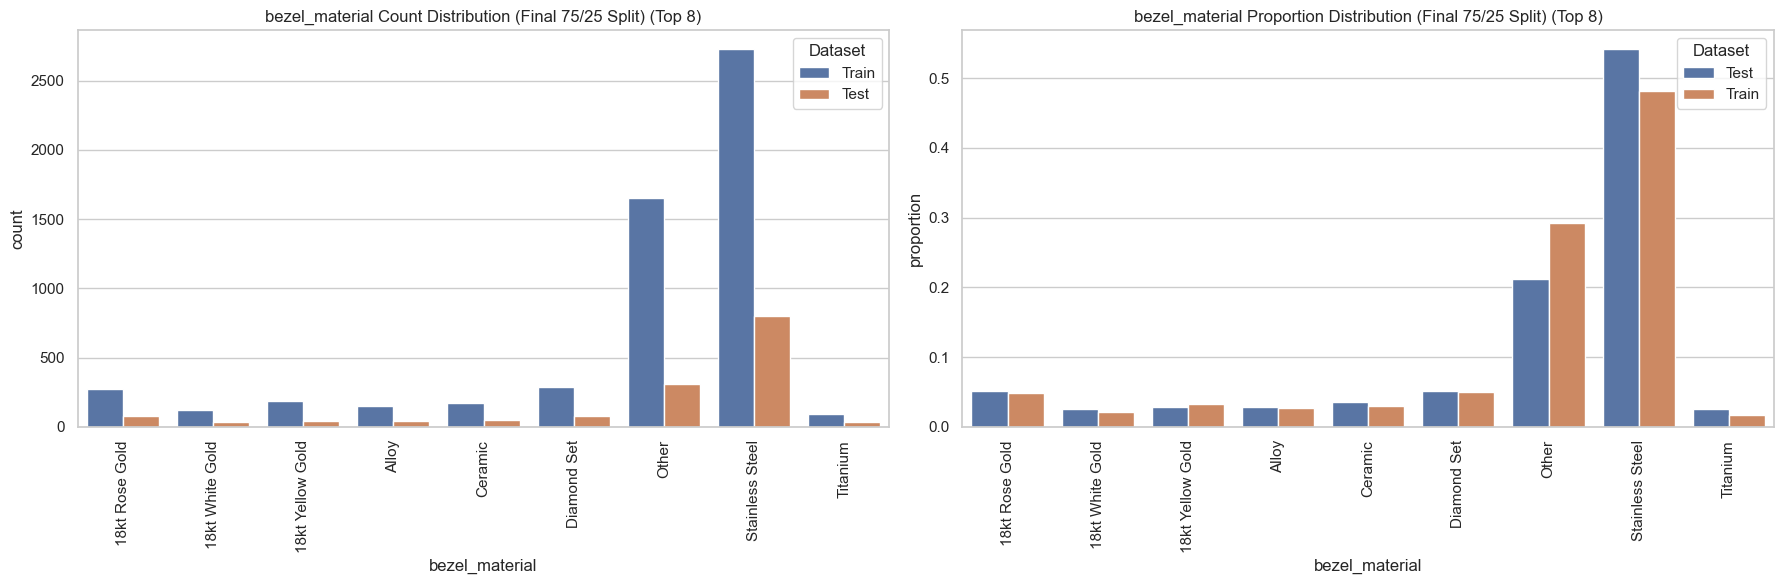

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['Dataset'] = 'Train'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].se

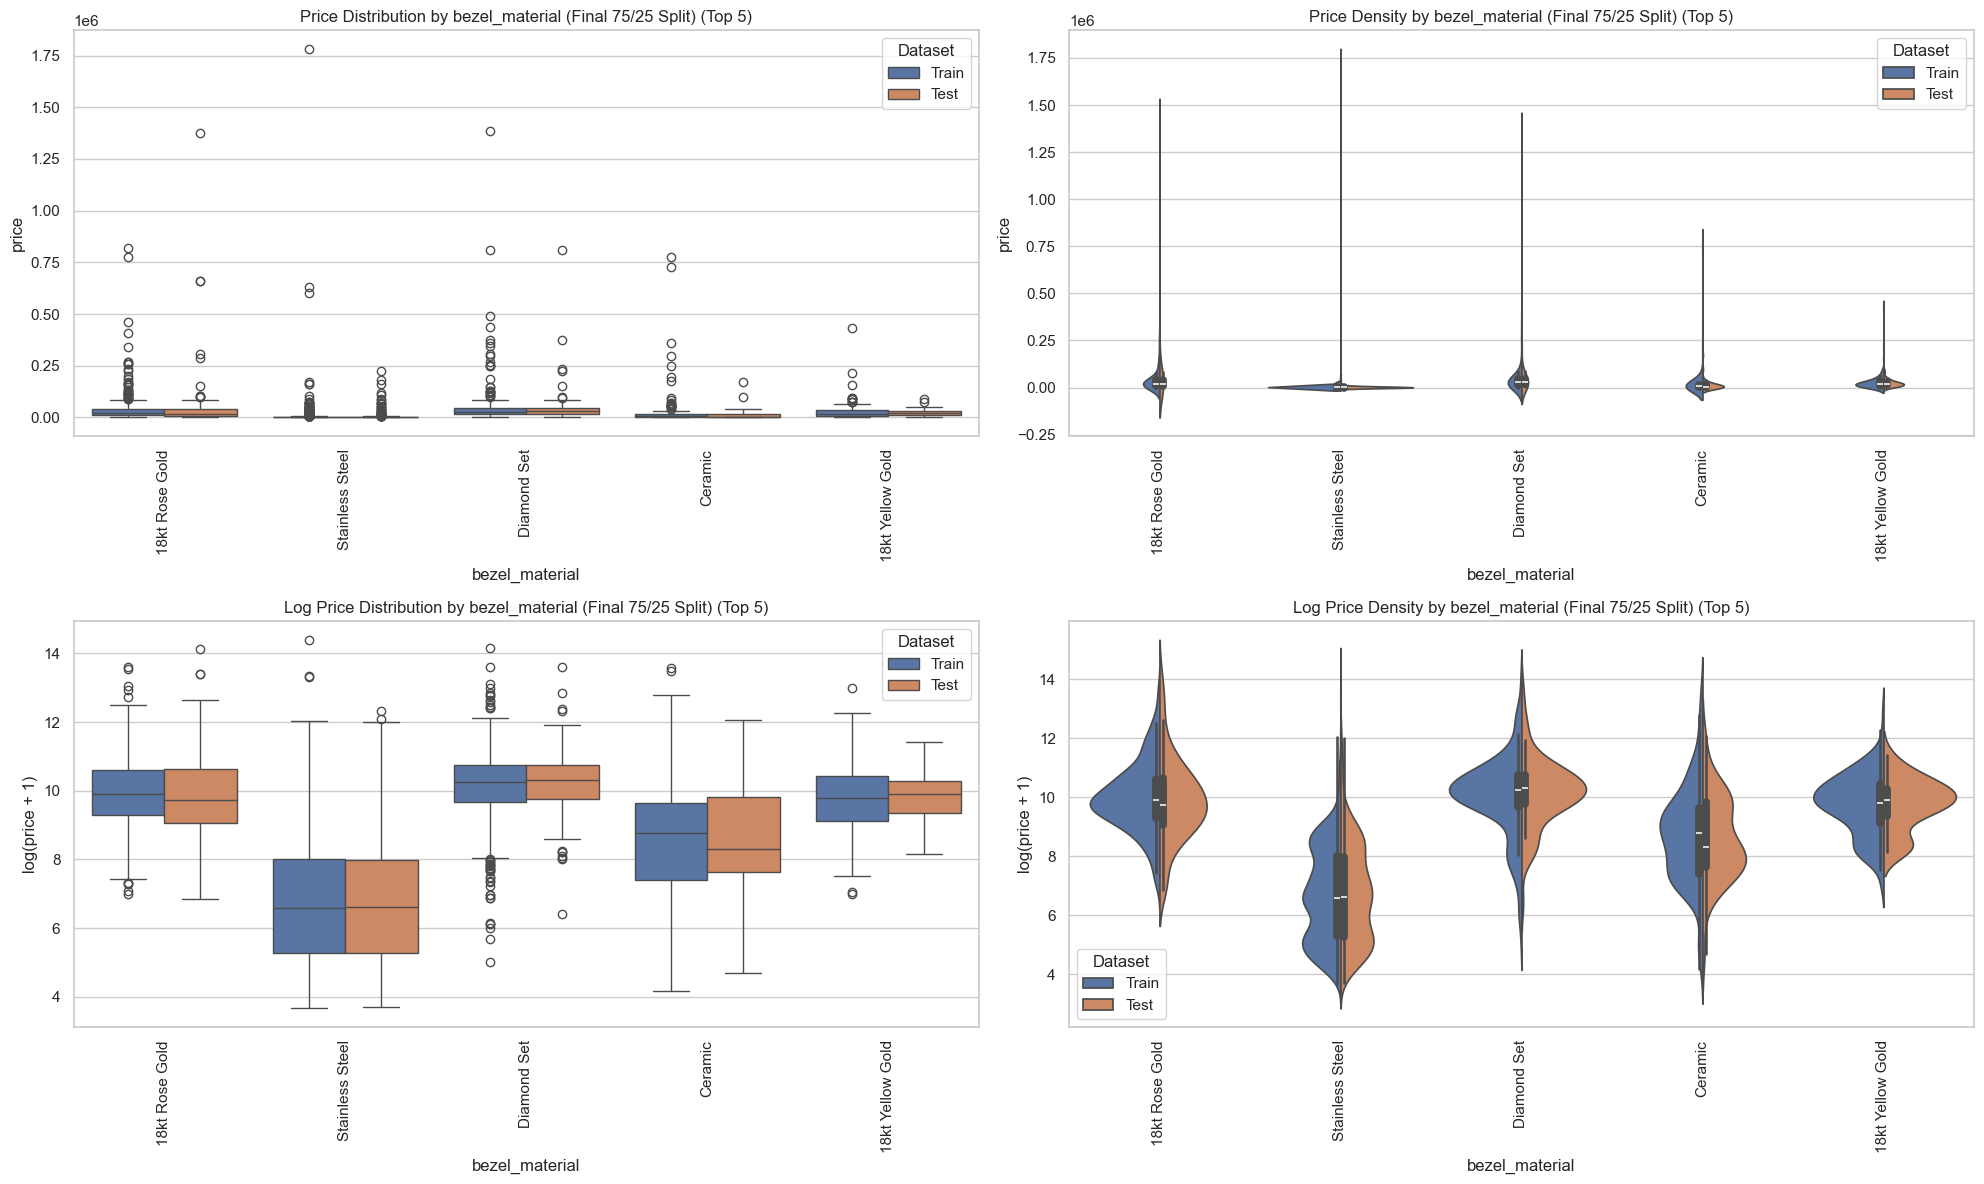

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


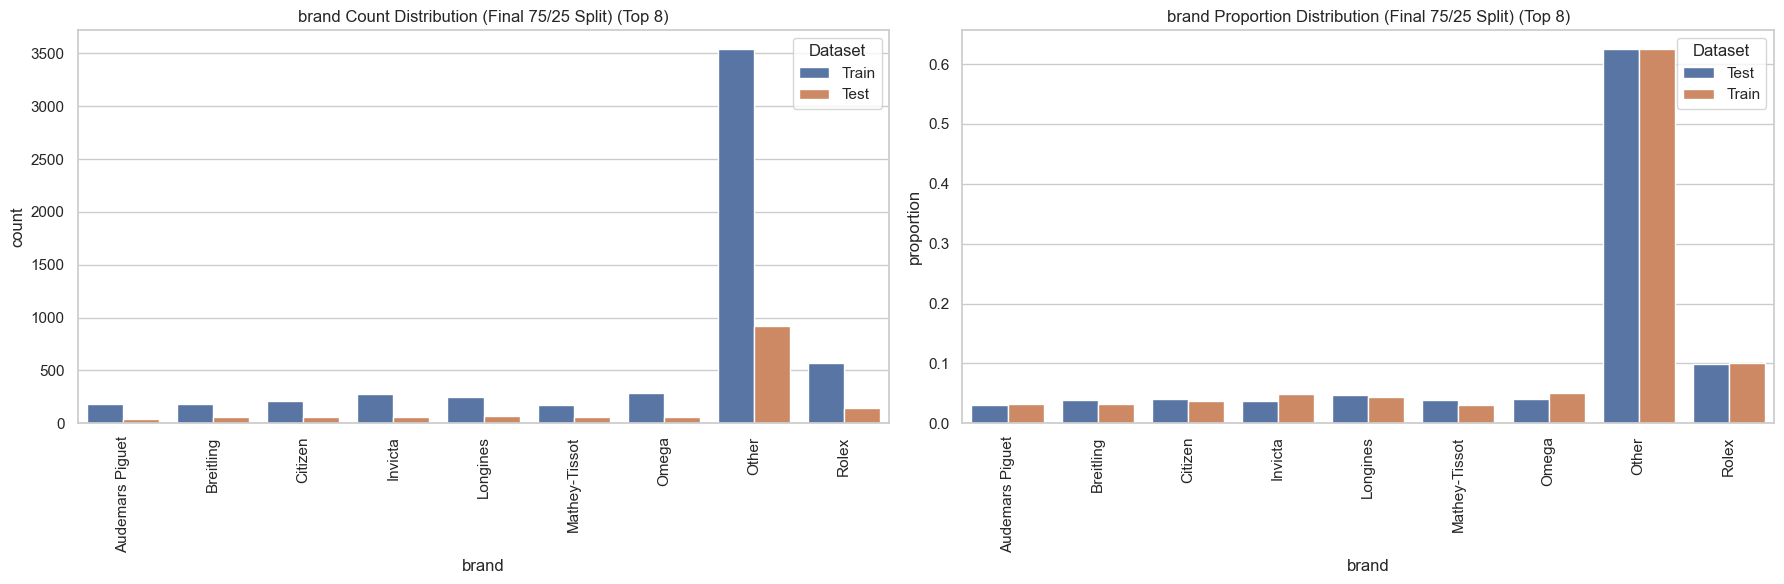

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['Dataset'] = 'Train'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].se

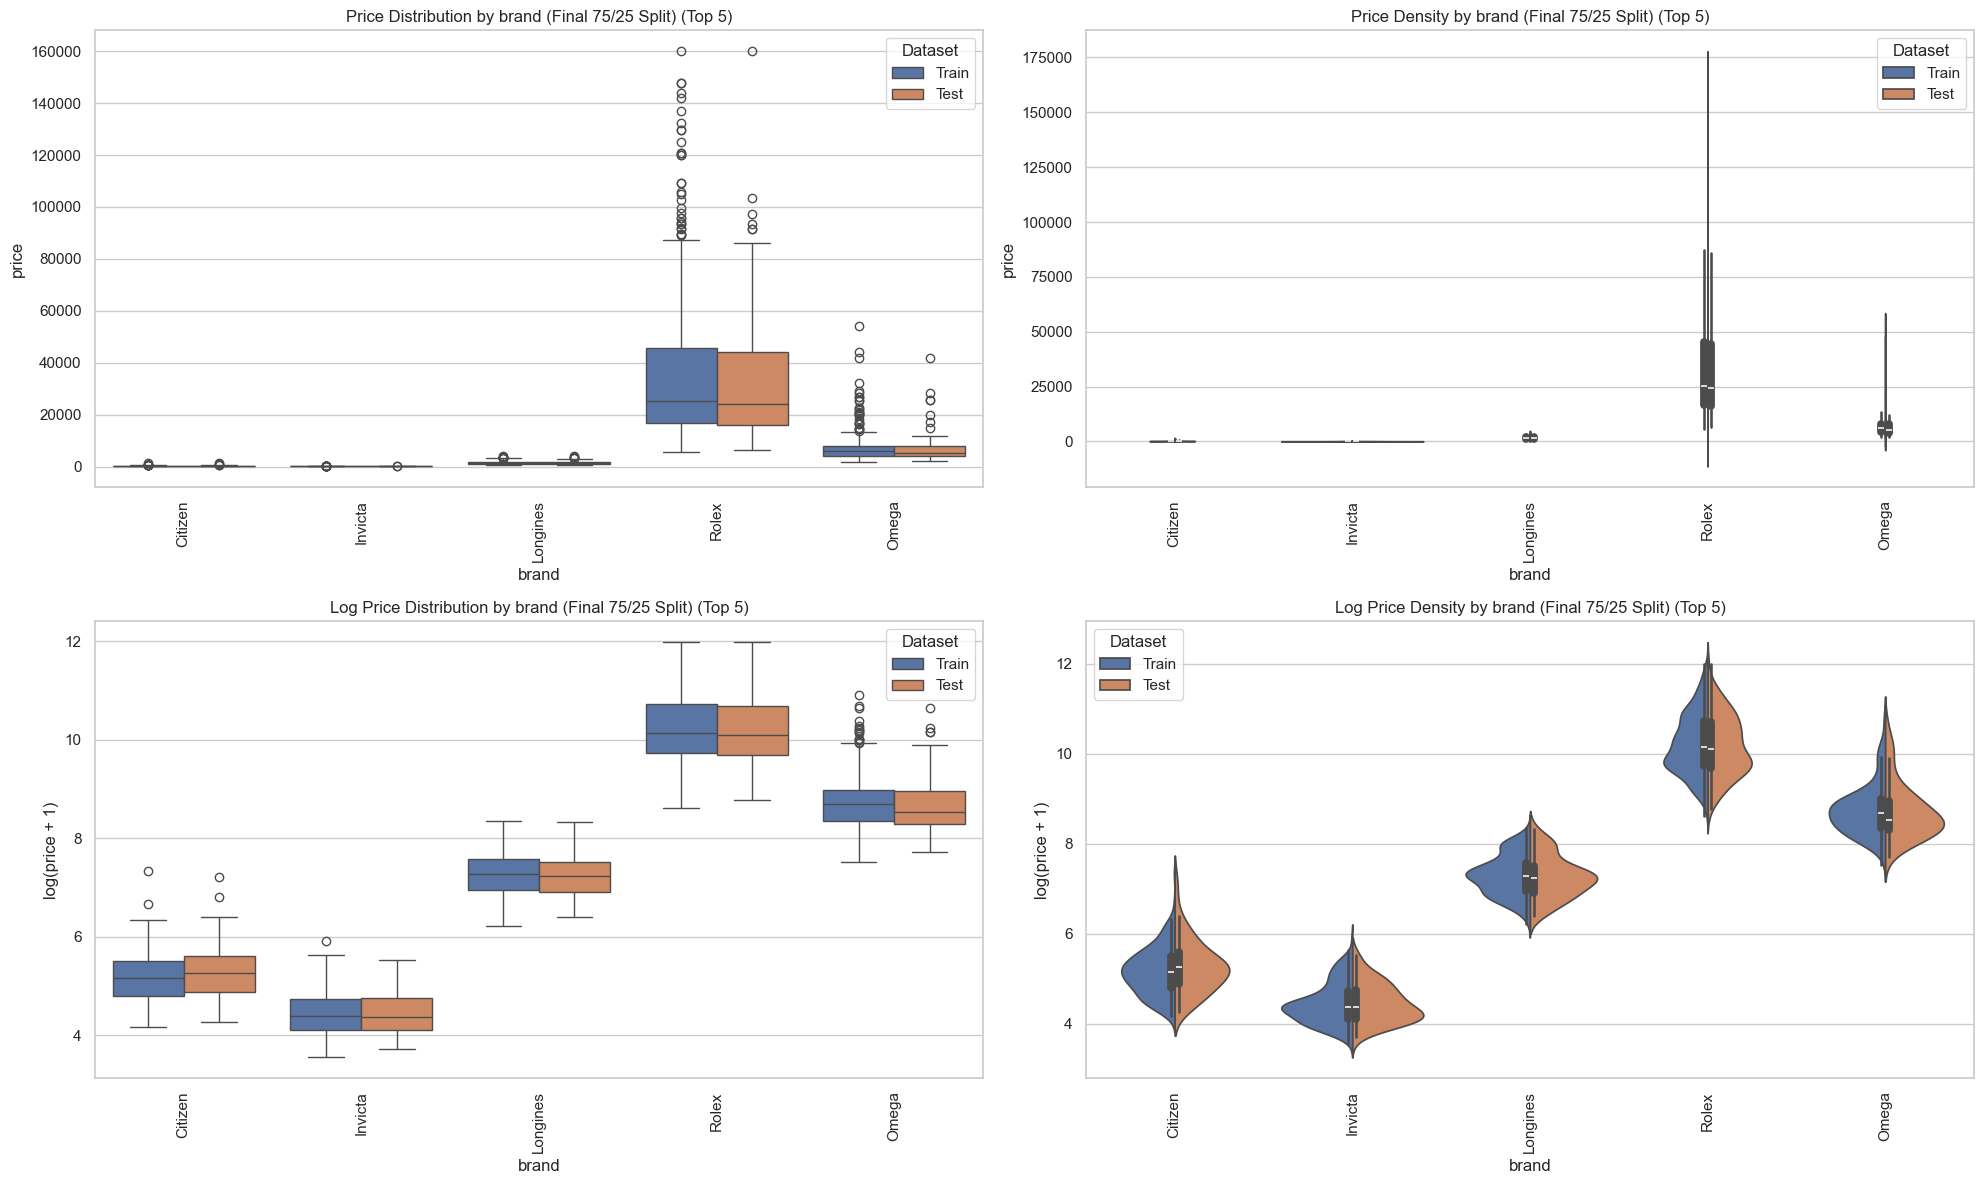

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


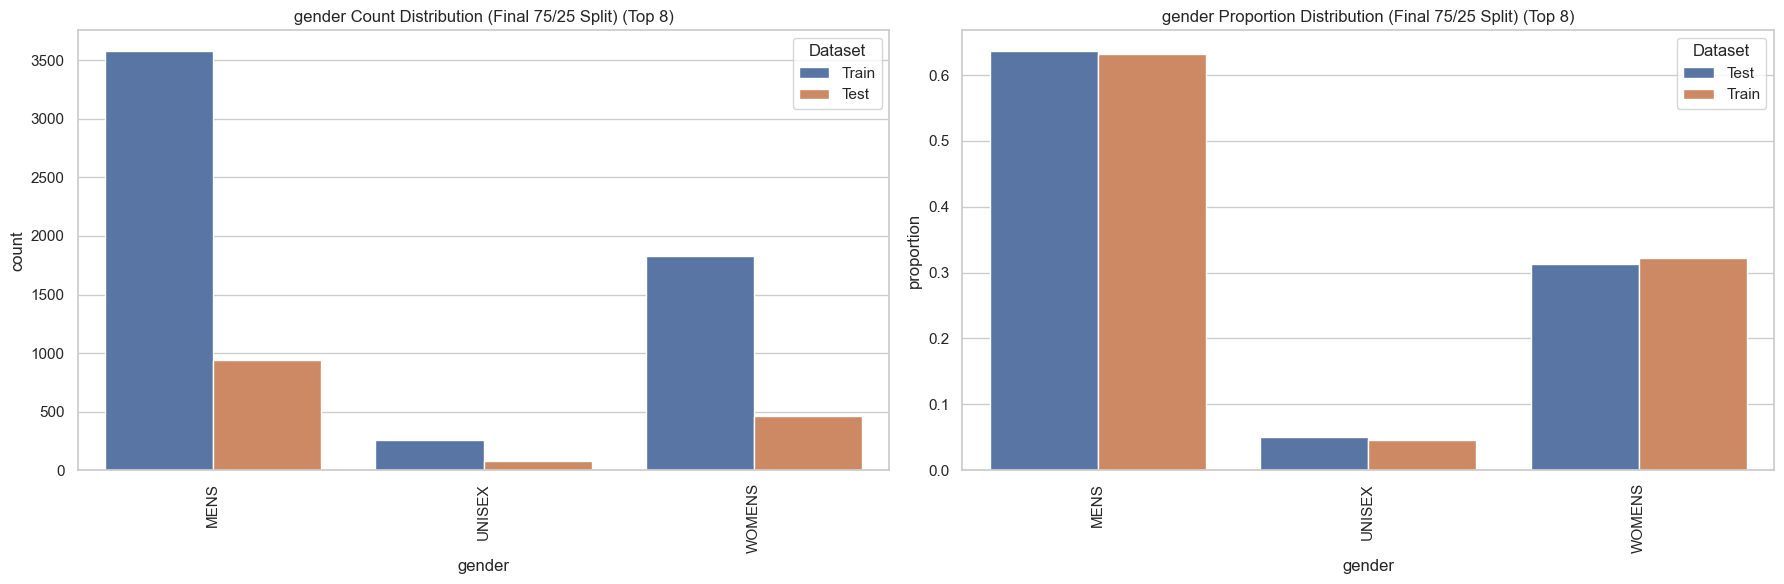

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocat

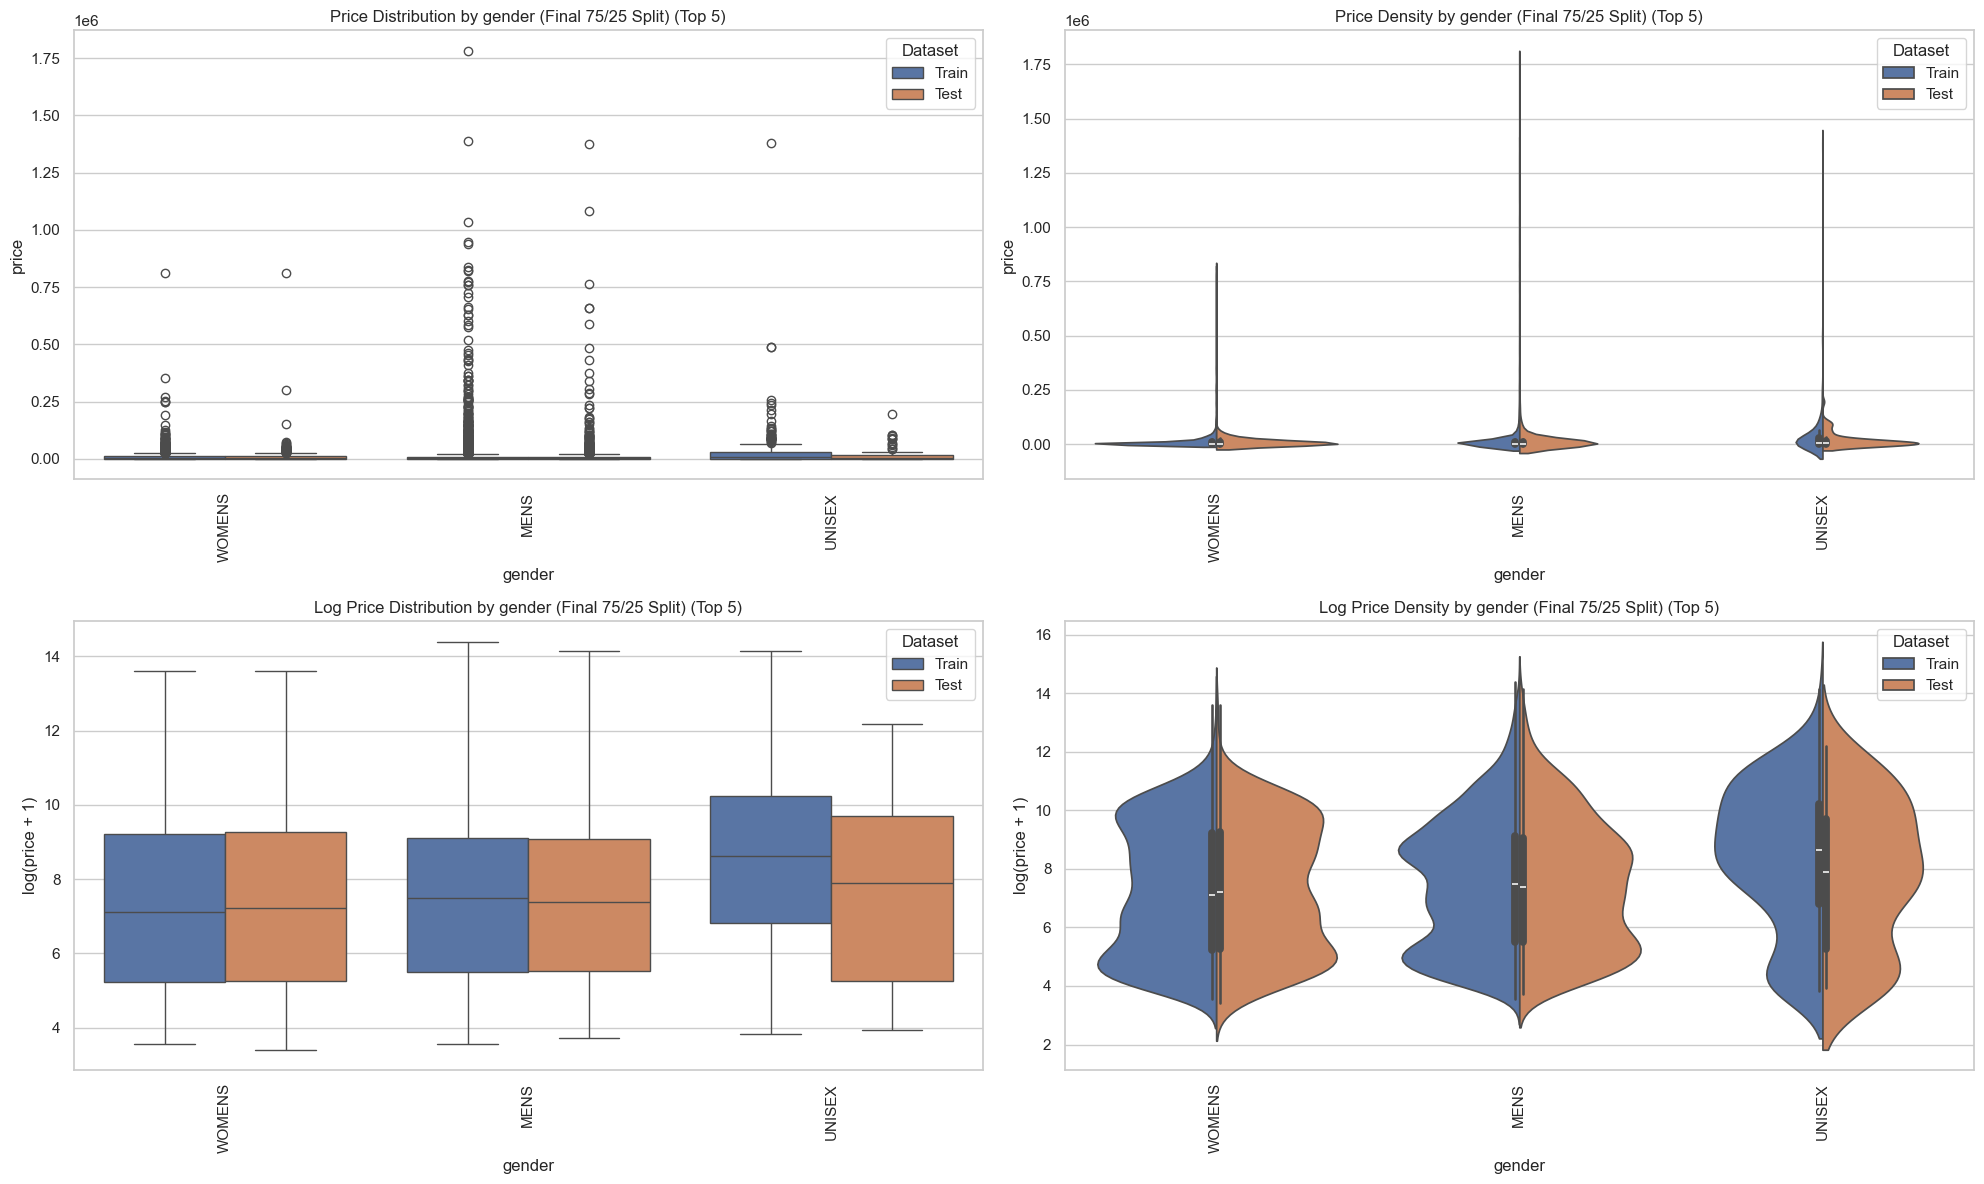

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


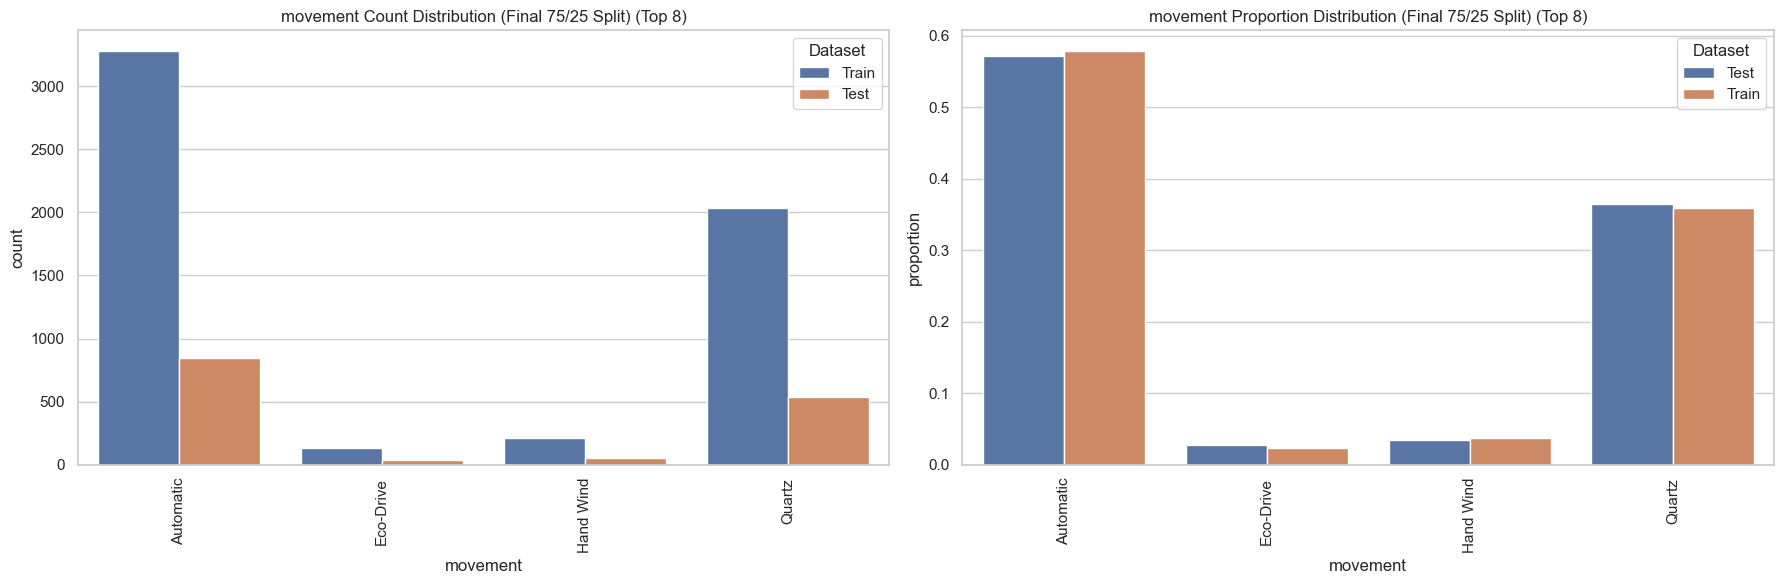

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocat

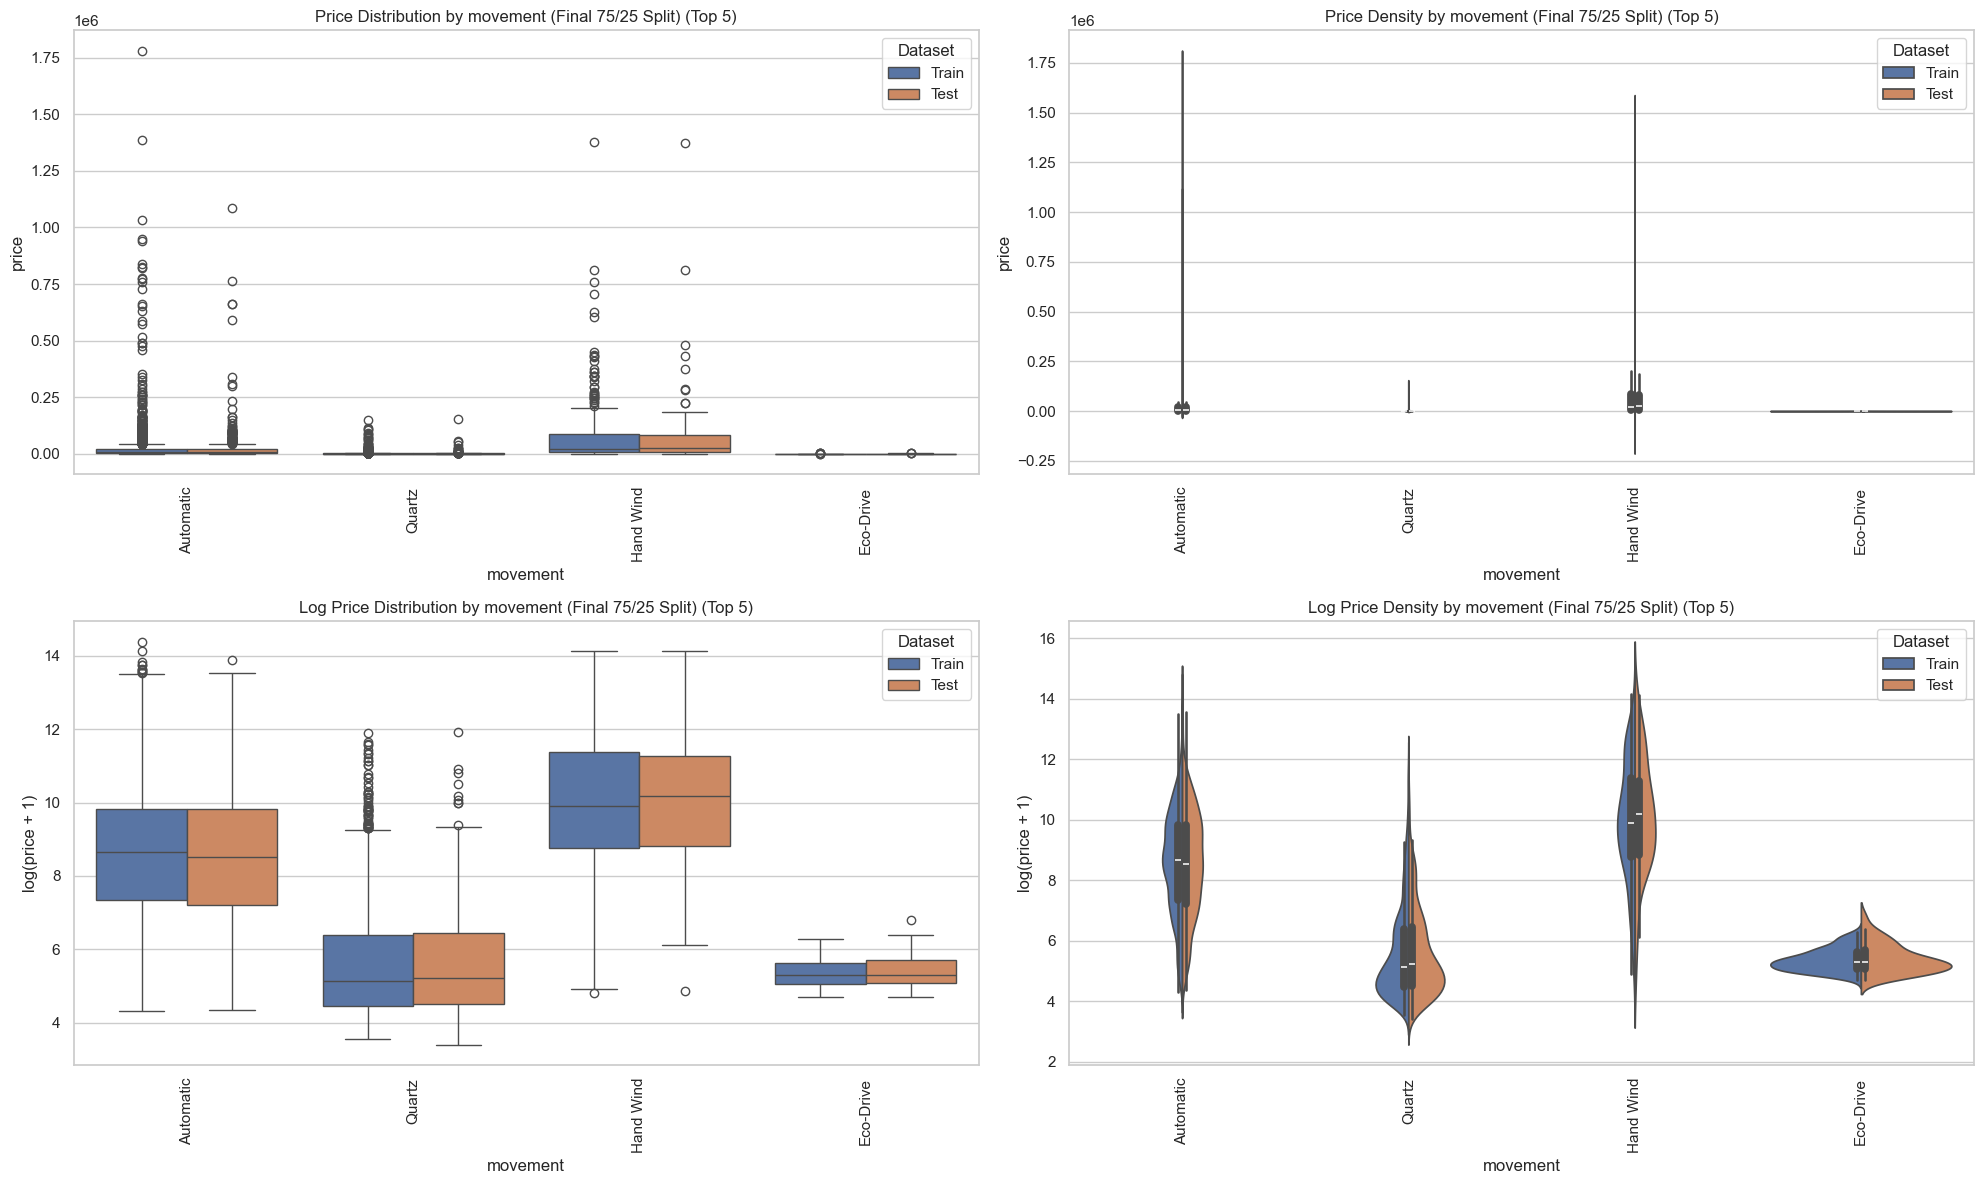

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


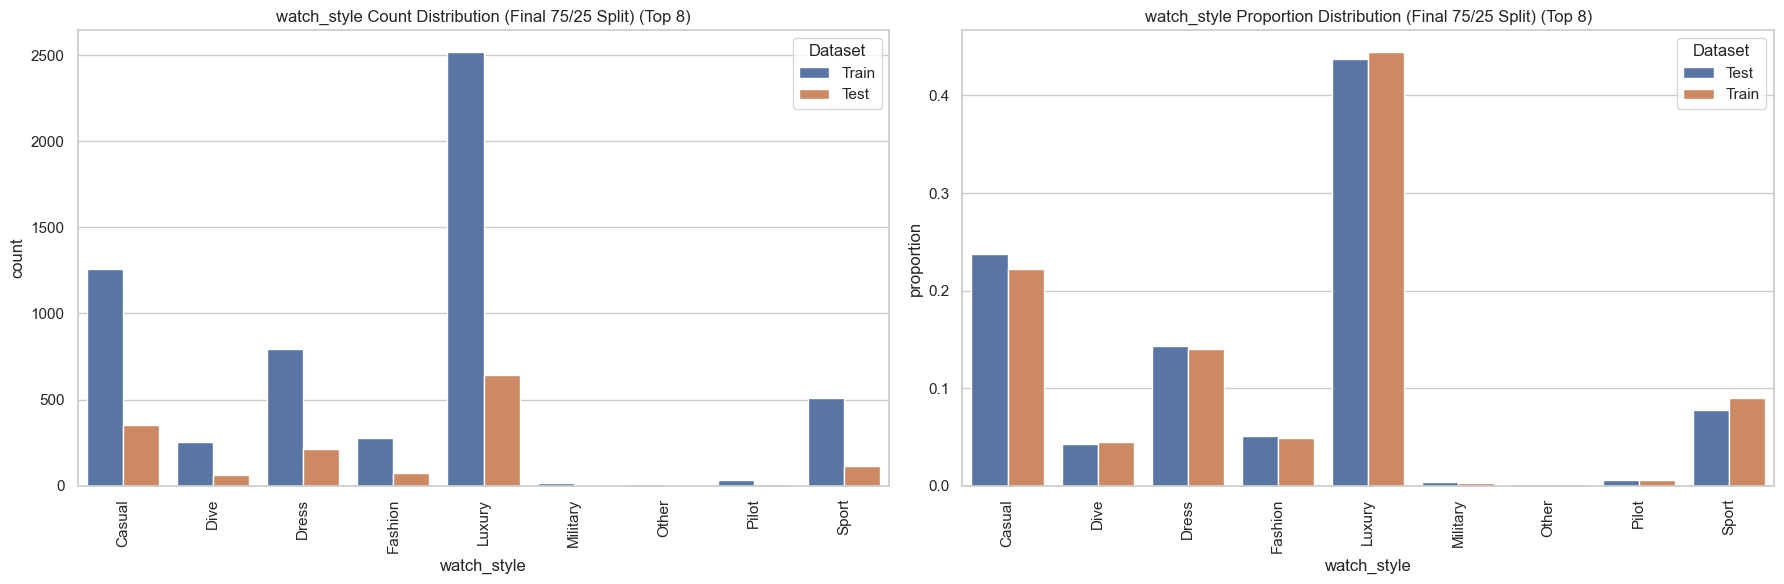

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['Dataset'] = 'Train'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].se

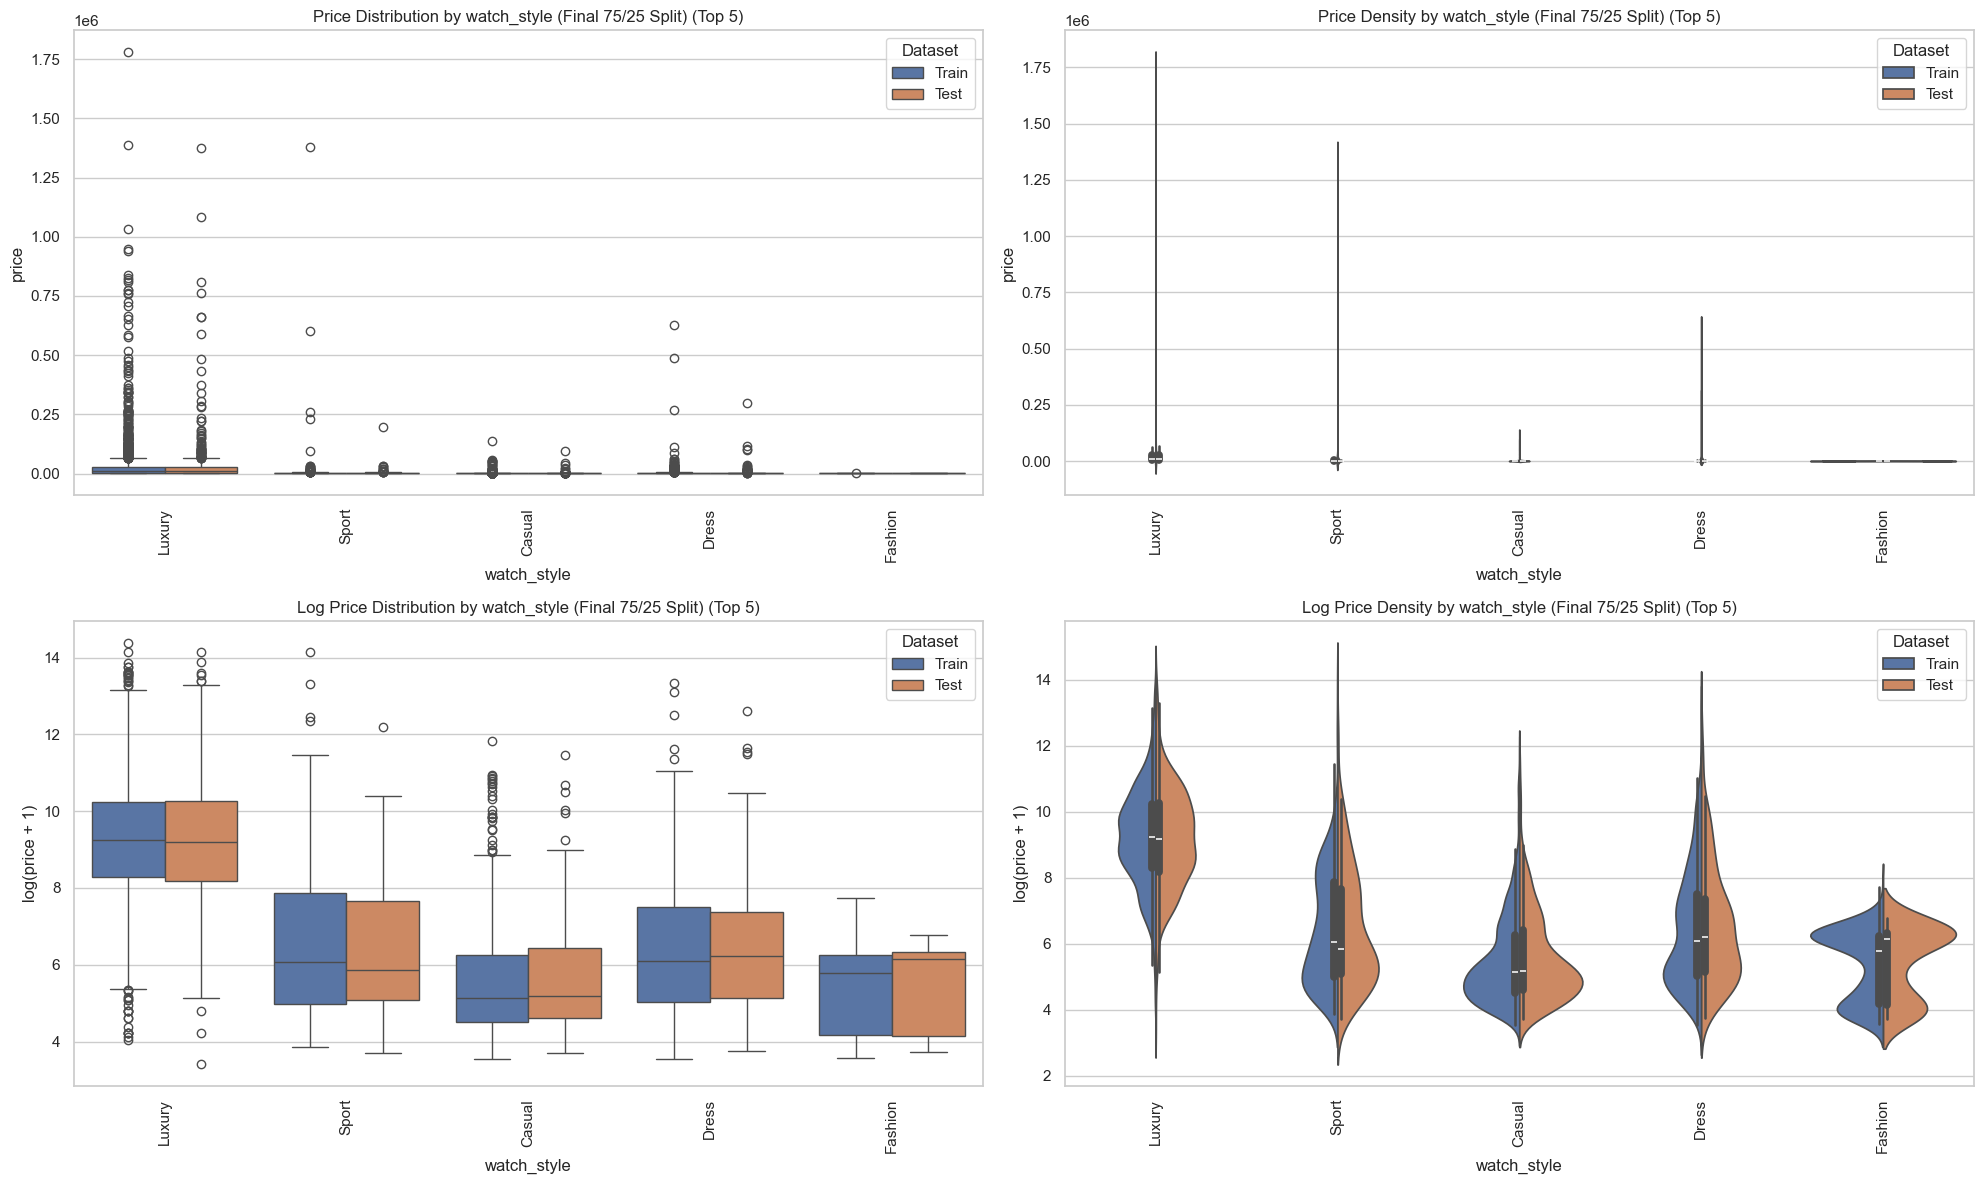

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


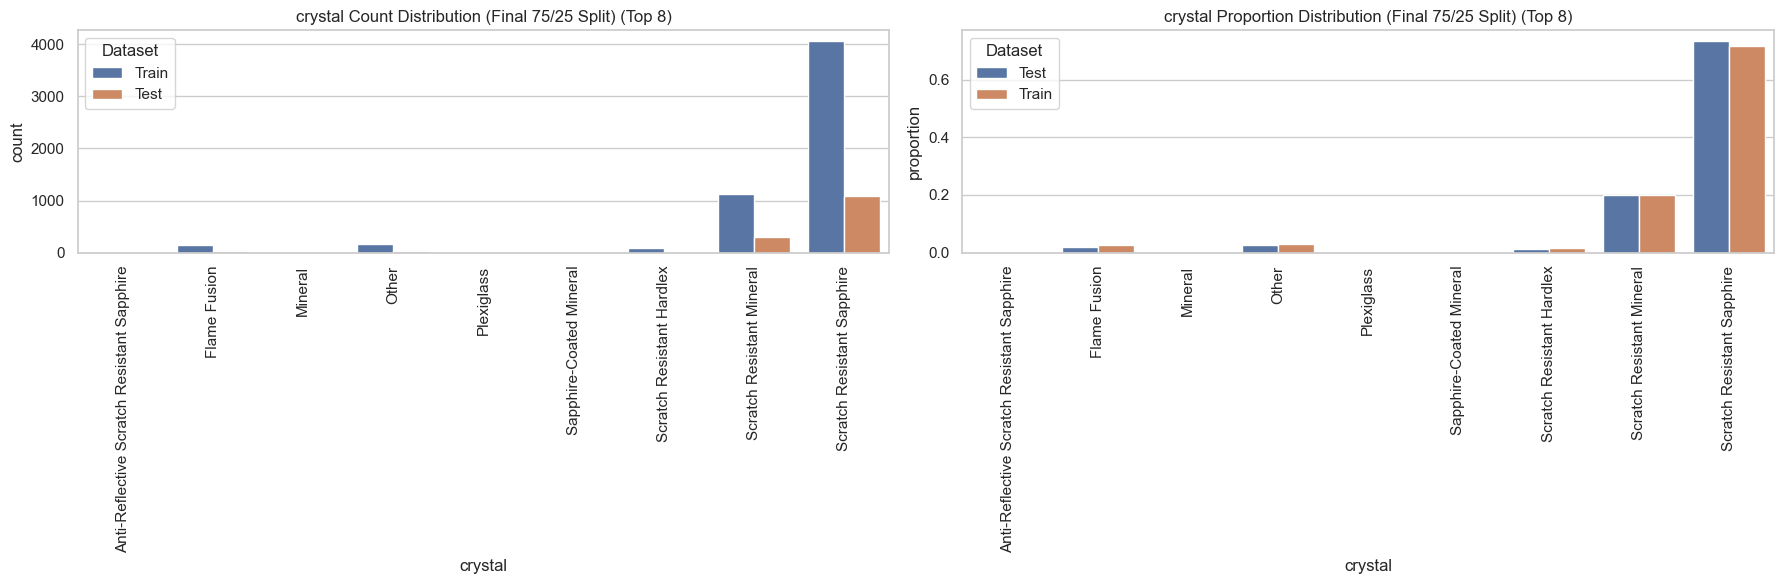

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['Dataset'] = 'Train'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].se

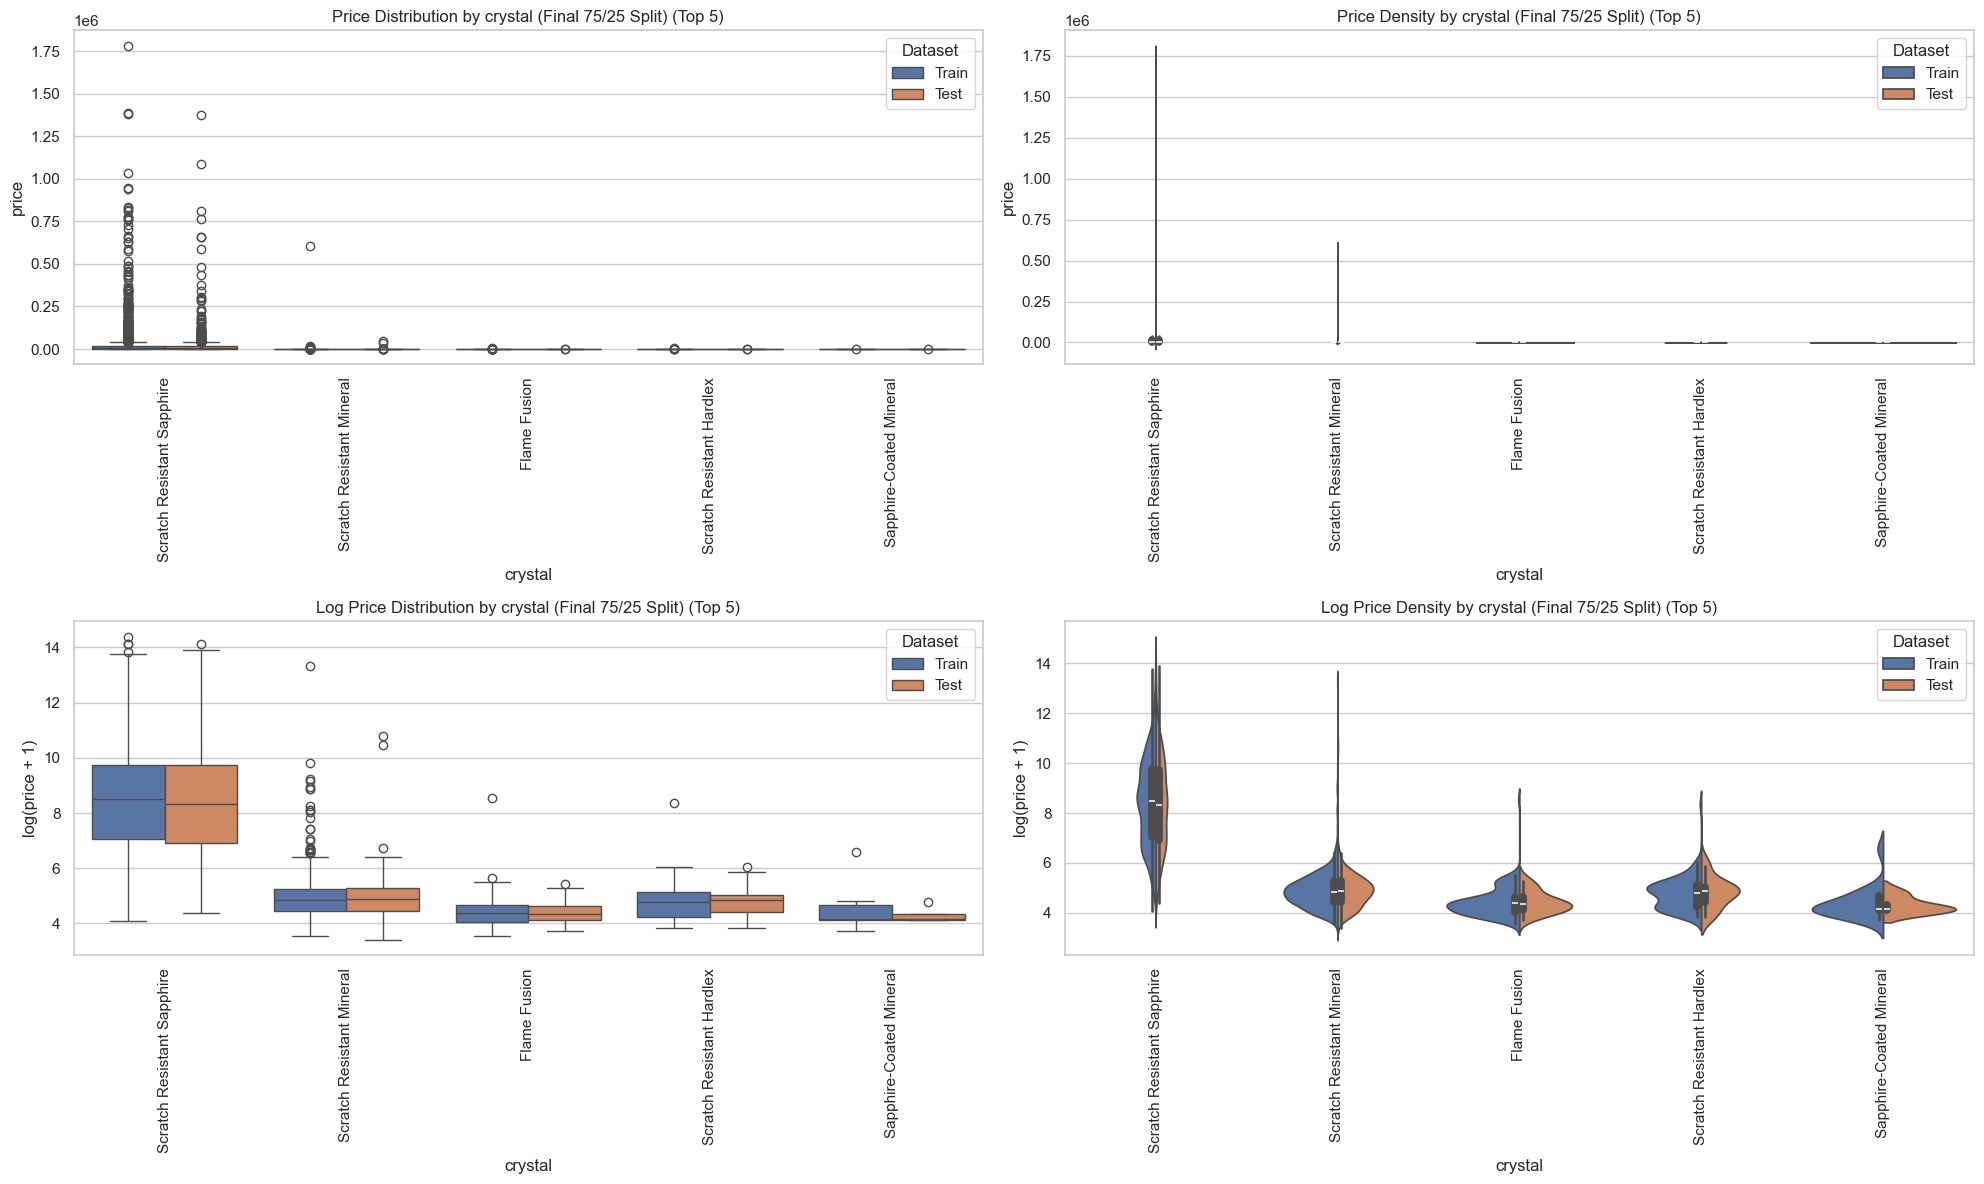

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


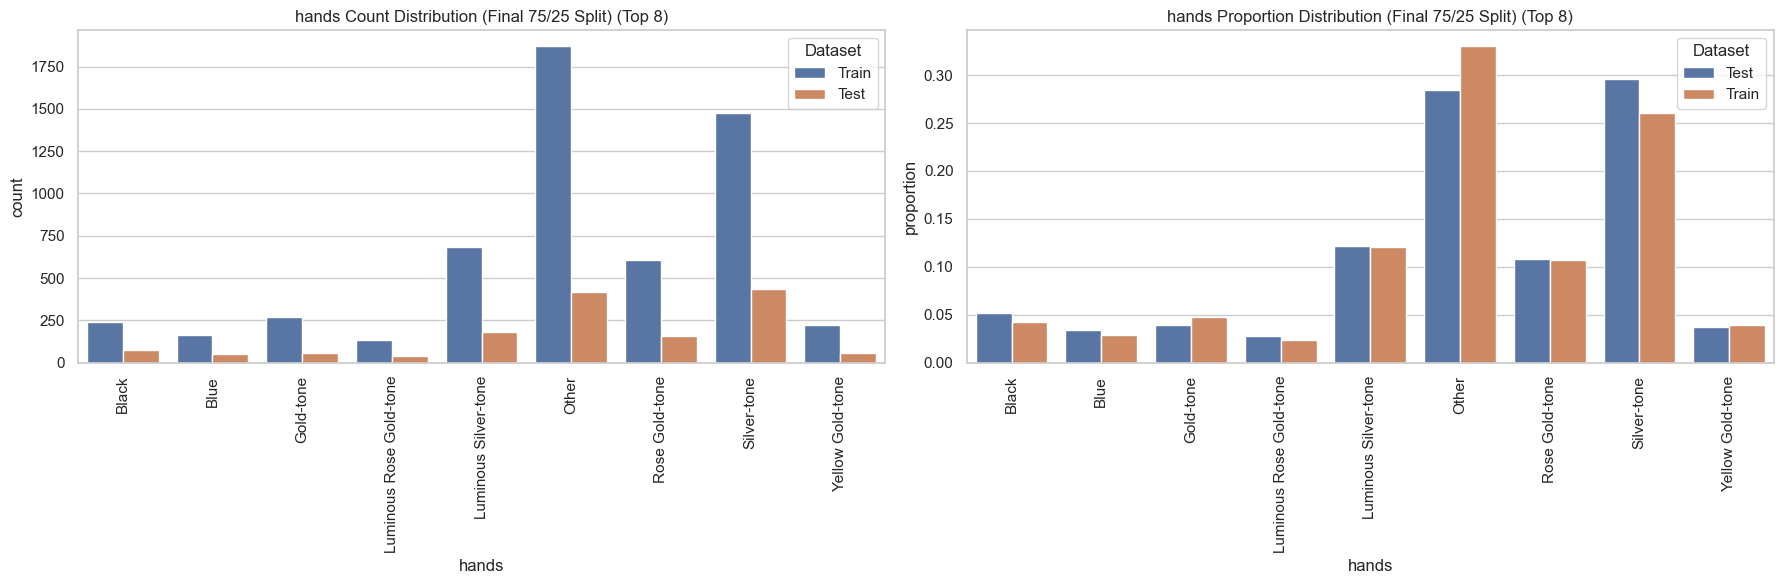

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['Dataset'] = 'Train'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].se

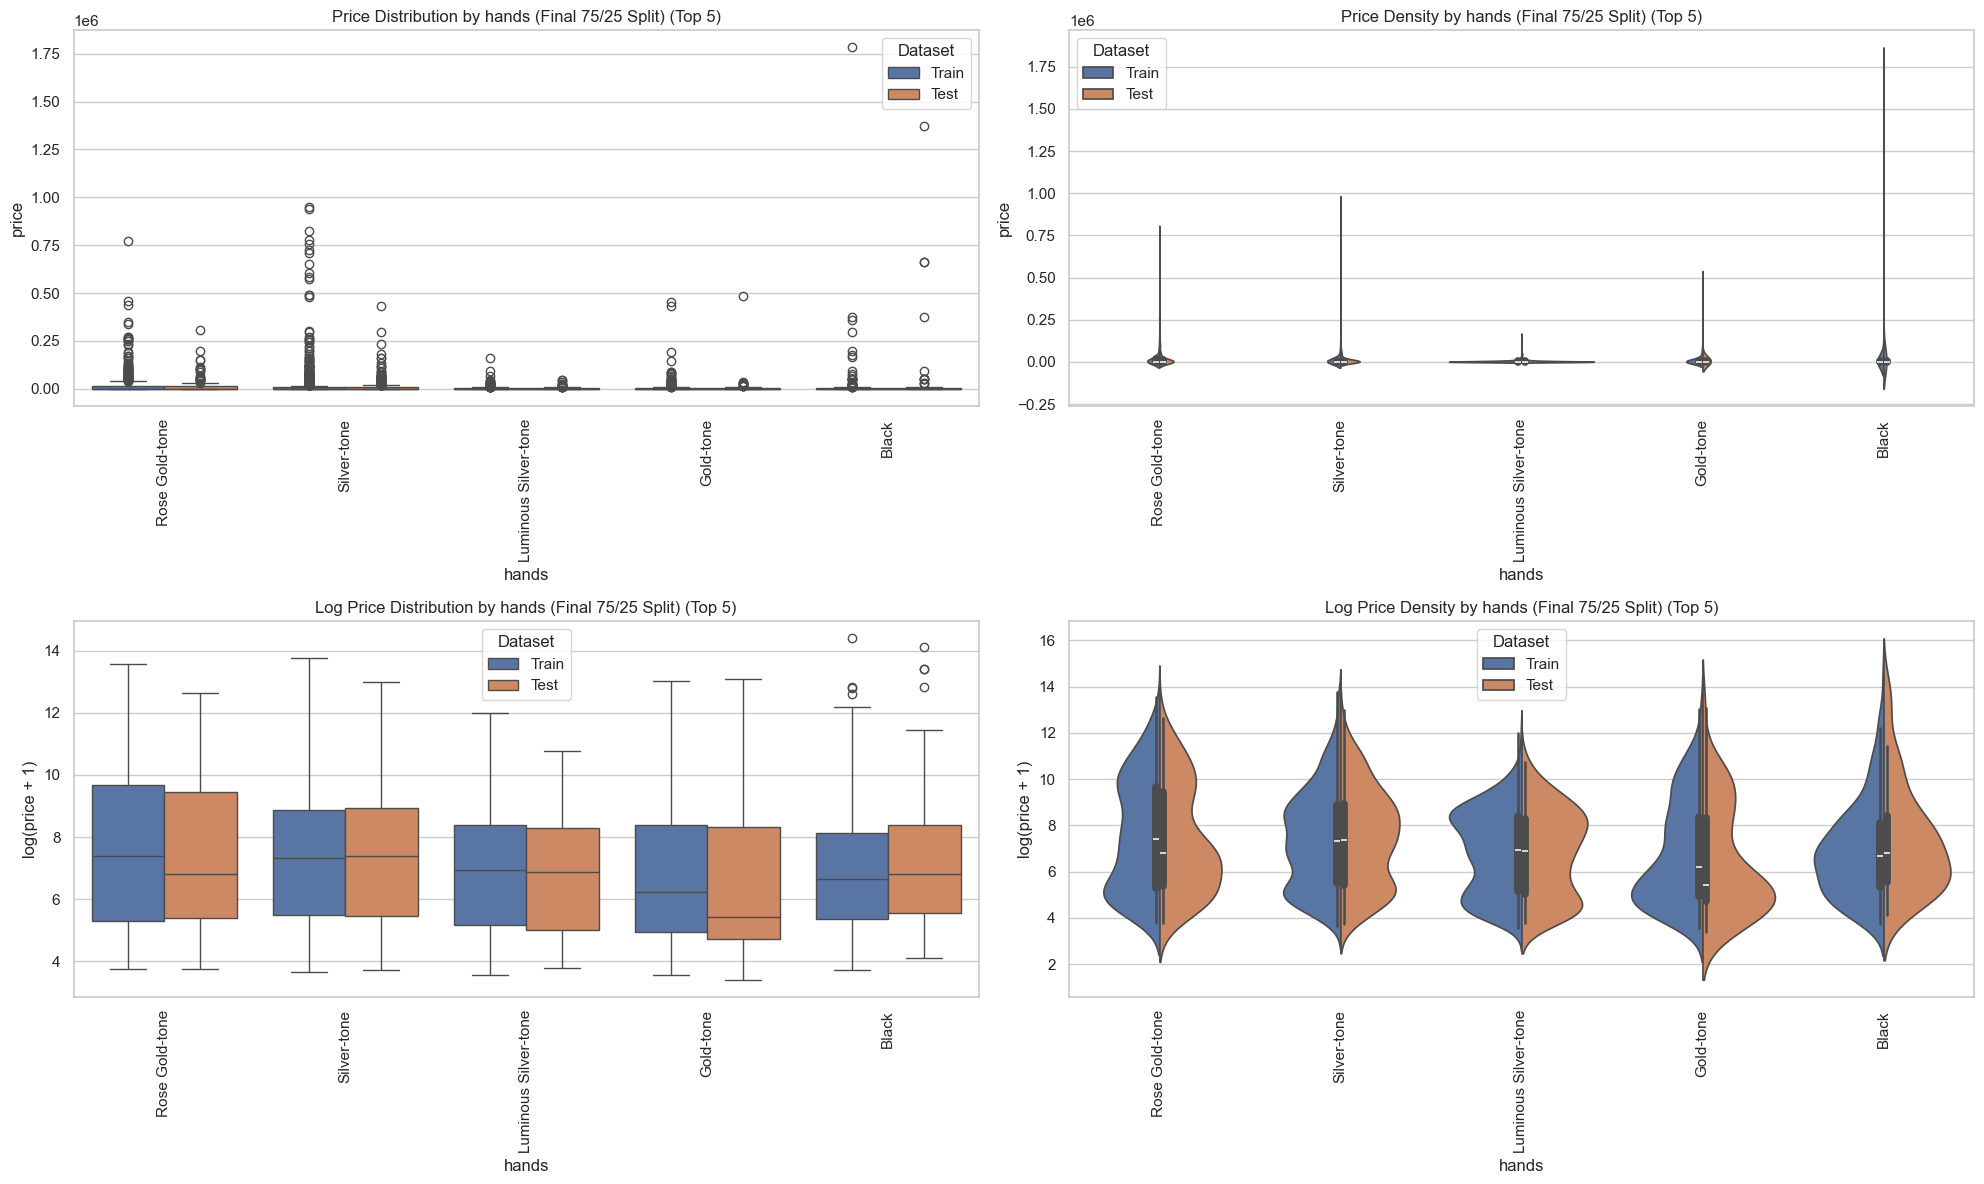

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


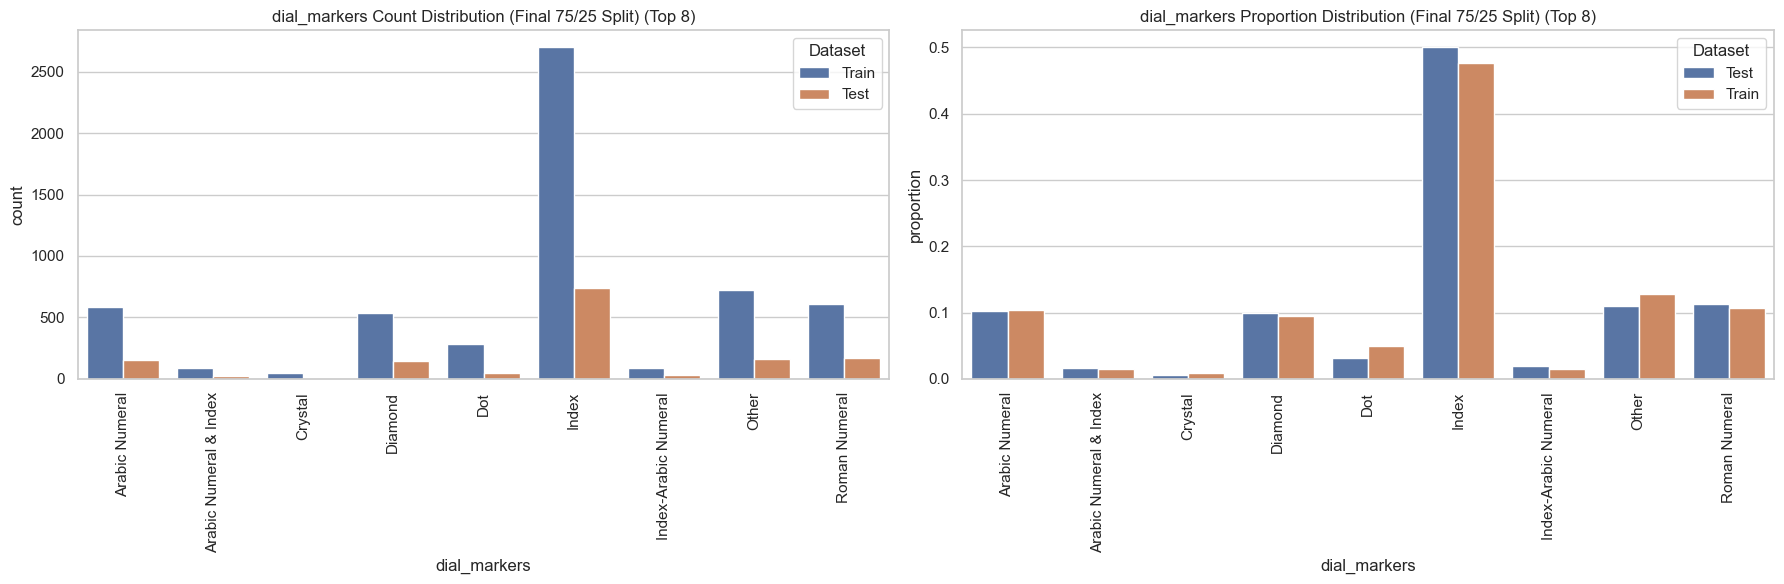

C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['Dataset'] = 'Train'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['Dataset'] = 'Test'
C:\Users\vulin\AppData\Local\Temp\ipykernel_23728\2602324494.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].se

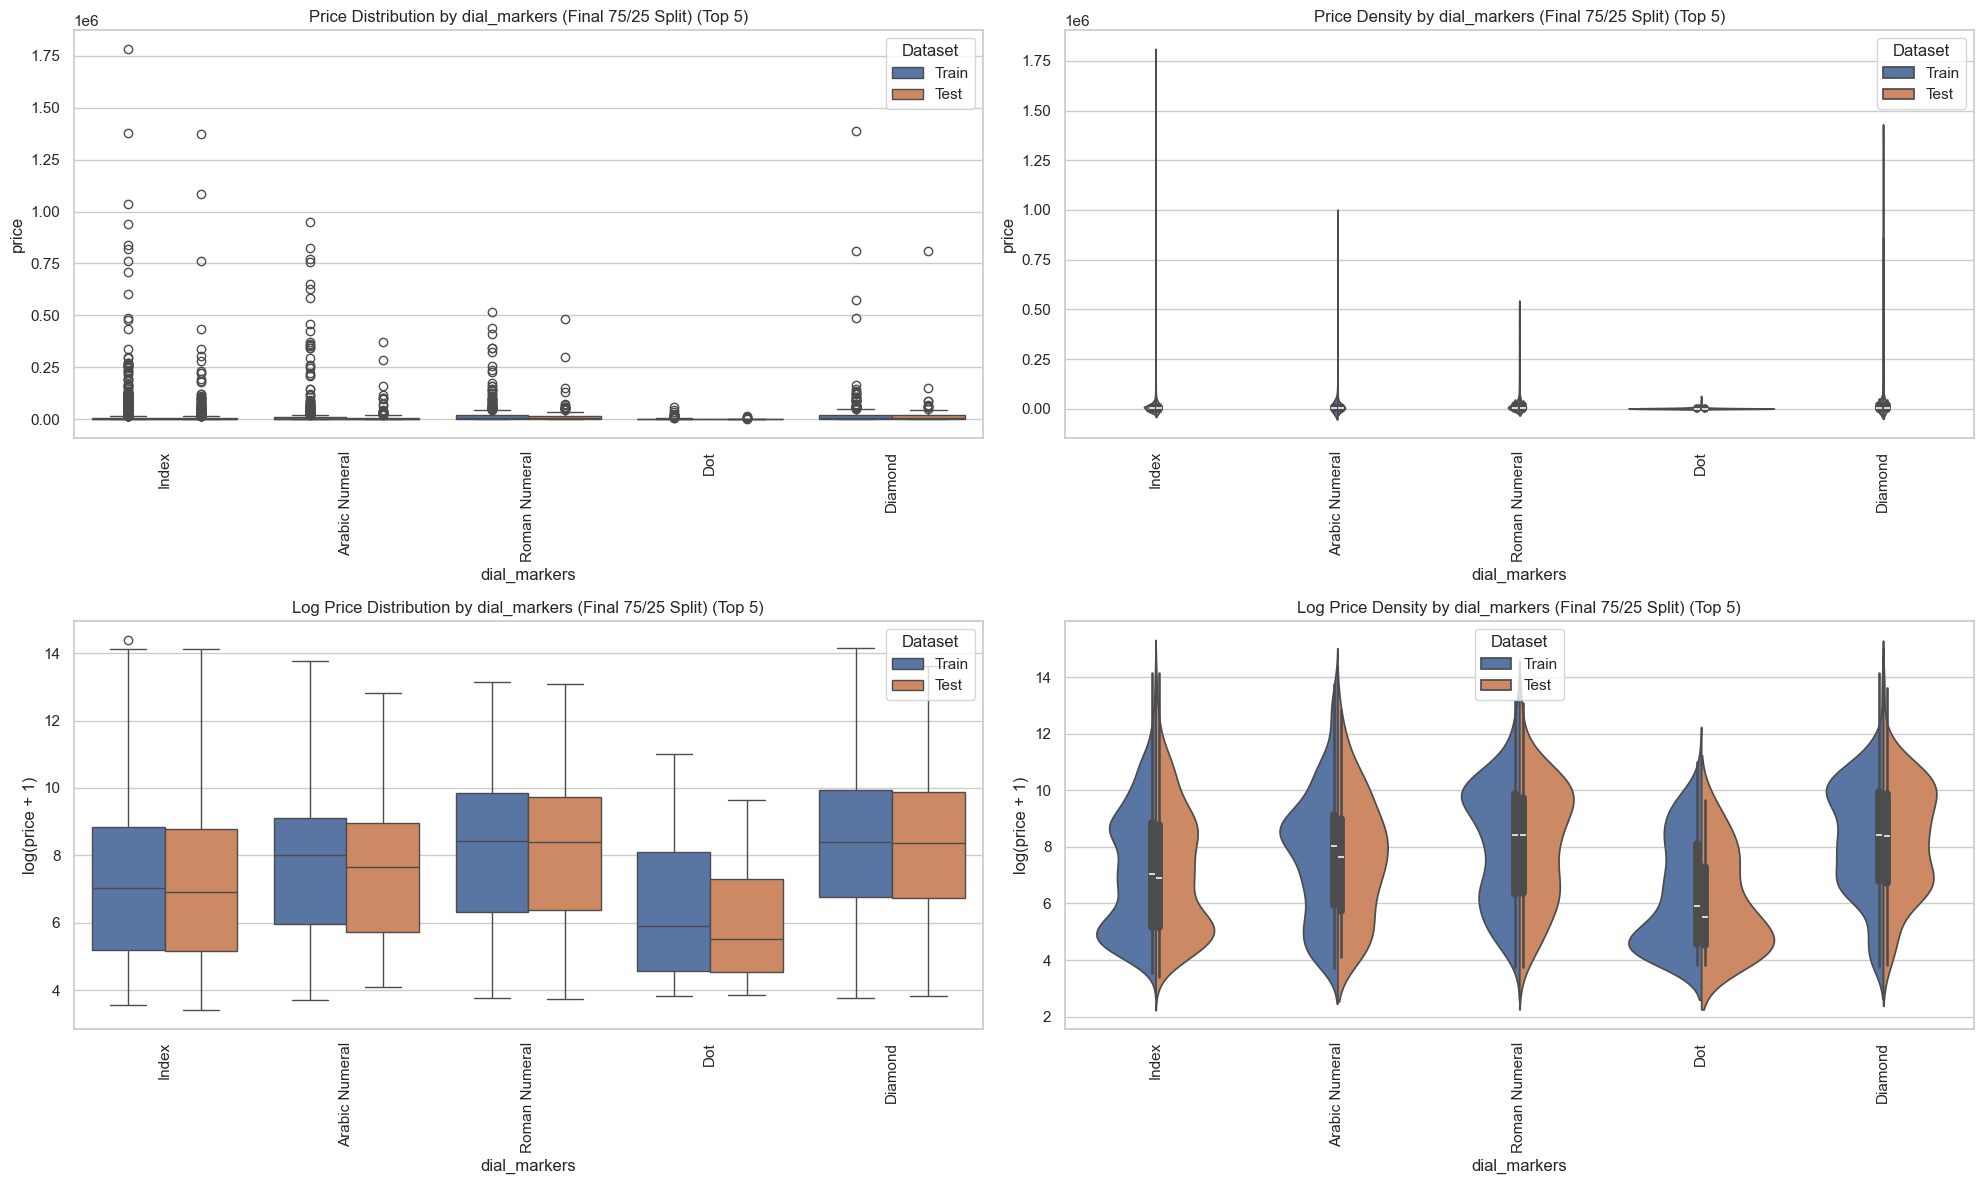


=== Visualizing Final Split Results ===


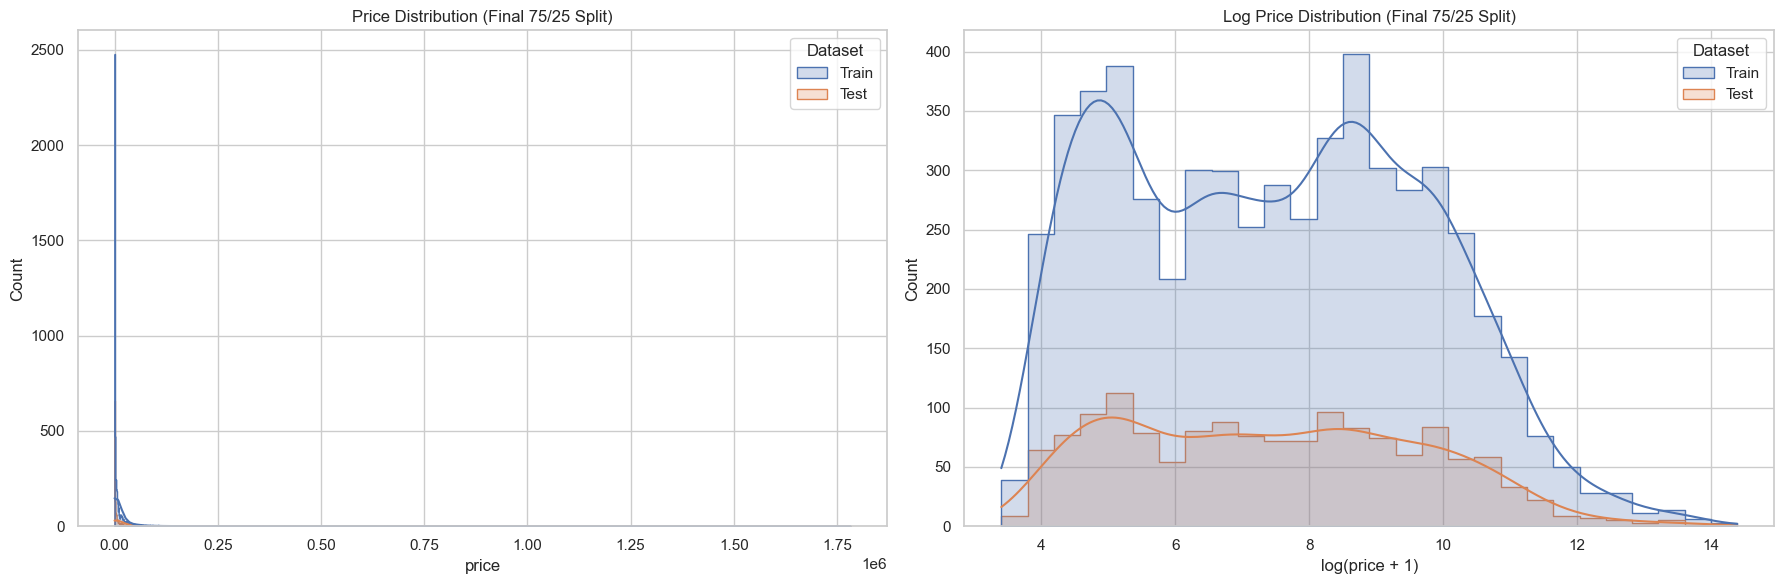

In [5]:
# Thực hiện stratified splits by price bins with train/test 75/25 (rare bins to train)
# With guaranteed no unseen categories in test set
test_size = 0.25

# Create price bins and handle duplicates
bins = pd.qcut(df['price'], q=30, duplicates='drop')
df['price_bin'] = bins

# Identify rare bins (fewer than 1/test_size occurrences)
min_count_bin = int(np.ceil(1 / test_size))
bin_counts = df['price_bin'].value_counts()
rare_bins = bin_counts[bin_counts < min_count_bin].index

print(f"Number of price bins: {len(bin_counts)}")
print(f"Number of rare price bins: {len(rare_bins)}")

# Split data into rare and common bins
df_bin_rare = df[df['price_bin'].isin(rare_bins)]
df_bin_common = df[~df['price_bin'].isin(rare_bins)]

print(f"Samples in rare bins: {len(df_bin_rare)} ({len(df_bin_rare)/len(df)*100:.2f}%)")
print(f"Samples in common bins: {len(df_bin_common)} ({len(df_bin_common)/len(df)*100:.2f}%)")

# Stratified split on common bins
if not df_bin_common.empty:
    X_bin = df_bin_common.drop(columns=['price', 'price_bin'])
    y_bin = df_bin_common['price']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_bin, y_bin,
        test_size=test_size,
        random_state=42,
        stratify=df_bin_common['price_bin']
    )
    
    # Add all rare samples to training set
    if not df_bin_rare.empty:
        X_train = pd.concat([X_train, df_bin_rare.drop(columns=['price', 'price_bin'])], axis=0)
        y_train = pd.concat([y_train, df_bin_rare['price']], axis=0)
else:
    # If all bins are rare (unlikely but handling the edge case)
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['price', 'price_bin']),
        df['price'],
        test_size=test_size,
        random_state=42
    )

# Check for unseen categories in test set and fix if necessary
print("\nChecking for unseen categories in test set before fixing:")
unseen_found = False
for col in cats:
    unseen = unseen_categories(X_train, X_test, col)
    if unseen:
        print(f"  {col}: {len(unseen)} unseen values in test: {unseen}")
        unseen_found = True
    
if not unseen_found:
    print("  No unseen categories found!")

# Fix unseen categories by ensuring all test categories are present in train
if unseen_found:
    print("\nFixing unseen categories...")
    
    # For each categorical feature
    for col in cats:
        # Find unseen values
        unseen = unseen_categories(X_train, X_test, col)
        
        if unseen:
            # Create a dataframe with test set rows and add price
            test_with_price = X_test.copy()
            test_with_price['price'] = y_test.values
            
            # For each unseen value
            for val in unseen:
                # Find rows in test set with this value
                unseen_rows = test_with_price[test_with_price[col] == val]
                
                if not unseen_rows.empty:
                    # Move one example to train set
                    row_to_move = unseen_rows.iloc[0:1]
                    
                    # Add to train
                    row_without_price = row_to_move.drop(columns=['price'])
                    price_value = row_to_move['price'].values
                    
                    X_train = pd.concat([X_train, row_without_price], axis=0)
                    y_train = pd.concat([y_train, pd.Series(price_value)], axis=0)
                    
                    # Remove from test
                    X_test = X_test.drop(row_to_move.index)
                    y_test = y_test.drop(row_to_move.index)
                    
                    print(f"  Moved example with {col}={val} from test to train")

# Verify the split after fixing
print(f"\nFinal split sizes after fixing:")
print(f"X_train: {X_train.shape} ({len(X_train)/len(df)*100:.2f}%)")
print(f"X_test: {X_test.shape} ({len(X_test)/len(df)*100:.2f}%)")

# Check if any unseen categories remain in test set
print("\nChecking for unseen categories in test set after fixing:")
unseen_count = 0
for col in cats:
    unseen = unseen_categories(X_train, X_test, col)
    if unseen:
        print(f"  {col}: {len(unseen)} unseen values in test: {unseen}")
        unseen_count += 1
    
if unseen_count == 0:
    print("  No unseen categories found!")

print("\n=== Completed Stratified Splits by Price Bins with No Unseen Categories ===")

# Reset indices to avoid duplicate index issues
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Visualize the distribution with these new splits
train_with_price = X_train.assign(price=y_train)
test_with_price = X_test.assign(price=y_test)

# Show final split sizes
print(f"\nFinal split sizes:")
print(f"X_train: {X_train.shape} ({len(X_train)/len(df)*100:.2f}%)")
print(f"X_test: {X_test.shape} ({len(X_test)/len(df)*100:.2f}%)")

# Visualize training and test sets size with number
print("\n=== Visualizing Training and Test Set Sizes ===")
def plot_set_sizes(train_size, test_size):
    sizes = [train_size, test_size]
    labels = ['Train Set', 'Test Set']
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=sizes, palette='viridis')
    plt.title('Training and Test Set Sizes (75/25 Split)')
    plt.ylabel('Number of Samples')
    plt.xlabel('Set Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_set_sizes(len(X_train), len(X_test))

# Visualize categorical distributions in the final split
for col in cats:
    plot_cat_distribution_sns(
        train_with_price, 
        test_with_price, 
        col, 
        top_n=8,
        title_suffix="(Final 75/25 Split)"
    )
    
    # Price distribution for each category (with log scale)
    plot_price_by_category(
        train_with_price,
        test_with_price,
        col,
        top_n=5,
        title_suffix="(Final 75/25 Split)"
    )

# Overall price distribution (normal and log scale)
print("\n=== Visualizing Final Split Results ===")
plot_price_distribution(y_train, y_test, title_suffix="(Final 75/25 Split)")

### 3.2.2. Save train/test split data to dataset directory


In [ ]:
# Create directory if it doesn't exist
import os
os.makedirs("../dataset", exist_ok=True)

# Combine features and target variable for train set
train_df = X_train.copy()
train_df['price'] = y_train

# Combine features and target variable for test set
test_df = X_test.copy()
test_df['price'] = y_test

# Save to CSV files
train_df.to_csv("../dataset/raw_train.csv", index=False)
test_df.to_csv("../dataset/raw_test.csv", index=False)

print("\n=== Dataset Saving ===")
print(f"Train set saved to ../dataset/raw_train.csv ({train_df.shape[0]} samples, {train_df.shape[1]} columns)")
print(f"Test set saved to ../dataset/raw_test.csv ({test_df.shape[0]} samples, {test_df.shape[1]} columns)")


=== Dataset Saving ===
Train set saved to ../dataset/train.csv (5665 samples, 15 columns)
Test set saved to ../dataset/test.csv (1476 samples, 15 columns)


### 3.2.3. Show summary and result of train/test split


Original train shape: (5665, 15)
Original test shape: (1476, 15)


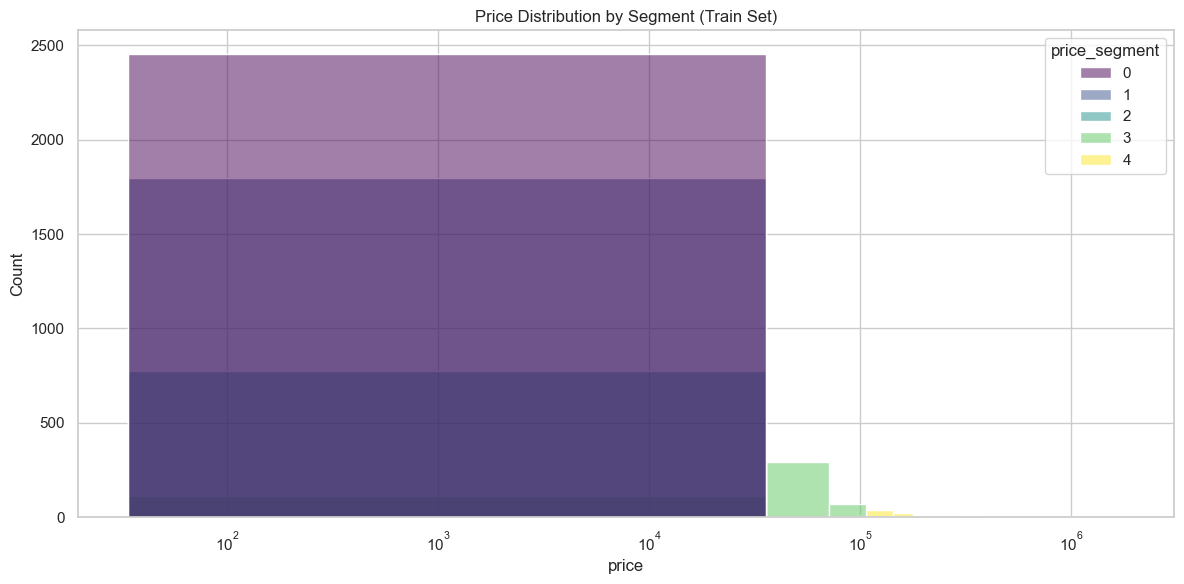


Manual price segment boundaries:
Segment 0 (Budget): < 1,000
Segment 1 (Affordable): 1,000 - 9,999
Segment 2 (Mid-Range): 10,000 - 29,999
Segment 3 (Premium): 30,000 - 99,999
Segment 4 (Luxury): ≥ 100,000


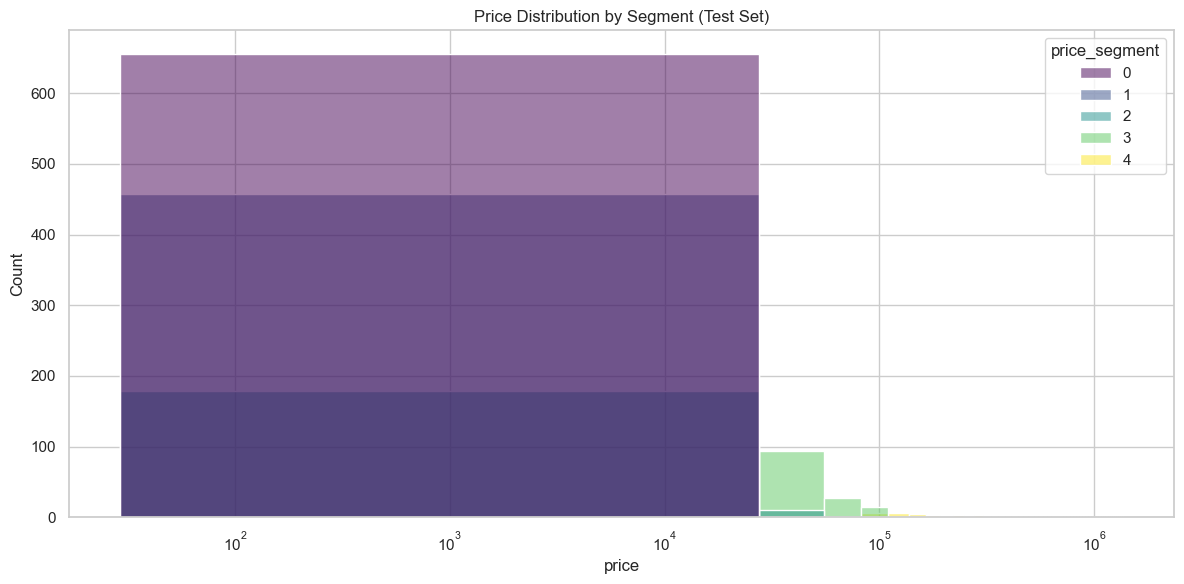


Price segment distribution (train):
      Segment  Count  Percentage
0      Budget   2456   43.353928
1  Affordable   1796   31.703442
2   Mid-Range    773   13.645190
3     Premium    480    8.473080
4      Luxury    160    2.824360

Price segment distribution (test):
      Segment  Count  Percentage
0      Budget    656   44.444444
1  Affordable    458   31.029810
2   Mid-Range    188   12.737127
3     Premium    136    9.214092
4      Luxury     38    2.574526


<Figure size 1200x600 with 0 Axes>

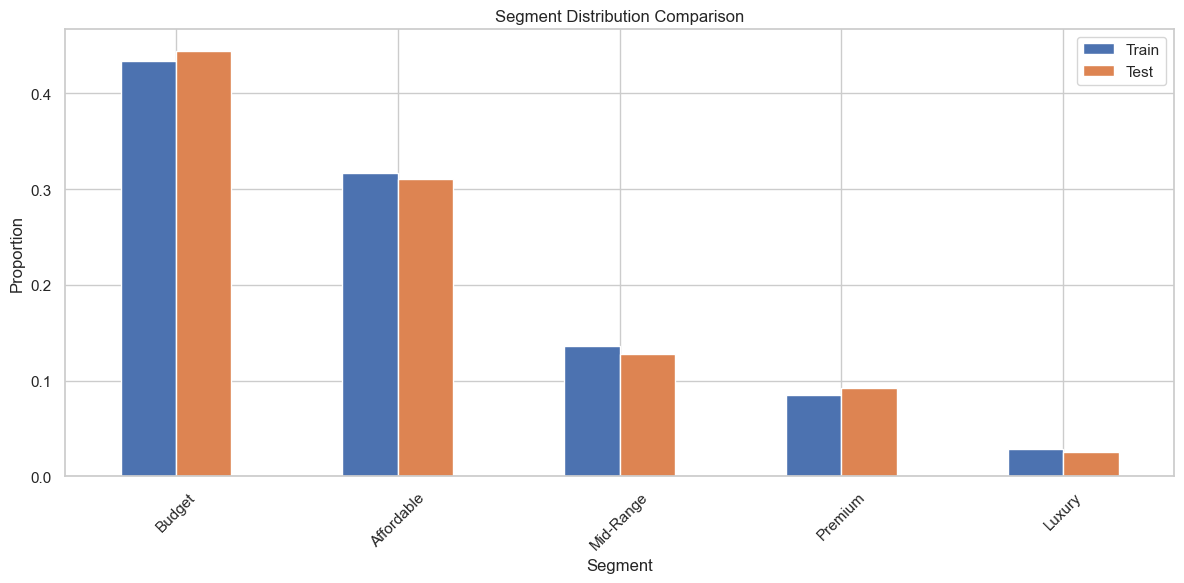

<Figure size 1200x600 with 0 Axes>

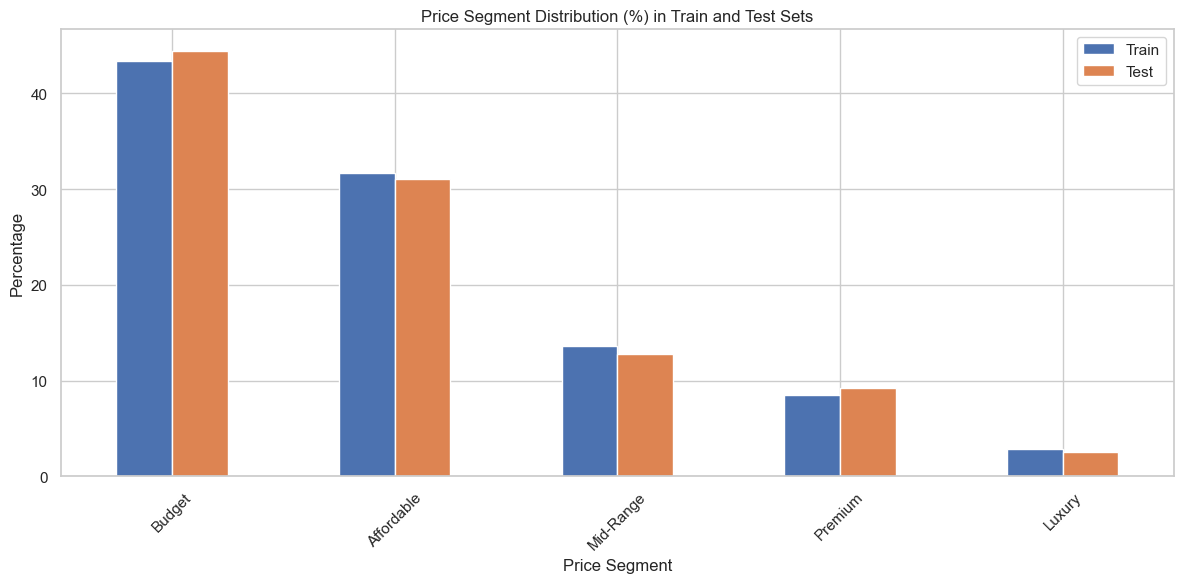


=== Final Dataset Saving ===
Train set saved to ../dataset/train_segmented.csv (5665 samples, 15 columns)
Test set saved to ../dataset/test_segmented.csv (1476 samples, 15 columns)

Price column has been replaced with price_segment (0-4) in both datasets
Segment meanings:
  0: Budget
  1: Affordable
  2: Mid-Range
  3: Premium
  4: Luxury


In [ ]:
# Load necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create directory if it doesn't exist
os.makedirs("../dataset", exist_ok=True)

# Load train and test datasets
train_df = pd.read_csv("../dataset/train_encoded.csv")
test_df = pd.read_csv("../dataset/raw_test.csv")

print(f"Original train shape: {train_df.shape}")
print(f"Original test shape: {test_df.shape}")

# Define manual price thresholds based on domain knowledge
# Create a function to assign price segments
def assign_price_segment(price):
    if price < 1000:
        return 0  # Budget
    elif price < 10000:
        return 1  # Affordable
    elif price < 30000:
        return 2  # Mid-Range
    elif price < 100000:
        return 3  # Premium
    else:
        return 4  # Luxury (100000+)

# Apply the function to create price segments
train_df['price_segment'] = train_df['price'].apply(assign_price_segment)
test_df['price_segment'] = test_df['price'].apply(assign_price_segment)

# Define segment names for better visualization
segment_names = ['Budget', 'Affordable', 'Mid-Range', 'Premium', 'Luxury']

# Visualize the price segments in train set
plt.figure(figsize=(12, 6))
sns.histplot(train_df, x='price', hue='price_segment', bins=50, 
             hue_order=range(5), palette='viridis')
plt.title('Price Distribution by Segment (Train Set)')
plt.xscale('log')
plt.tight_layout()
plt.show()

# Print segment boundaries
print("\nManual price segment boundaries:")
print(f"Segment 0 (Budget): < 1,000")
print(f"Segment 1 (Affordable): 1,000 - 9,999")
print(f"Segment 2 (Mid-Range): 10,000 - 29,999")
print(f"Segment 3 (Premium): 30,000 - 99,999")
print(f"Segment 4 (Luxury): ≥ 100,000")

# Visualize the price segments in test set
plt.figure(figsize=(12, 6))
sns.histplot(test_df, x='price', hue='price_segment', bins=50,
             hue_order=range(5), palette='viridis')
plt.title('Price Distribution by Segment (Test Set)')
plt.xscale('log')
plt.tight_layout()
plt.show()

# Count samples in each segment for both datasets
train_counts = train_df['price_segment'].value_counts().sort_index()
test_counts = test_df['price_segment'].value_counts().sort_index()

# Calculate percentages
train_segment_dist = train_counts / len(train_df)
test_segment_dist = test_counts / len(test_df)

# Create dataframes with segment names
train_segment_stats = pd.DataFrame({
    'Segment': [segment_names[i] if i in train_segment_dist.index else segment_names[i] for i in range(5)],
    'Count': [train_counts.get(i, 0) for i in range(5)],
    'Percentage': [train_segment_dist.get(i, 0) * 100 for i in range(5)]
})

test_segment_stats = pd.DataFrame({
    'Segment': [segment_names[i] if i in test_segment_dist.index else segment_names[i] for i in range(5)],
    'Count': [test_counts.get(i, 0) for i in range(5)],
    'Percentage': [test_segment_dist.get(i, 0) * 100 for i in range(5)]
})

print("\nPrice segment distribution (train):")
print(train_segment_stats)
print("\nPrice segment distribution (test):")
print(test_segment_stats)

# Compare the distributions visually
plt.figure(figsize=(12, 6))
pd.DataFrame({
    'Train': train_segment_dist,
    'Test': test_segment_dist
}).plot(kind='bar')
plt.title('Segment Distribution Comparison')
plt.ylabel('Proportion')
plt.xlabel('Segment')
plt.xticks(ticks=range(5), labels=segment_names, rotation=45)
plt.tight_layout()
plt.show()

# Create stacked bar chart to show the segment distribution
plt.figure(figsize=(12, 6))
combined_stats = pd.DataFrame({
    'Train': train_segment_stats['Percentage'],
    'Test': test_segment_stats['Percentage']
})
combined_stats.index = segment_names
combined_stats.plot(kind='bar', stacked=False)
plt.title('Price Segment Distribution (%) in Train and Test Sets')
plt.ylabel('Percentage')
plt.xlabel('Price Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prepare final datasets with price segment but without original price
train_final = train_df.drop(columns=['price'])
test_final = test_df.drop(columns=['price'])
if 'log_price' in train_final.columns:
    train_final = train_final.drop(columns=['log_price'])
if 'log_price' in test_final.columns:
    test_final = test_final.drop(columns=['log_price'])

# Save final datasets
train_final.to_csv("../dataset/cleaned_data_train.csv", index=False)
test_final.to_csv("../dataset/cleaned_data_test.csv", index=False)

print("\n=== Final Dataset Saving ===")
print(f"Train set saved to ../dataset/cleaned_data_train.csv ({train_final.shape[0]} samples, {train_final.shape[1]} columns)")
print(f"Test set saved to ../dataset/cleaned_data_test.csv ({test_final.shape[0]} samples, {test_final.shape[1]} columns)")
print("\nPrice column has been replaced with price_segment (0-4) in both datasets")
print("Segment meanings:")
for i, name in enumerate(segment_names):
    print(f"  {i}: {name}")

# Encoding by target Encoding and One-hot Encoding

-   **Mã Hóa Mục Tiêu (Target Encoding)**:

    -   Chất liệu vỏ (Case Material)
    -   Chất liệu dây đeo (Band Material)
    -   Mặt sau vỏ (Case Back)
    -   Chất liệu vành (Bezel Material)
    -   Thương hiệu (Brand)

-   **Mã Hóa One-hot**:

    -   Giới tính (Gender)
    -   Bộ máy (Movement)

-   **Chỉ Mã Hóa Mục Tiêu**:
    -   Mặt kính (Crystal)
    -   Kim đồng hồ (Hands)
    -   Đánh dấu mặt số (Dial Marker)


In [ ]:
import pandas as pd
import numpy as np
import json
import os

# Load the training data
train_df = pd.read_csv('../dataset/raw_train.csv')

# Define function for target encoding
def target_encode(df, column, target, alpha=5):
    # Calculate global mean
    global_mean = float(df[target].mean())
    
    # Calculate means and counts for each category
    agg = df.groupby(column)[target].agg(['mean', 'count'])
    
    # Apply smoothing (Laplace smoothing with parameter alpha)
    smoothed_means = (agg['mean'] * agg['count'] + global_mean * alpha) / (agg['count'] + alpha)
    
    # Create mapping dictionary with native Python types
    encoding_dict = {str(k): float(v) for k, v in smoothed_means.items()}
    
    # Set the global mean as the default for unseen categories
    encoding_dict['__default__'] = global_mean
    
    return encoding_dict

# Define function to apply target encoding
def apply_target_encoding(df, column, encoding_dict):
    # Get the default value for unseen categories
    default_value = encoding_dict.get('__default__')
    
    # Create a copy of the encoding dictionary without the __default__ key
    encoding_dict_copy = {k: v for k, v in encoding_dict.items() if k != '__default__'}
    
    # Apply the encoding
    encoded_values = df[column].astype(str).map(encoding_dict_copy)
    
    # Use default value for unseen categories
    if default_value is not None:
        encoded_values = encoded_values.fillna(default_value)
    
    return encoded_values

# Lists of columns for different encoding methods
target_encode_cols = ['case_material', 'band_material', 'case_back', 'bezel_material', 'brand', 'watch_style']
onehot_encode_cols = ['gender', 'movement']
target_encode_only_cols = ['crystal', 'hands', 'dial_markers']

# Dictionary to store encoding parameters
encoding_params = {
    'target_encoding': {},
    'onehot_encoding': {}
}

# Compute target encoding dictionaries and apply to train data
for col in target_encode_cols + target_encode_only_cols:
    encoding_dict = target_encode(train_df, col, 'price')
    encoding_params['target_encoding'][col] = encoding_dict
    # Apply the encoding to the training data
    train_df[f'{col}_encoded'] = apply_target_encoding(train_df, col, encoding_dict)

# Apply one-hot encoding to specified columns
for col in onehot_encode_cols:
    # Get unique values
    unique_values = [str(val) for val in train_df[col].unique().tolist()]
    
    # Store the unique values
    encoding_params['onehot_encoding'][col] = unique_values
    
    # Apply one-hot encoding
    dummies = pd.get_dummies(train_df[col], prefix=col)
    
    # Concatenate with the original DataFrame
    train_df = pd.concat([train_df, dummies], axis=1)

# Remove original categorical columns
cols_to_drop = target_encode_cols + onehot_encode_cols + target_encode_only_cols
train_df = train_df.drop(columns=cols_to_drop)

# Create directory if it doesn't exist
os.makedirs('../dataset', exist_ok=True)

# Save encoding parameters to JSON file
with open('../dataset/encoding_params.json', 'w') as f:
    json.dump(encoding_params, f, indent=4)

# Save the transformed dataset
train_df.to_csv('../dataset/train_encoded.csv', index=False)

print("Encoding completed successfully!")
print(f"Encoding parameters saved to: ../dataset/encoding_params.json")
print(f"Encoded training data saved to: ../dataset/train_encoded.csv")
print(f"\nOriginal shape: {len(train_df.columns) - len(encoding_params['target_encoding']) - sum(len(dummies.columns) for col in onehot_encode_cols)}")
print(f"New shape after encoding: {len(train_df.columns)}")

Encoding completed successfully!
Encoding parameters saved to: ../dataset/encoding_params.json
Encoded training data saved to: ../dataset/train_encoded.csv

Original shape: 3
New shape after encoding: 20


Encoded dataframe shape: (5665, 20)


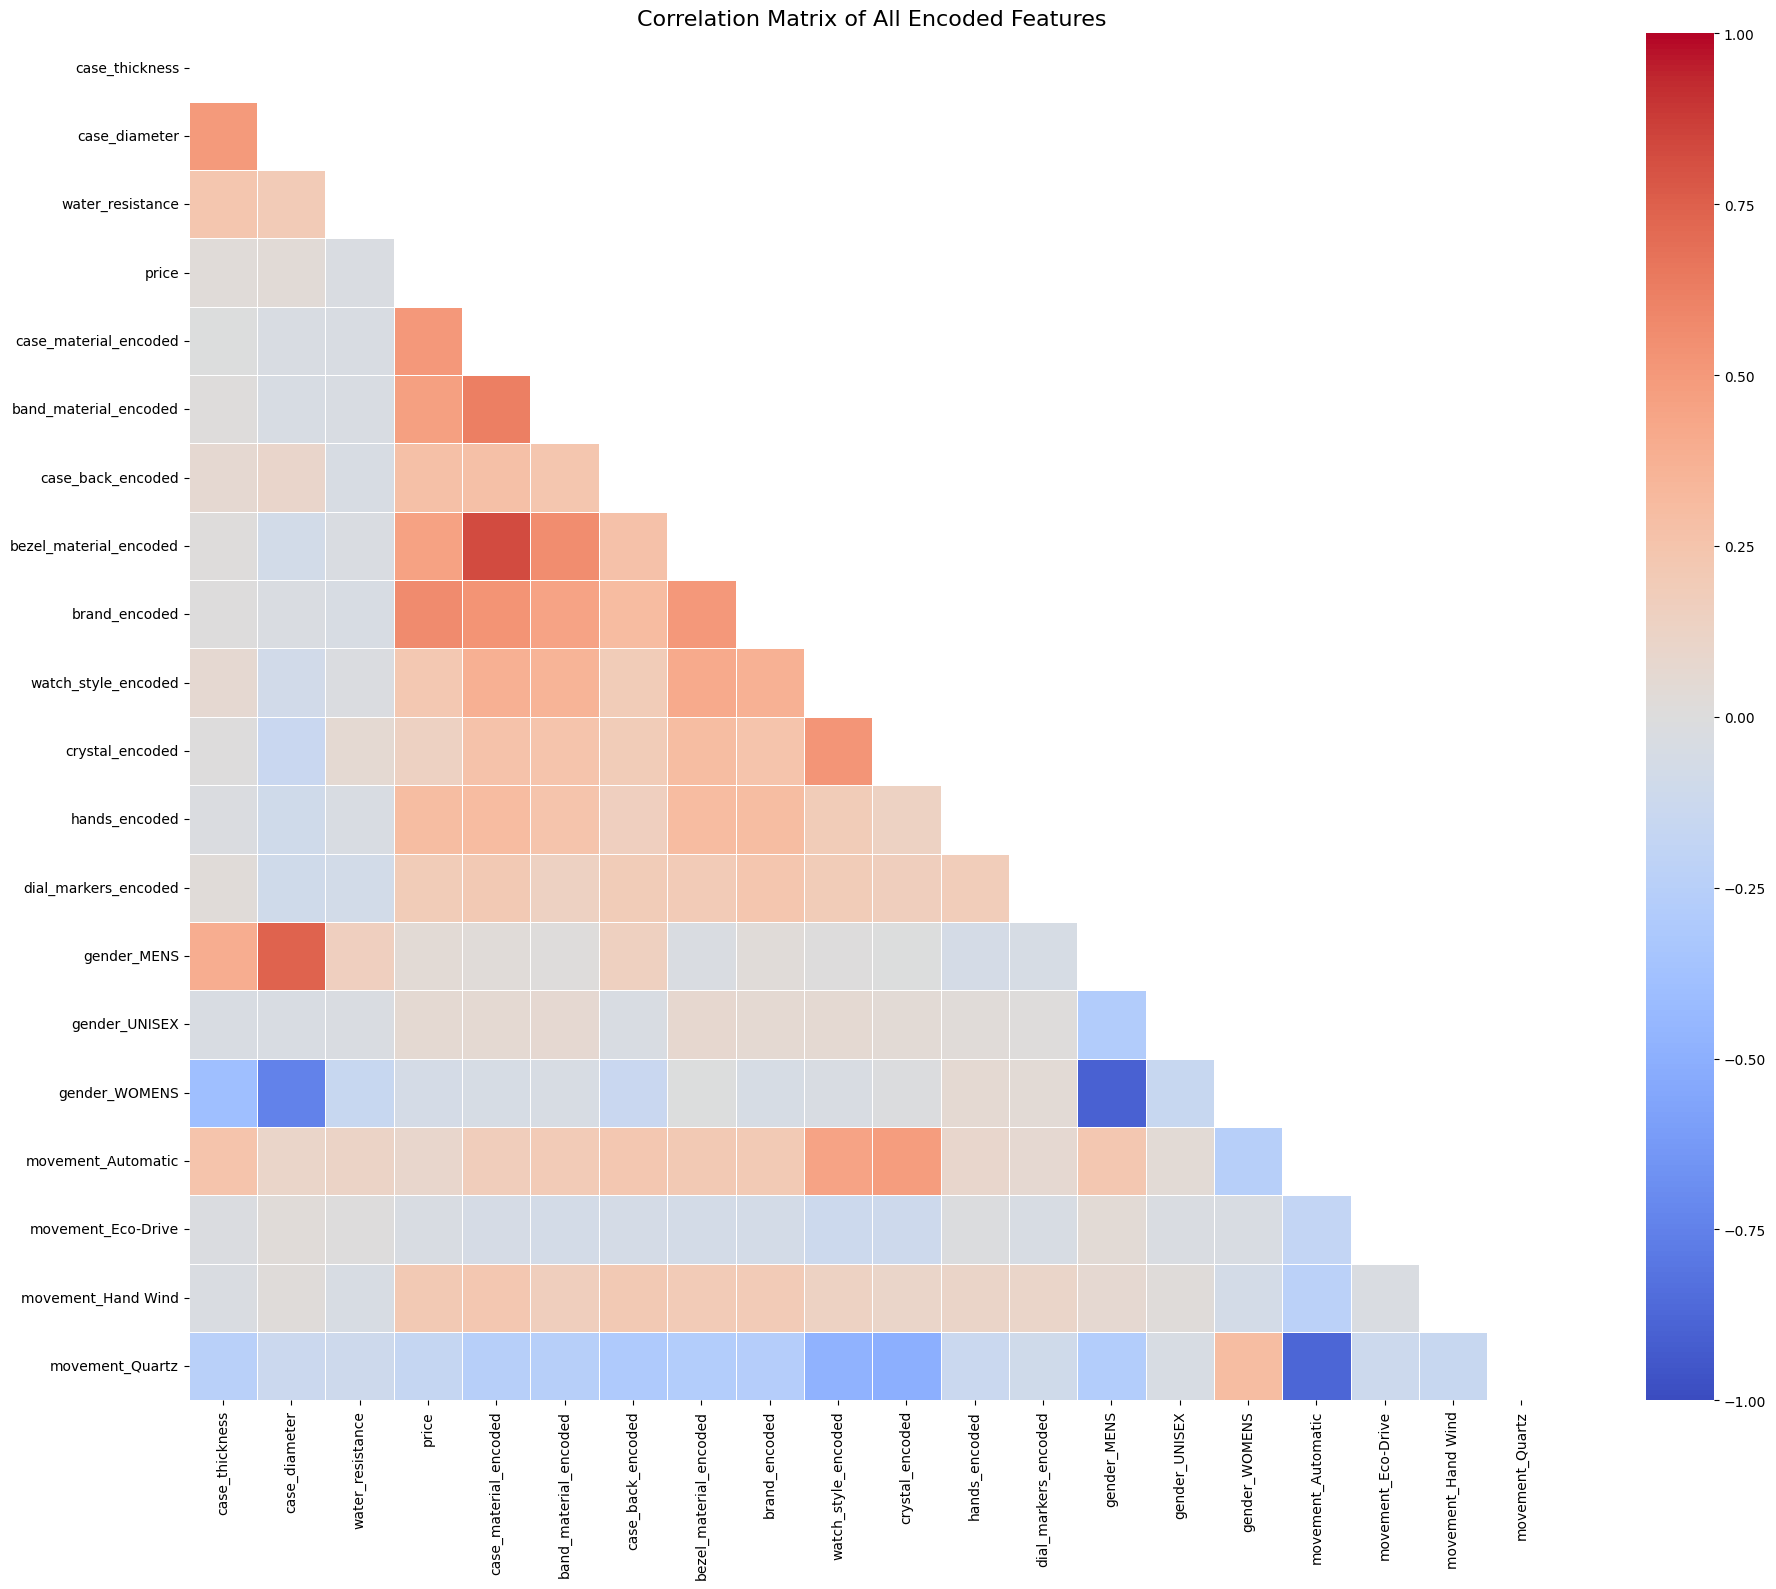


Top 10 features positively correlated with price:
price                     1.000000
brand_encoded             0.568958
case_material_encoded     0.504114
band_material_encoded     0.467791
bezel_material_encoded    0.456792
hands_encoded             0.297210
case_back_encoded         0.279815
watch_style_encoded       0.221989
movement_Hand Wind        0.217058
dial_markers_encoded      0.189883
crystal_encoded           0.146453
Name: price, dtype: float64

Top 10 features negatively correlated with price:
crystal_encoded       0.146453
movement_Automatic    0.089762
gender_UNISEX         0.057563
gender_MENS           0.041271
case_diameter         0.037573
case_thickness        0.031237
water_resistance     -0.027449
movement_Eco-Drive   -0.038189
gender_WOMENS        -0.068353
movement_Quartz      -0.166629
Name: price, dtype: float64


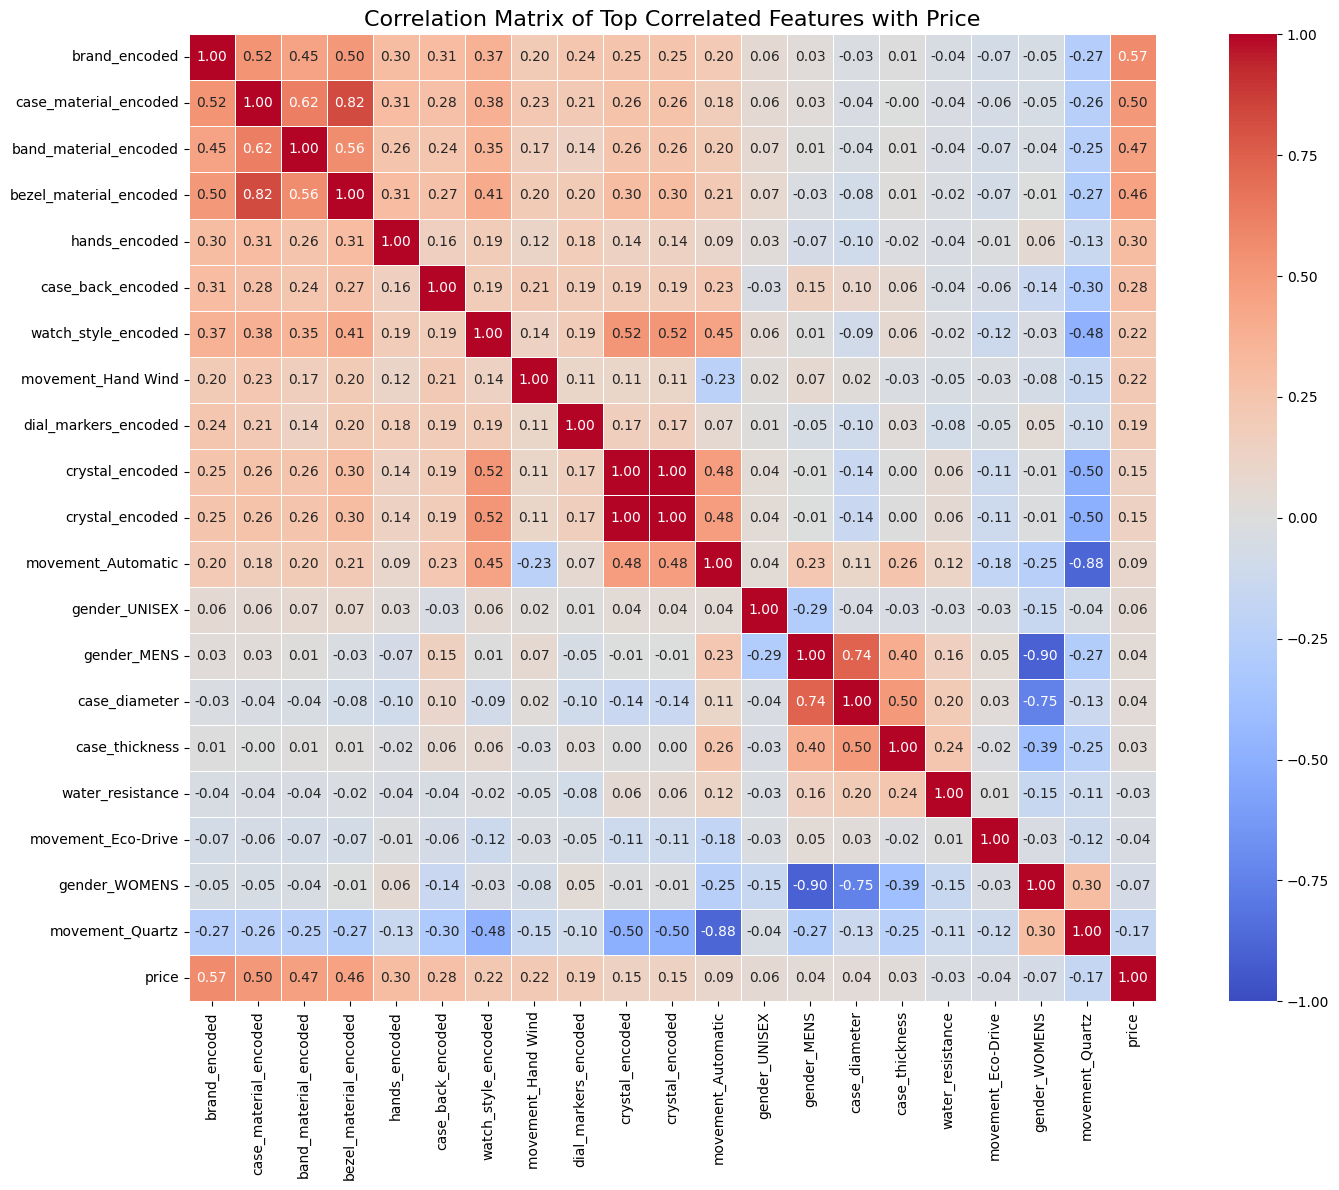

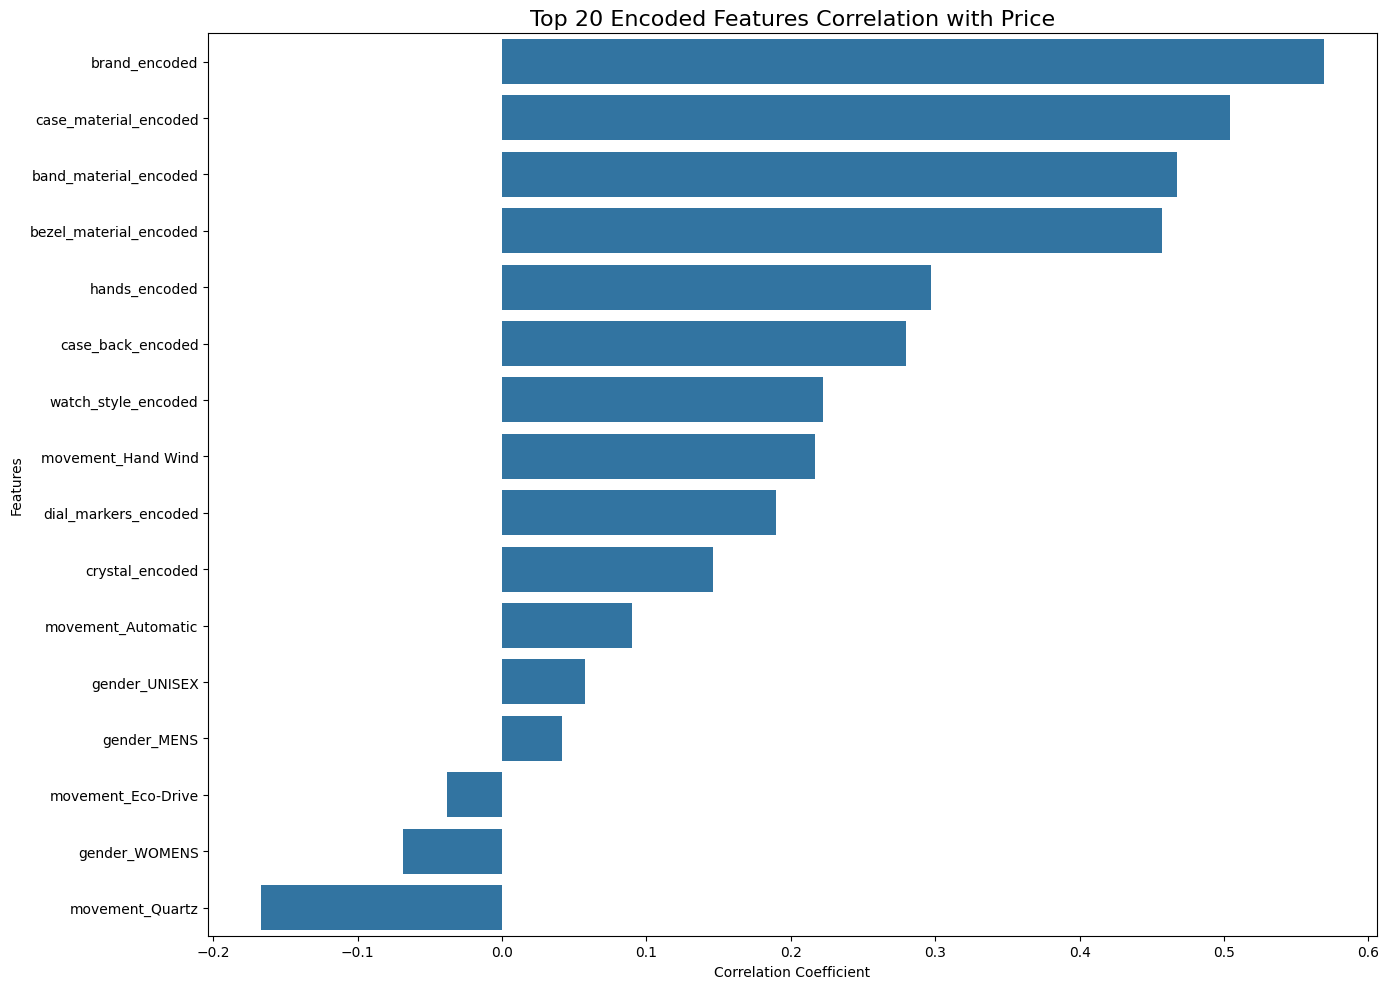

C:\Users\vulin\AppData\Local\Temp\ipykernel_8072\3109259055.py:80: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  corr_linkage = linkage(1 - np.abs(corr_matrix), method='average')


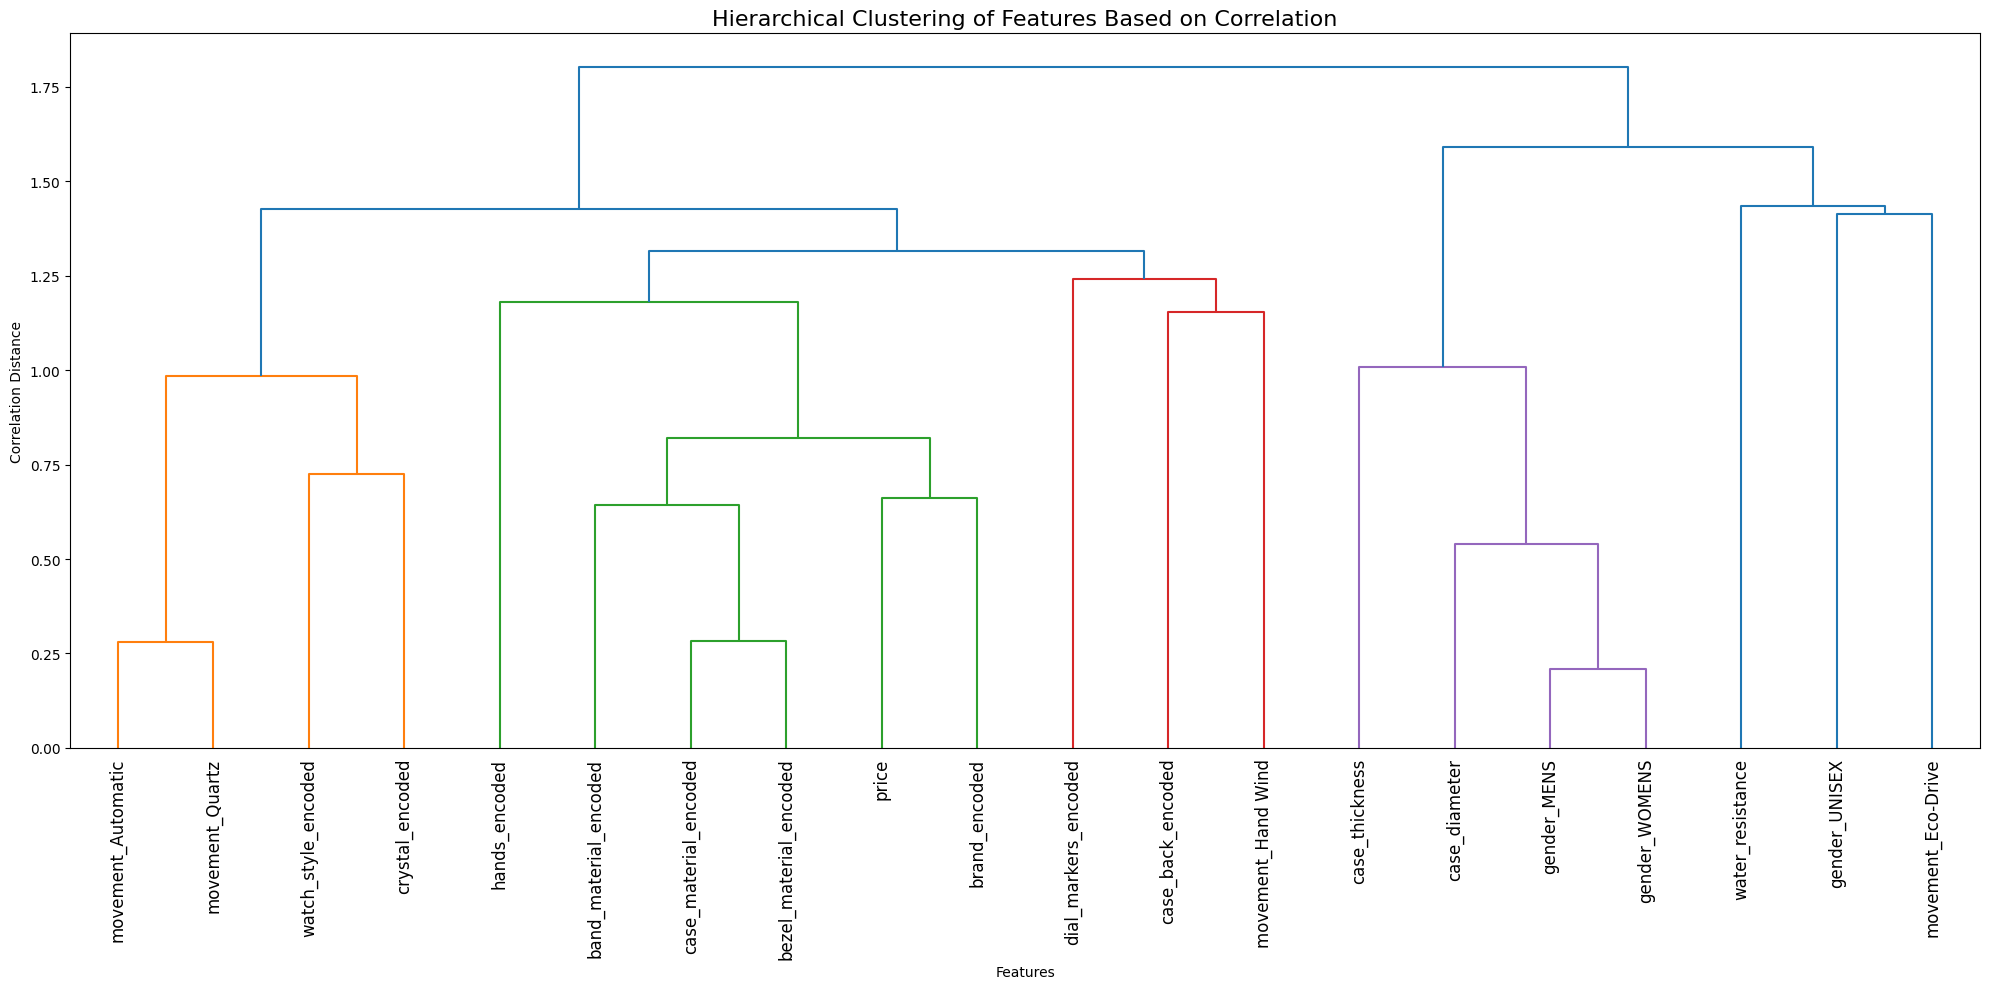


Correlation analysis complete. Visualizations saved to dataset folder.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the encoded training data
encoded_df = pd.read_csv('../dataset/train_encoded.csv')

print(f"Encoded dataframe shape: {encoded_df.shape}")

# Calculate correlation matrix
corr_matrix = encoded_df.corr()

# Create a mask for the upper triangle to avoid redundancy
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1.0, vmin=-1.0, 
            center=0, square=True, linewidths=.5, annot=False, fmt='.2f')

plt.title('Correlation Matrix of All Encoded Features', fontsize=16)
plt.tight_layout()
plt.savefig('../dataset/correlation_matrix_full.png', dpi=300)
plt.show()

# Get correlations with price
price_corr = corr_matrix['price'].sort_values(ascending=False)
print("\nTop 10 features positively correlated with price:")
print(price_corr.head(11))  # 11 because 'price' itself will be first

print("\nTop 10 features negatively correlated with price:")
print(price_corr.tail(10))

# Create a focused correlation map with just the top correlated features
# Select top 10 positively and top 10 negatively correlated features
top_pos = price_corr.head(11).index.tolist()[1:]  # Skip 'price' itself
top_neg = price_corr.tail(10).index.tolist()
important_features = top_pos + top_neg + ['price']

# Subset the correlation matrix
important_corr = corr_matrix.loc[important_features, important_features]

# Plot the focused heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(important_corr, cmap='coolwarm', vmax=1.0, vmin=-1.0,
            center=0, square=True, linewidths=.5, annot=True, fmt='.2f')

plt.title('Correlation Matrix of Top Correlated Features with Price', fontsize=16)
plt.tight_layout()
plt.savefig('../dataset/correlation_matrix_top_features.png', dpi=300)
plt.show()

# Visualize correlations of encoded categorical features with price
target_encoded_cols = [col for col in encoded_df.columns if col.endswith('_encoded')]
onehot_cols = [col for col in encoded_df.columns if '_' in col and not col.endswith('_encoded') 
               and col not in ['watch_style', 'water_resistance', 'case_diameter', 'case_thickness', 'price']]

# Combine all encoded features
all_encoded_cols = target_encoded_cols + onehot_cols + ['price']
encoded_corr = encoded_df[all_encoded_cols].corr()['price'].sort_values(ascending=False)

plt.figure(figsize=(14, 10))
sns.barplot(x=encoded_corr.values[1:21], y=encoded_corr.index[1:21])
plt.title('Top 20 Encoded Features Correlation with Price', fontsize=16)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('../dataset/top_encoded_correlations.png', dpi=300)
plt.show()

# Optional: Create clusters of correlated features
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute the correlation distance (1 - abs(correlation))
corr_linkage = linkage(1 - np.abs(corr_matrix), method='average')

plt.figure(figsize=(20, 10))
dendrogram(corr_linkage, labels=corr_matrix.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering of Features Based on Correlation', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Correlation Distance')
plt.tight_layout()
plt.savefig('../dataset/feature_correlation_clustering.png', dpi=300)
plt.show()

print("\nCorrelation analysis complete. Visualizations saved to dataset folder.")

<Figure size 1400x800 with 0 Axes>

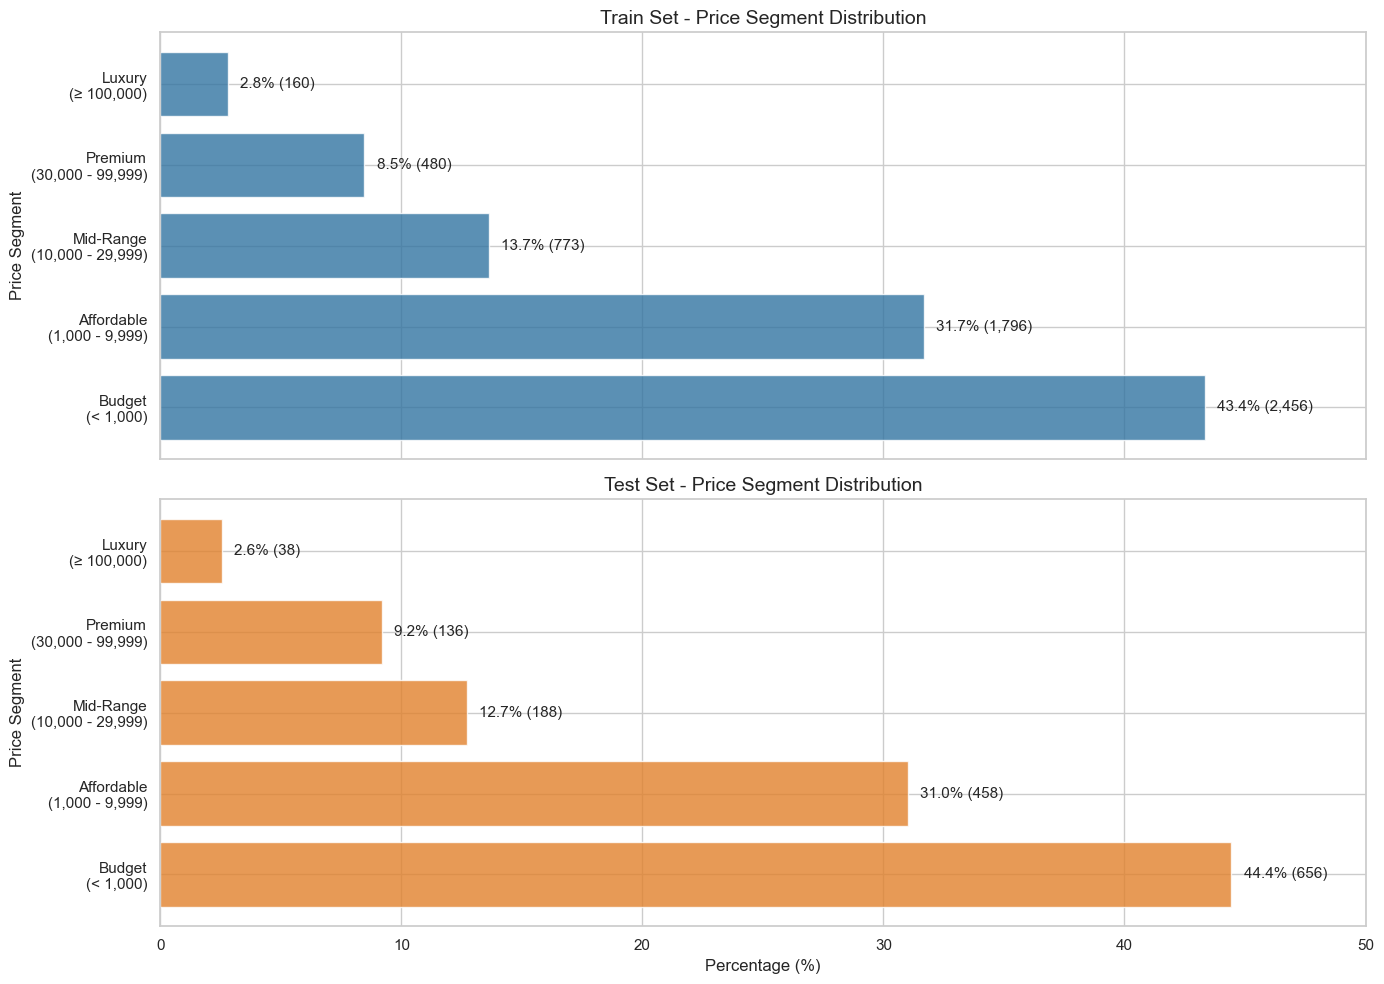

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for all visualizations
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Create DataFrames for the data
train_data = {
    'Segment': ['Budget', 'Affordable', 'Mid-Range', 'Premium', 'Luxury'],
    'Count': [2456, 1796, 773, 480, 160],
    'Percentage': [43.35, 31.70, 13.65, 8.47, 2.82]
}

test_data = {
    'Segment': ['Budget', 'Affordable', 'Mid-Range', 'Premium', 'Luxury'],
    'Count': [656, 458, 188, 136, 38],
    'Percentage': [44.44, 31.03, 12.74, 9.21, 2.57]
}

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Set segment boundaries for visualization
boundaries = {
    'Budget': '< 1,000',
    'Affordable': '1,000 - 9,999',
    'Mid-Range': '10,000 - 29,999',
    'Premium': '30,000 - 99,999',
    'Luxury': '≥ 100,000'
}

# 6. Create a visualization of distribution across price ranges (horizontal)
plt.figure(figsize=(14, 8))

# Horizontal bar chart
train_colors = ['#3274A1'] * 5  # Blue
test_colors = ['#E1812C'] * 5   # Orange

# Create a separate subplot for each dataset
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Train set
bars1 = ax1.barh(train_df['Segment'], train_df['Percentage'], color=train_colors, alpha=0.8)
ax1.set_title('Train Set - Price Segment Distribution', fontsize=14)
ax1.set_ylabel('Price Segment', fontsize=12)
ax1.set_xlim(0, 50)

# Add percentage and count labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    count = train_df['Count'].iloc[i]
    ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f"{width:.1f}% ({count:,})", va='center', fontsize=11)

# Test set
bars2 = ax2.barh(test_df['Segment'], test_df['Percentage'], color=test_colors, alpha=0.8)
ax2.set_title('Test Set - Price Segment Distribution', fontsize=14)
ax2.set_ylabel('Price Segment', fontsize=12)
ax2.set_xlabel('Percentage (%)', fontsize=12)
ax2.set_xlim(0, 50)

# Add percentage and count labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    count = test_df['Count'].iloc[i]
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f"{width:.1f}% ({count:,})", va='center', fontsize=11)

# Add price range as a second y-tick label
ax1.set_yticks(range(5))
ax1.set_yticklabels([f"{seg}\n({boundaries[seg]})" for seg in train_df['Segment']])
ax2.set_yticks(range(5))
ax2.set_yticklabels([f"{seg}\n({boundaries[seg]})" for seg in test_df['Segment']])

plt.tight_layout()
plt.savefig('price_segment_horizontal.png', dpi=300)
plt.show()